Setup

In [1]:
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Upload data files

In [2]:
from google.colab import files
uploaded = files.upload()

CLUSTER_NAMES = ["C1_low","C2_lower_mid","C3_mid","C4_upper_mid","C5_high","C6_top5"]
MONTHS_PER_PERSON = 48

def cluster_from_filename(fname: str) -> str:
    return os.path.basename(fname).replace(".csv", "")

def load_one_csv(path, months_per_person=48, max_people=None):
    cluster_label = cluster_from_filename(path)

    nrows = None
    if max_people is not None:
        nrows = int(max_people) * int(months_per_person)

    df = pd.read_csv(path, nrows=nrows)

    m = re.match(r"^(C\d)", cluster_label)
    cluster_idx = int(m.group(1)[1:]) - 1 if m else CLUSTER_NAMES.index(cluster_label)

    if {"person_id","month_index"}.issubset(df.columns):
        df["person_id"] = df["person_id"].astype(np.int64)
        df["month_index"] = df["month_index"].astype(np.int16)
    else:
        ridx = np.arange(len(df), dtype=np.int64)
        df["month_index"] = (ridx % months_per_person).astype(np.int16)
        df["person_id"]  = (ridx // months_per_person).astype(np.int32)

    df["person_id"] = df["person_id"].astype(np.int64) + cluster_idx * 10_000_000
    df["cluster"] = cluster_label
    df["cluster_index"] = cluster_idx

    return df

paths = sorted([f"/content/{k}" for k in uploaded.keys() if k.lower().endswith(".csv")])
dfs = [load_one_csv(p, MONTHS_PER_PERSON, max_people=None) for p in paths]
df_monthly = pd.concat(dfs, ignore_index=True)

print(df_monthly.shape)
print(df_monthly["cluster"].value_counts())
df_monthly.head()

Saving C1_low.csv to C1_low.csv
Saving C2_lower_mid.csv to C2_lower_mid.csv
Saving C3_mid.csv to C3_mid.csv
Saving C4_upper_mid.csv to C4_upper_mid.csv
Saving C5_high.csv to C5_high.csv
Saving C6_top5.csv to C6_top5.csv
(5760000, 21)
cluster
C1_low          960000
C2_lower_mid    960000
C3_mid          960000
C4_upper_mid    960000
C5_high         960000
C6_top5         960000
Name: count, dtype: int64


cluster  person_id  month_index  Income_Deposits  Housing  \
0  C1_low          0            0          1108.67    400.0   
1  C1_low          0            1          1117.28    400.0   
2  C1_low          0            2          1106.12    400.0   
3  C1_low          0            3          1106.95    400.0   
4  C1_low          0            4          1131.74    400.0   

   Utilities_Telecom  Groceries_FoodAtHome  Dining_FoodAway  \
0             104.26                 250.0             7.33   
1              80.00                 250.0            18.77   
2              80.00                 250.0             1.43   
3              80.00                 250.0             1.62   
4              80.00                 250.0             0.00   

   Transportation_Variable  Auto_Costs  ...  Insurance_All  Debt_Payments  \
0                    71.47        4.73  ...          50.00         122.34   
1                    88.77        8.75  ...          51.85          81.80   
2                    68.24        1.65  ...          50.00           9.26   
3                    66.42        1.75  ...          51.09           3.52   
4                    67.90        0.00  ...          50.00           0.00   

   Savings_Investments  Education_Childcare  Entertainment  \
0                 5.51                25.77           9.92   
1                 5.18                 4.83           2.41   
2                 0.06                 0.11           0.31   
3                 0.61                 0.95           1.79   
4                 0.00                 0.00           0.00   

   Subscriptions_Memberships  Cash_ATM_MiscTransfers   Pets  Travel  \
0                      19.96                   49.87  19.64    0.20   
1                      12.74                   14.03   6.65    0.04   
2                       0.51                    0.63   2.44    0.03   
3                       0.21                    2.54   0.13    0.12   
4                       0.00                    0.00   0.00    0.00   

   cluster_index  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 21 columns]

Helper functions prep install (plots, splits, quick eval, state)

In [3]:
!pip -q install tqdm imbalanced-learn statsmodels xgboost

Helper functions (plots, splits, quick eval, state)

In [4]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import xgboost as xgb

# keep all decisions here so every next cell uses the best one
STATE = {}

# use True if need faster runs while iterating. set False when going for a final result.
FAST_MODE = False
PEOPLE_CAP_FAST = 40000  # how many people rows to use for heavy compare steps (feature selection, etc)

def plot_hist_overlay(df, cols, title, bins=60, n=50000):
    # usual plot style: overlay before/after hist
    sample = df.sample(n=min(n, len(df)), random_state=RANDOM_SEED) if len(df) > n else df
    plt.figure(figsize=(14, 6))
    for c in cols:
        if c in sample.columns:
            plt.hist(sample[c].values, bins=bins, alpha=0.45, label=c)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_box(df, cols, title, n=50000):
    sample = df.sample(n=min(n, len(df)), random_state=RANDOM_SEED) if len(df) > n else df
    cols2 = [c for c in cols if c in sample.columns]
    plt.figure(figsize=(14, 5))
    plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)
    plt.title(title)
    plt.xticks(rotation=25, ha="right")
    plt.show()

def split_by_group(X_df, y, groups, test_size=0.2):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_SEED)
    tr_idx, te_idx = next(gss.split(X_df, y, groups=groups))
    return tr_idx, te_idx

def _build_lr(penalty_mode="l2", C=1.0, l1_ratio=0.5):
    # sklearn-safe LR builder (avoid penalty=None pitfalls)
    if penalty_mode == "elasticnet":
        return LogisticRegression(
            multi_class="multinomial",
            solver="saga",
            penalty="elasticnet",
            l1_ratio=l1_ratio,
            C=C,
            max_iter=1200,
            n_jobs=-1,
            random_state=RANDOM_SEED
        )
    if penalty_mode == "l1":
        return LogisticRegression(
            multi_class="multinomial",
            solver="saga",
            penalty="l1",
            C=C,
            max_iter=1200,
            n_jobs=-1,
            random_state=RANDOM_SEED
        )
    # default: l2
    return LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        penalty="l2",
        C=C,
        max_iter=1200,
        n_jobs=-1
    )

def quick_eval_lr(X_df, y, groups, scaler_name="standard", penalty_mode="l2", C=1.0, l1_ratio=0.5):
    # fast evaluation model. its not for final accuracy, its for comparing pipeline choices
    tr_idx, te_idx = split_by_group(X_df, y, groups)
    Xtr = X_df.iloc[tr_idx].values
    Xte = X_df.iloc[te_idx].values
    ytr = y[tr_idx]
    yte = y[te_idx]

    scaler = None
    if scaler_name == "standard":
        scaler = StandardScaler()
    elif scaler_name == "robust":
        scaler = RobustScaler()
    elif scaler_name == "minmax":
        scaler = MinMaxScaler()

    if scaler is not None:
        scaler.fit(Xtr)
        Xtr = scaler.transform(Xtr)
        Xte = scaler.transform(Xte)

    lr = _build_lr(penalty_mode=penalty_mode, C=C, l1_ratio=l1_ratio)
    lr.fit(Xtr, ytr)
    pred = lr.predict(Xte)

    acc = accuracy_score(yte, pred)
    mf1 = f1_score(yte, pred, average="macro")
    return acc, mf1

Data Cleaning with before/after plots and quality metrics

rows before: 5760000
missing before: 0
negatives before: 0


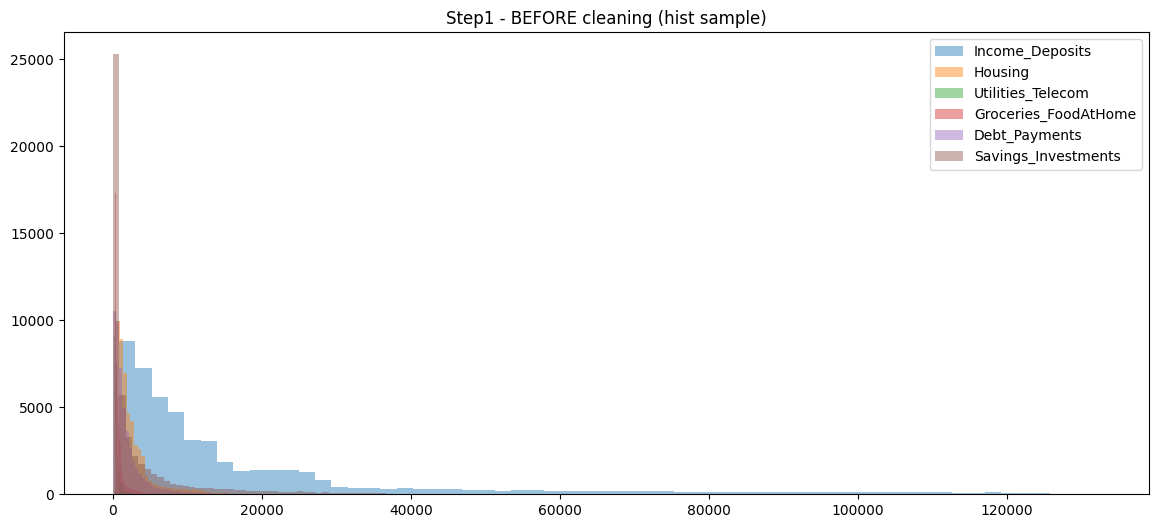

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


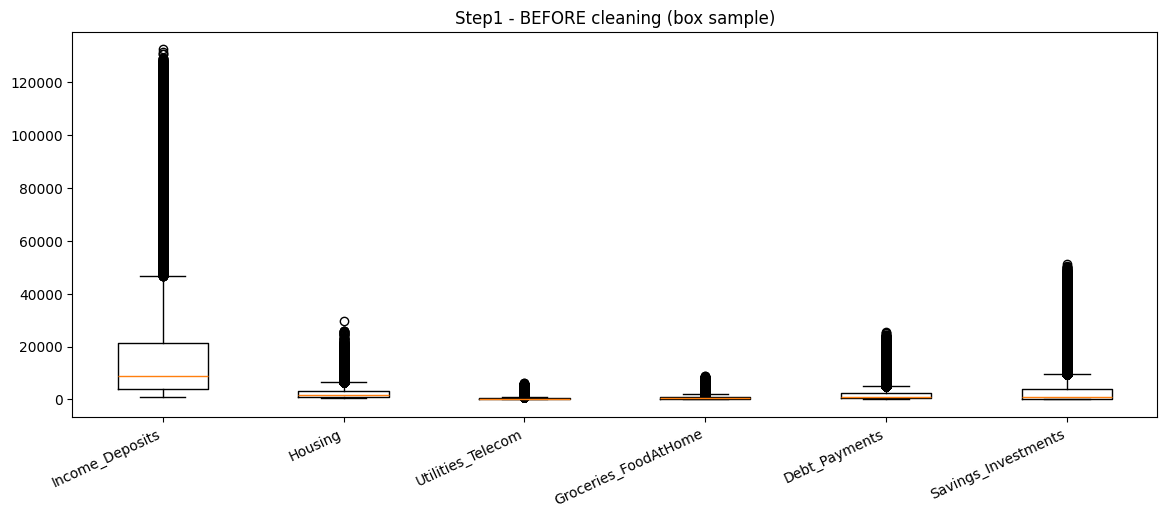


rows after: 5760000
missing after: 0
negatives after: 0


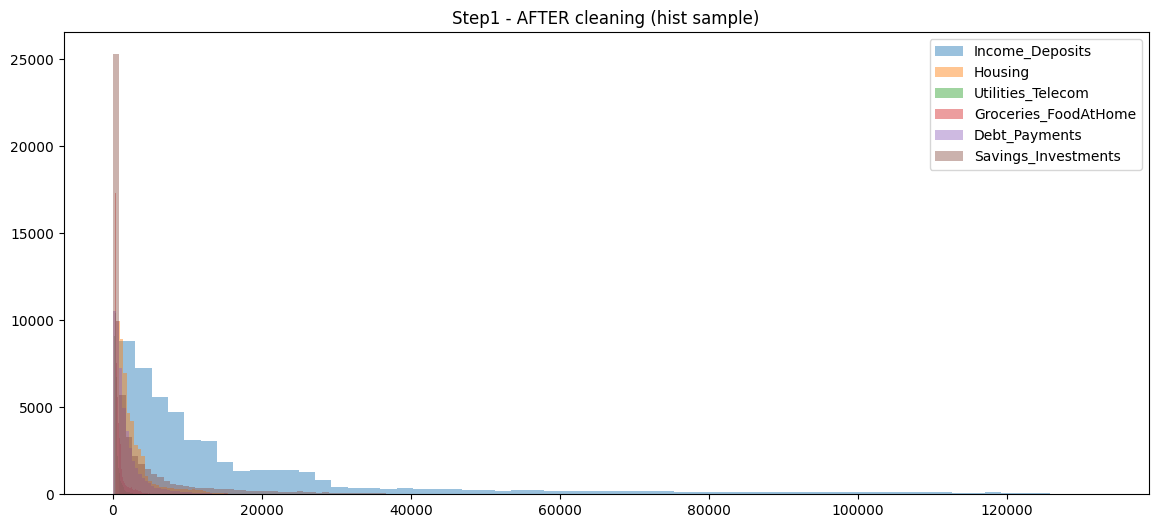

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


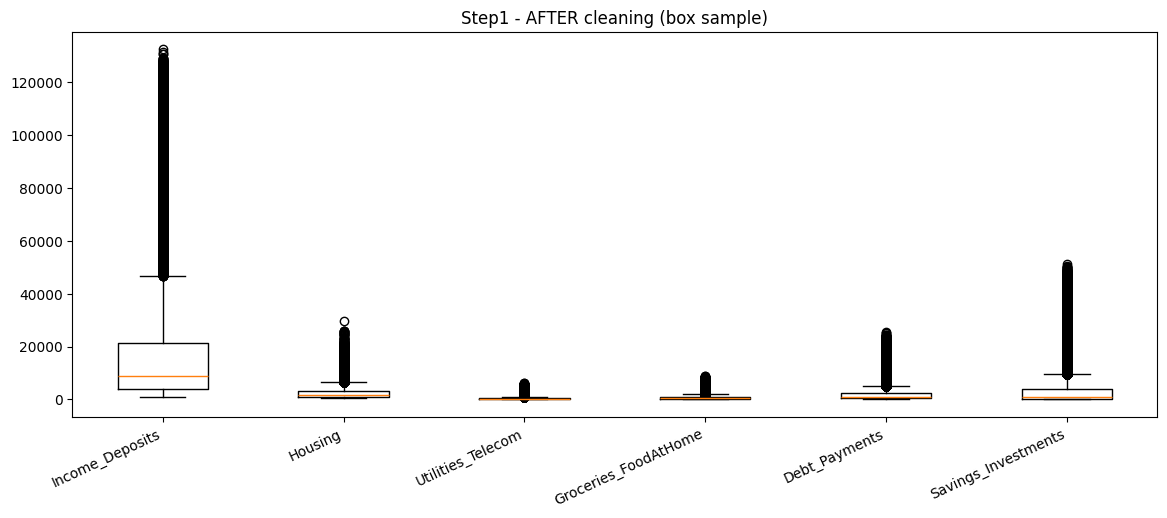


Step1 done. saved as STATE['df_clean_monthly']


In [5]:
df0 = df_monthly.copy()

META = {"cluster","cluster_index","person_id","month_index"}
if "Income_Deposits" not in df0.columns:
    raise ValueError("Income_Deposits is missing, check your csv column name")

INCOME_COL = "Income_Deposits"
money_cols = [c for c in df0.columns if c not in META]
outflow_cols = [c for c in money_cols if c != INCOME_COL]

# pick some columns for plots (only if they exist)
plot_candidates = [INCOME_COL, "Housing", "Utilities_Telecom", "Groceries_FoodAtHome", "Debt_Payments", "Savings_Investments", "Travel"]
plot_cols = [c for c in plot_candidates if c in df0.columns]

print("rows before:", len(df0))
print("missing before:", int(df0.isna().sum().sum()))
print("negatives before:", int((df0[outflow_cols] < 0).sum().sum()) if len(outflow_cols) else 0)

# plots BEFORE
plot_hist_overlay(df0, plot_cols[:6], "Step1 - BEFORE cleaning (hist sample)")
plot_box(df0, plot_cols[:6], "Step1 - BEFORE cleaning (box sample)")

# cleaning rules
df1 = df0.replace([np.inf, -np.inf], np.nan).copy()

# IMPORTANT:
# - do NOT blanket-fill NaNs with 0 (trees will learn missingness shortcuts)
# - only treat missing spend categories as $0 after validating income
df1 = df1[df1[INCOME_COL].notna()]
df1 = df1[df1[INCOME_COL] > 0]

# missing spend means $0 (ONLY for outflow cols)
for c in outflow_cols:
    df1[c] = df1[c].fillna(0.0)

# no negative spending
for c in outflow_cols:
    df1[c] = df1[c].clip(lower=0.0)

# essentials average-case (skip if column doesnt exist)
essentials = [c for c in ["Housing","Utilities_Telecom","Groceries_FoodAtHome"] if c in df1.columns]
for c in essentials:
    df1 = df1[df1[c] > 0]

# add totals + cashflow for later
df1["TotalOutflow"] = df1[outflow_cols].sum(axis=1).astype(np.float32)
df1["NetCashflow"] = (df1[INCOME_COL] - df1["TotalOutflow"]).astype(np.float32)
df1["NetCashflowRate"] = (df1["NetCashflow"] / df1[INCOME_COL]).astype(np.float32)

print("\nrows after:", len(df1))
print("missing after:", int(df1.isna().sum().sum()))
print("negatives after:", int((df1[outflow_cols] < 0).sum().sum()) if len(outflow_cols) else 0)

# plots AFTER
plot_hist_overlay(df1, plot_cols[:6], "Step1 - AFTER cleaning (hist sample)")
plot_box(df1, plot_cols[:6], "Step1 - AFTER cleaning (box sample)")

STATE["df_clean_monthly"] = df1
print("\nStep1 done. saved as STATE['df_clean_monthly']")

Feature Encoding (shares + rates) with person-level table and baseline eval

In [6]:
# important: do NOT use income as an input feature, but use it to compute shares.
# also move to person-level dataset to avoid leakage and reduce compute.

dfm = STATE["df_clean_monthly"].copy()

# define feature money cols again
money_cols = [c for c in dfm.columns if c not in META]
outflow_cols = [c for c in money_cols if c not in (INCOME_COL, "TotalOutflow", "NetCashflow", "NetCashflowRate")]

# (safety) if any spend columns still have NaN, treat as $0 (ONLY spend columns)
for c in outflow_cols:
    dfm[c] = dfm[c].fillna(0.0)

# create share features for each outflow
for c in outflow_cols:
    dfm[f"{c}__share"] = (dfm[c] / dfm[INCOME_COL]).astype(np.float32)

# summary rates (only if columns exist)
def safe_sum(cols):
    cols2 = [c for c in cols if c in dfm.columns]
    if not cols2:
        return 0.0
    return dfm[cols2].sum(axis=1)

dfm["EssentialRate"] = (safe_sum(["Housing","Utilities_Telecom","Groceries_FoodAtHome"]) / dfm[INCOME_COL]).astype(np.float32)
dfm["DebtRate"] = (dfm["Debt_Payments"] / dfm[INCOME_COL]).astype(np.float32) if "Debt_Payments" in dfm.columns else 0.0
dfm["SavingsRate"] = (dfm["Savings_Investments"] / dfm[INCOME_COL]).astype(np.float32) if "Savings_Investments" in dfm.columns else 0.0
dfm["DiscretionaryRate"] = (safe_sum(["Dining_FoodAway","Entertainment","Travel","Subscriptions_Memberships"]) / dfm[INCOME_COL]).astype(np.float32)
# NetCashflowRate already exists from cleaning

share_cols = [c for c in dfm.columns if c.endswith("__share")]
rate_cols = ["EssentialRate","DebtRate","SavingsRate","DiscretionaryRate","NetCashflowRate"]
rate_cols = [c for c in rate_cols if c in dfm.columns]

# now person-level: mean/median/std over 48 months
g = dfm.groupby("person_id", sort=False)

# OPTIONAL BUT STRONGLY RECOMMENDED:
# keep only people with enough months after cleaning, otherwise std becomes unstable
counts = g.size()
min_months = int(0.80 * MONTHS_PER_PERSON)
keep_ids = counts[counts >= min_months].index
dfm = dfm[dfm["person_id"].isin(keep_ids)].copy()
g = dfm.groupby("person_id", sort=False)

agg = g[share_cols + rate_cols].agg(["mean","median","std"]).reset_index()
agg.columns = ["person_id"] + [f"{c}__{stat}" for c, stat in agg.columns[1:]]

labels = g[["cluster_index","cluster"]].first().reset_index()

df_people = labels.merge(agg, on="person_id", how="inner")

# IMPORTANT:
# std can be NaN if someone has too few months; convert ONLY those std NaNs to 0
std_cols = [c for c in df_people.columns if c.endswith("__std")]
df_people[std_cols] = df_people[std_cols].fillna(0.0)

# fast cap
if FAST_MODE and len(df_people) > PEOPLE_CAP_FAST:
    df_people = df_people.sample(n=PEOPLE_CAP_FAST, random_state=RANDOM_SEED)

print("people rows:", df_people.shape)
print(df_people["cluster"].value_counts())

X_base = df_people.drop(columns=["cluster","cluster_index","person_id"])
y_base = df_people["cluster_index"].astype(int).values
groups = df_people["person_id"].astype(np.int64).values

# baseline evaluation
acc0, f10 = quick_eval_lr(X_base, y_base, groups, scaler_name="standard", penalty_mode="l2")
print(f"\nStep2 baseline eval (LR): acc={acc0:.4f} macro_f1={f10:.4f}")

STATE["df_people"] = df_people
STATE["X_current"] = X_base
STATE["y"] = y_base
STATE["groups"] = groups
STATE["feature_cols"] = list(X_base.columns)
print("\nStep2 done. saved df_people + X_current")

people rows: (120000, 66)
cluster
C1_low          20000
C2_lower_mid    20000
C3_mid          20000
C4_upper_mid    20000
C5_high         20000
C6_top5         20000
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step2 baseline eval (LR): acc=0.9997 macro_f1=0.9997

Step2 done. saved df_people + X_current


Cluster checks (prevents the same class clustering)

In [7]:
df_people = STATE["df_people"]
X = STATE["X_current"]
y = STATE["y"]
groups = STATE["groups"]

print("\nSanity: label distribution (people):")
print(pd.Series(y).value_counts().sort_index())

# quick baseline: only income-derived feature(s)
income_like = [c for c in X.columns if "IncomeLog" in c]
if income_like:
    acc_i, f1_i = quick_eval_lr(X[income_like], y, groups, scaler_name="standard", penalty_mode="l2")
    print(f"\nSanity baseline using ONLY income-derived stats: acc={acc_i:.4f} macro_f1={f1_i:.4f}")
else:
    print("\nNo income-derived features found (IncomeLog).")

# check for near-constant features
stds = X.std(axis=0).sort_values()
near_const = stds[stds < 1e-10]
print(f"\nNear-constant feature count (<1e-10 std): {len(near_const)}")
print(near_const.head(10))



Sanity: label distribution (people):
0    20000
1    20000
2    20000
3    20000
4    20000
5    20000
Name: count, dtype: int64

No income-derived features found (IncomeLog).

Near-constant feature count (<1e-10 std): 0
Series([], dtype: float32)


Data Normalization (square, inverse, log, z-score, and more) with before/after plots, eval, and pick best

Step3 normalization compare:   0%|          | 0/9 [00:00<?, ?it/s]

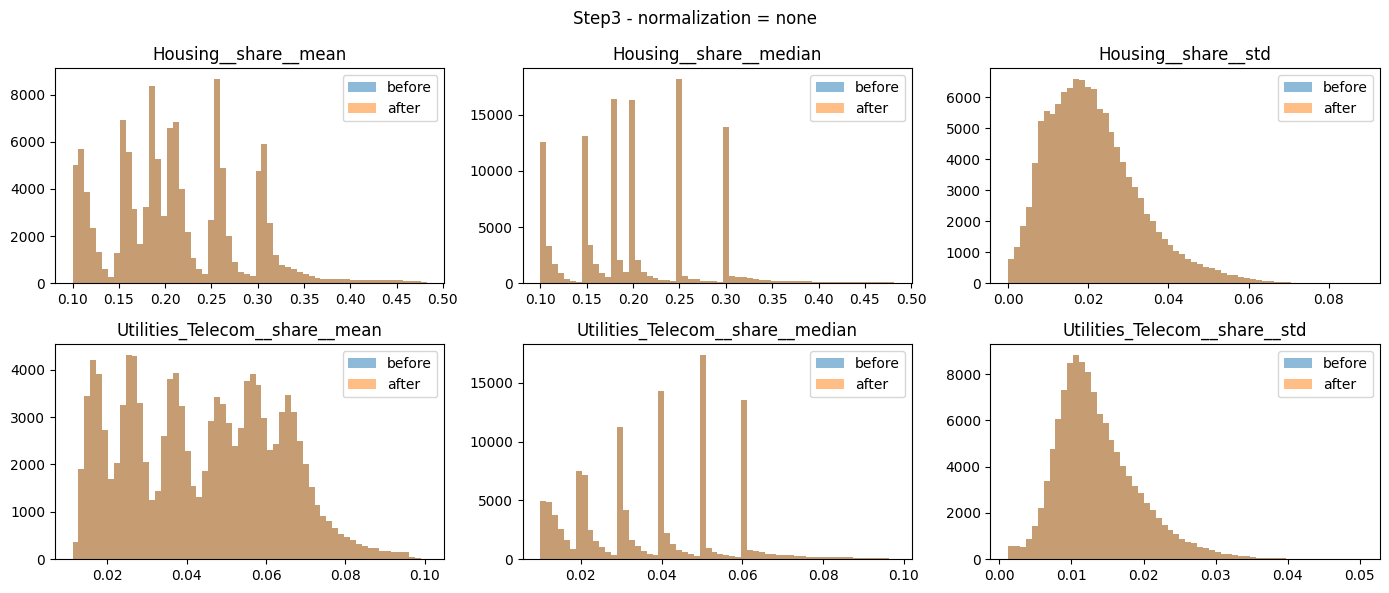

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


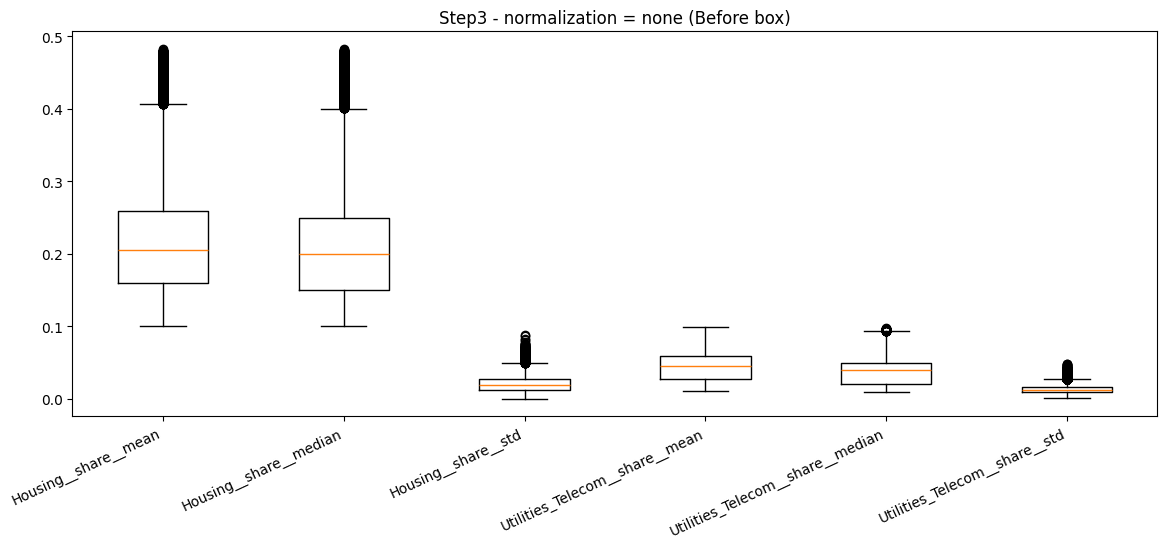

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


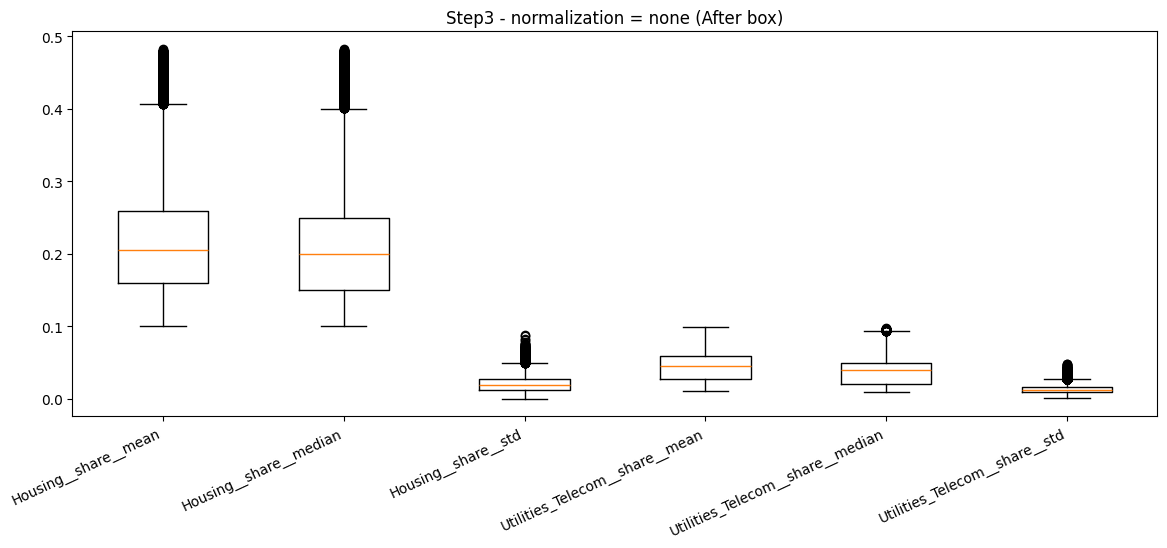

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


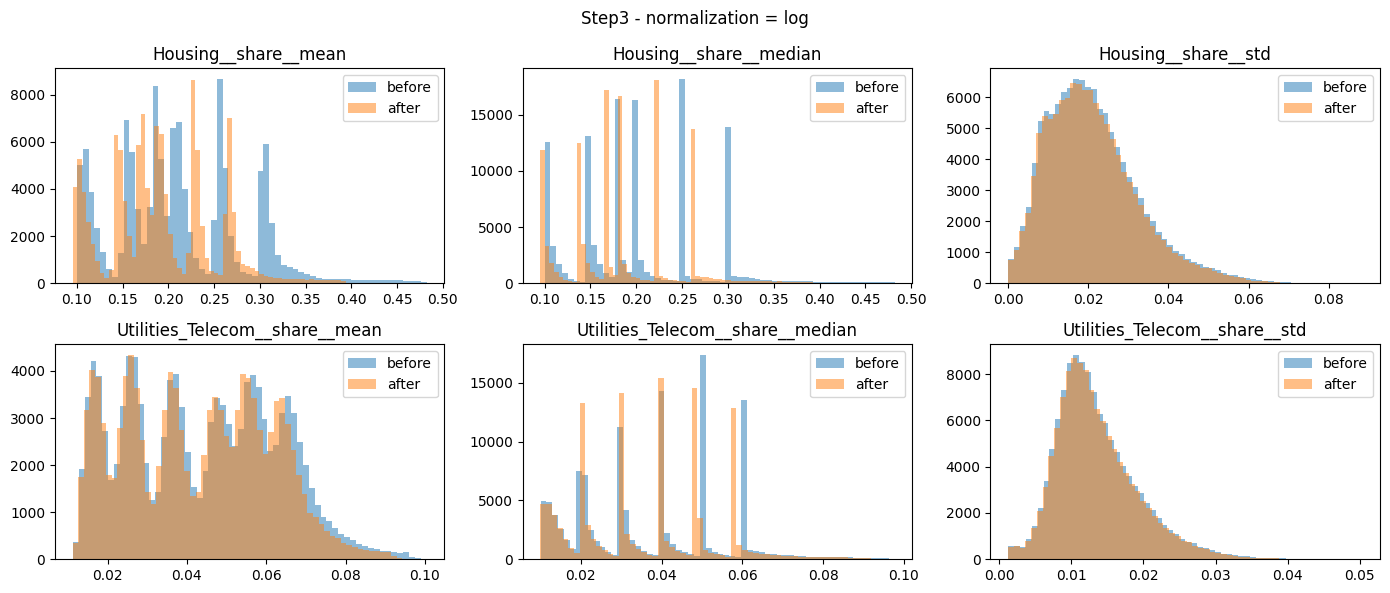

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


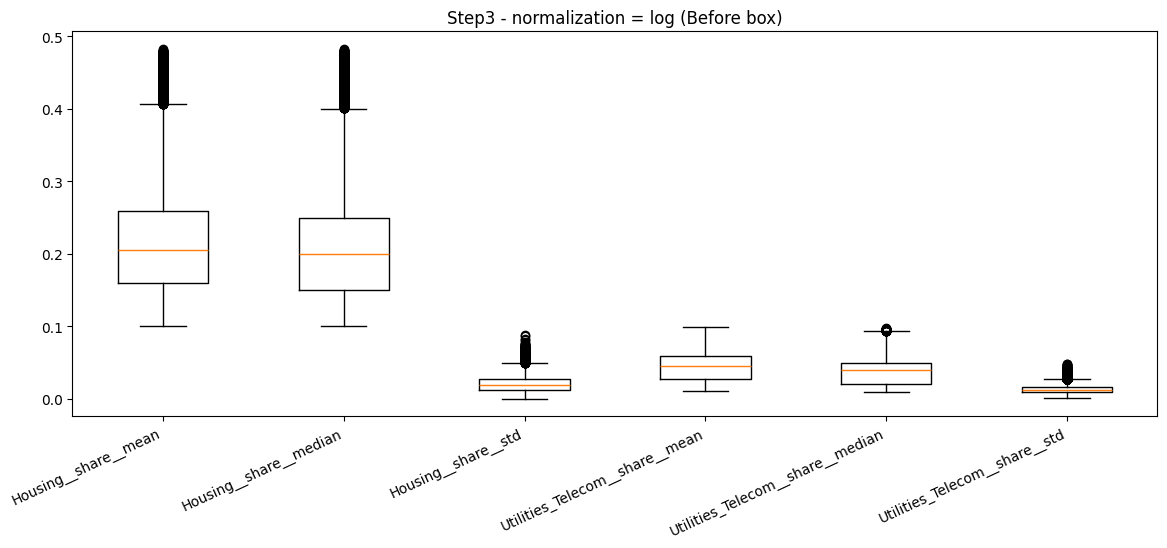

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


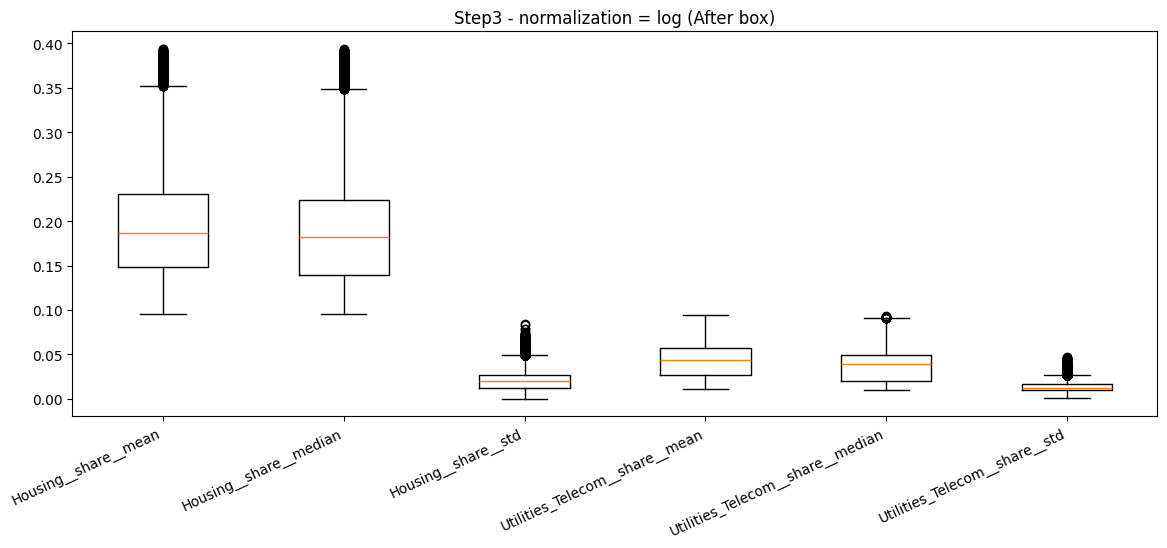

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


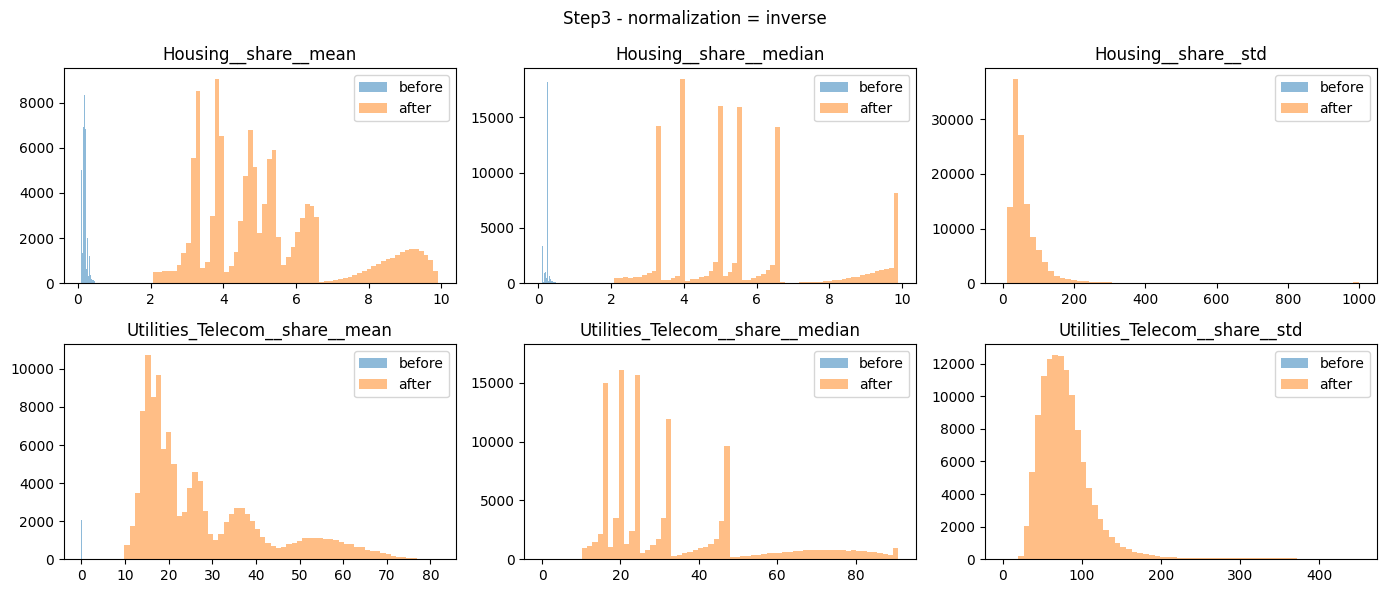

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


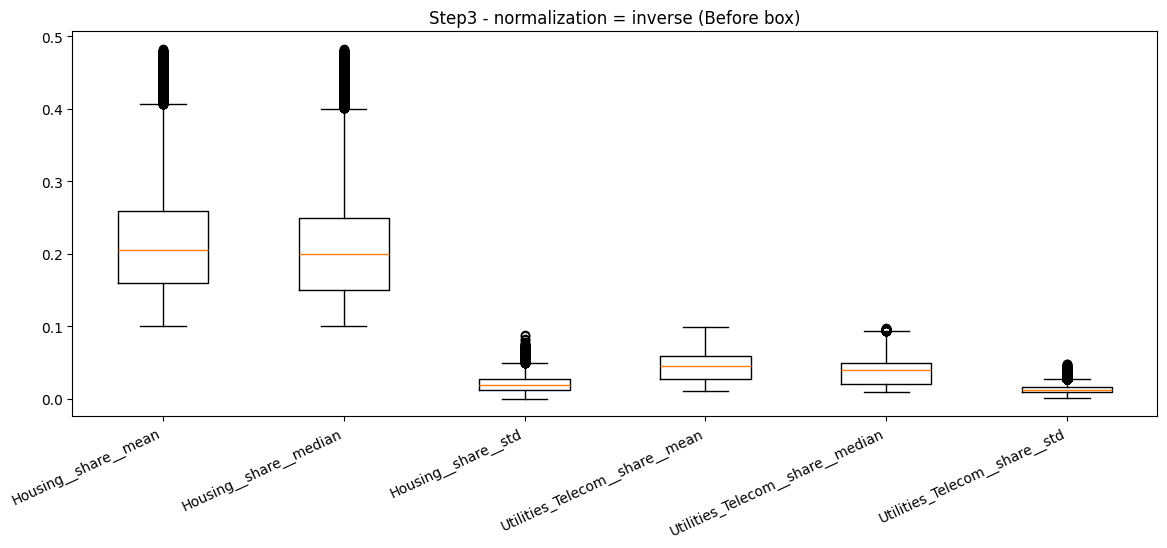

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


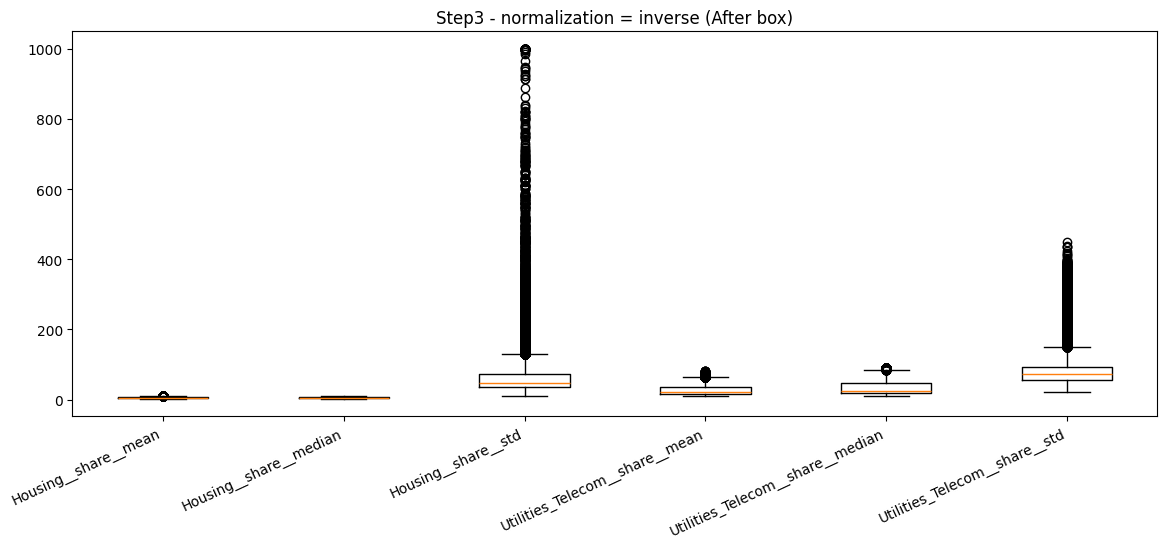

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


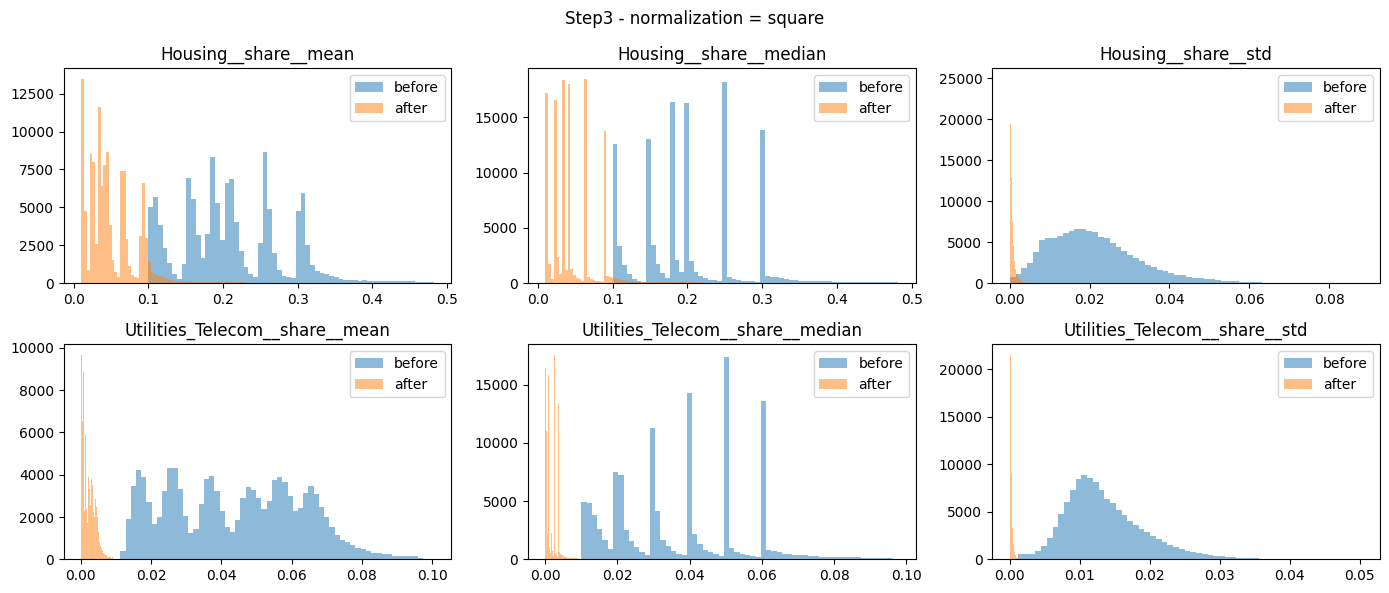

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


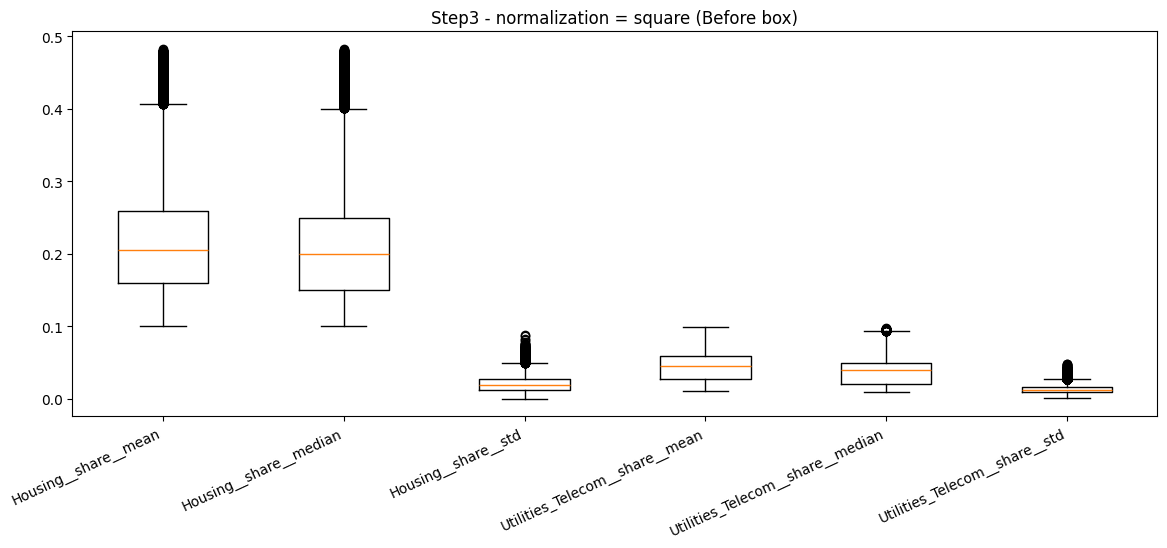

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


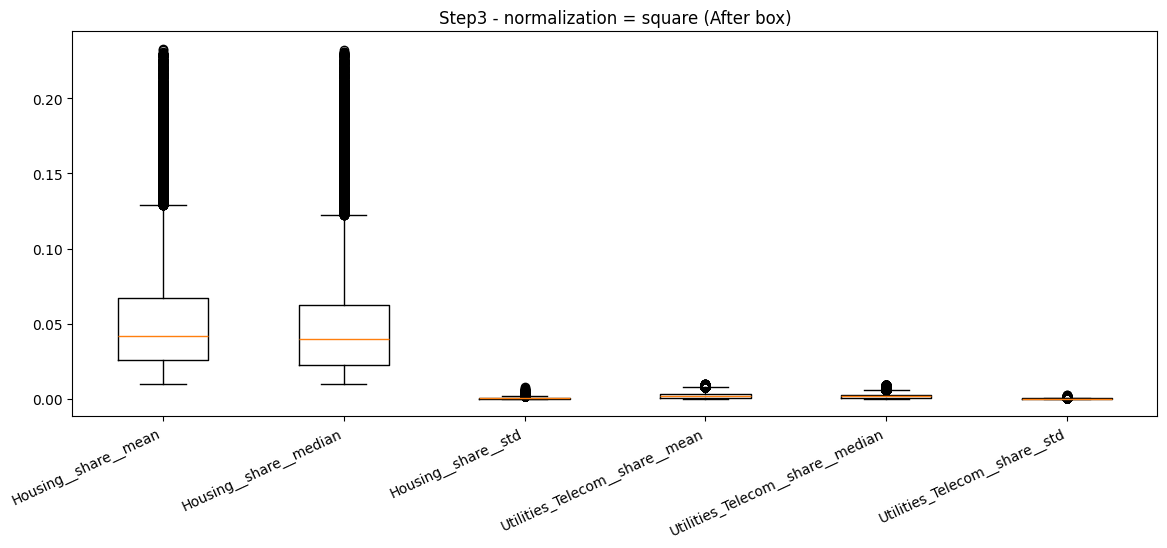

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


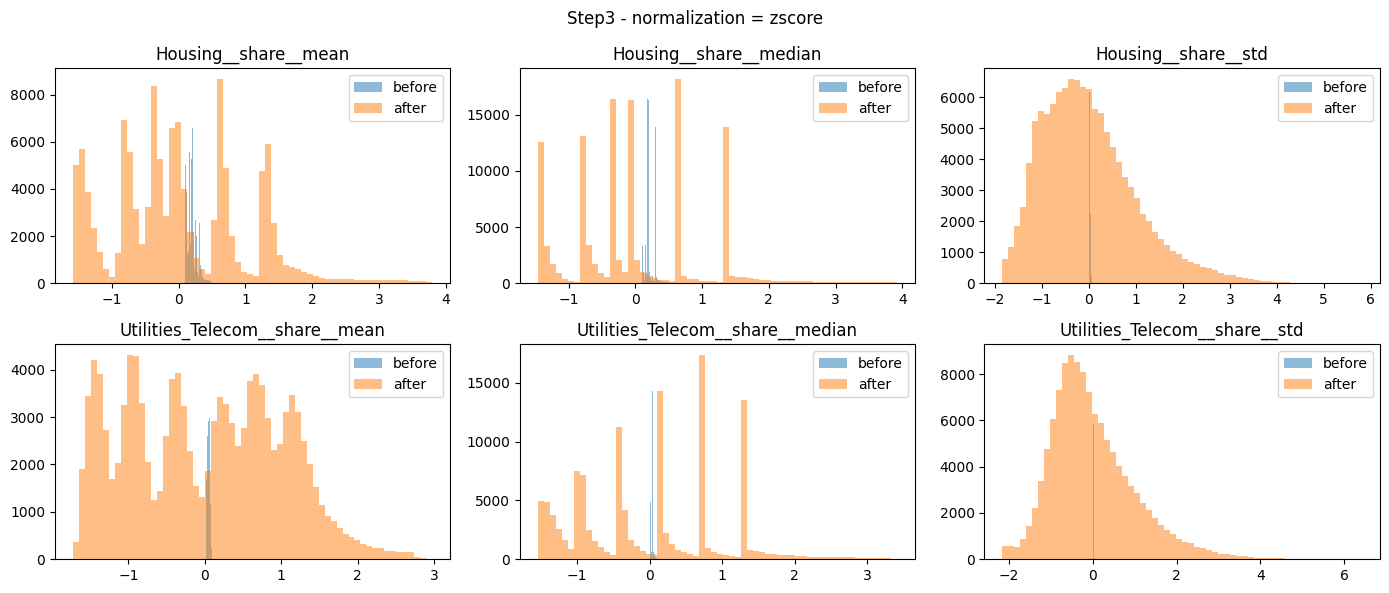

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


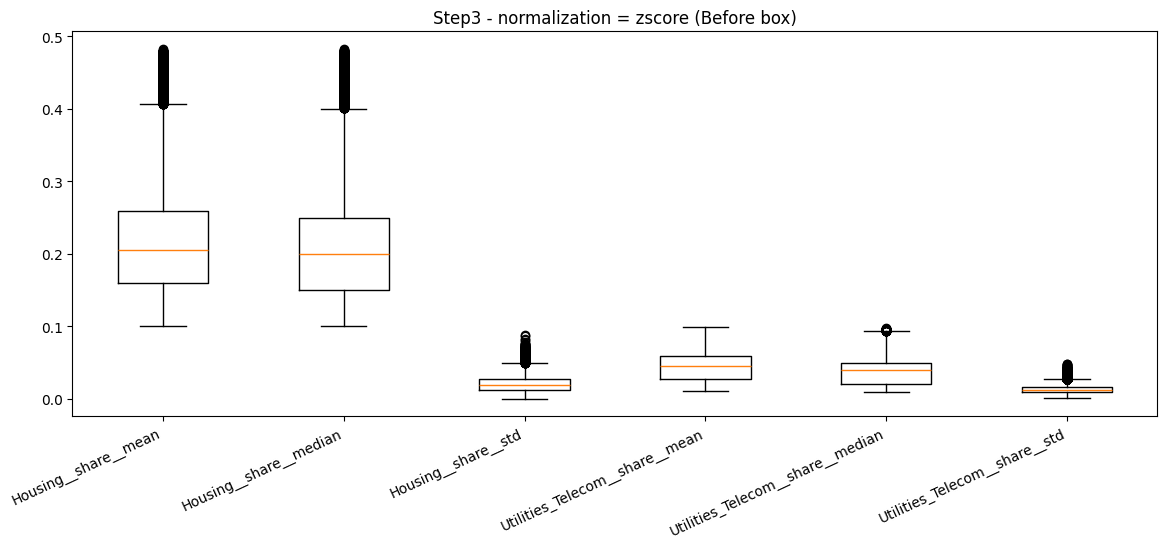

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


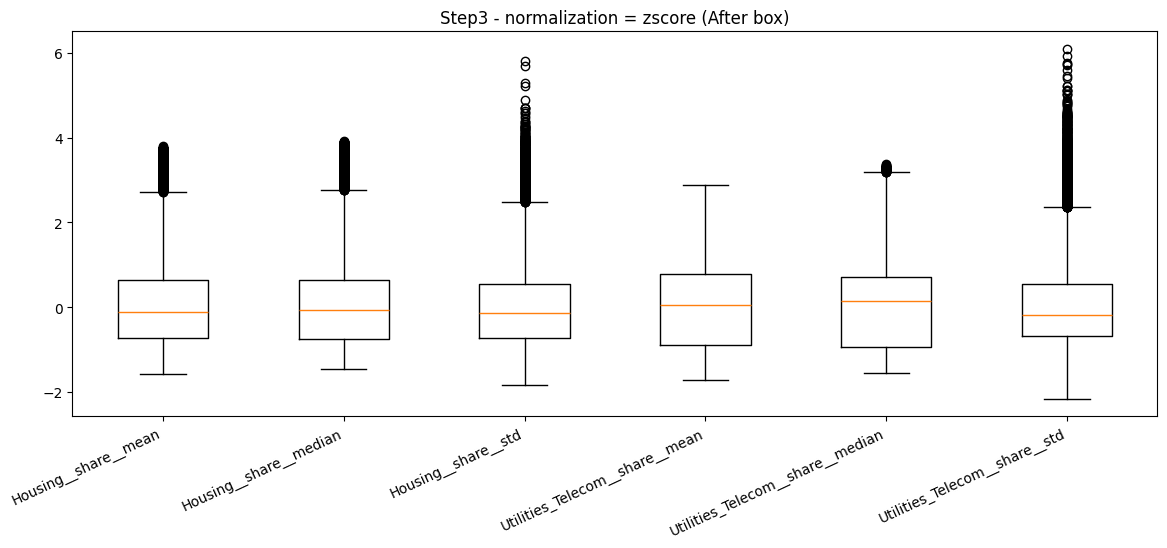

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


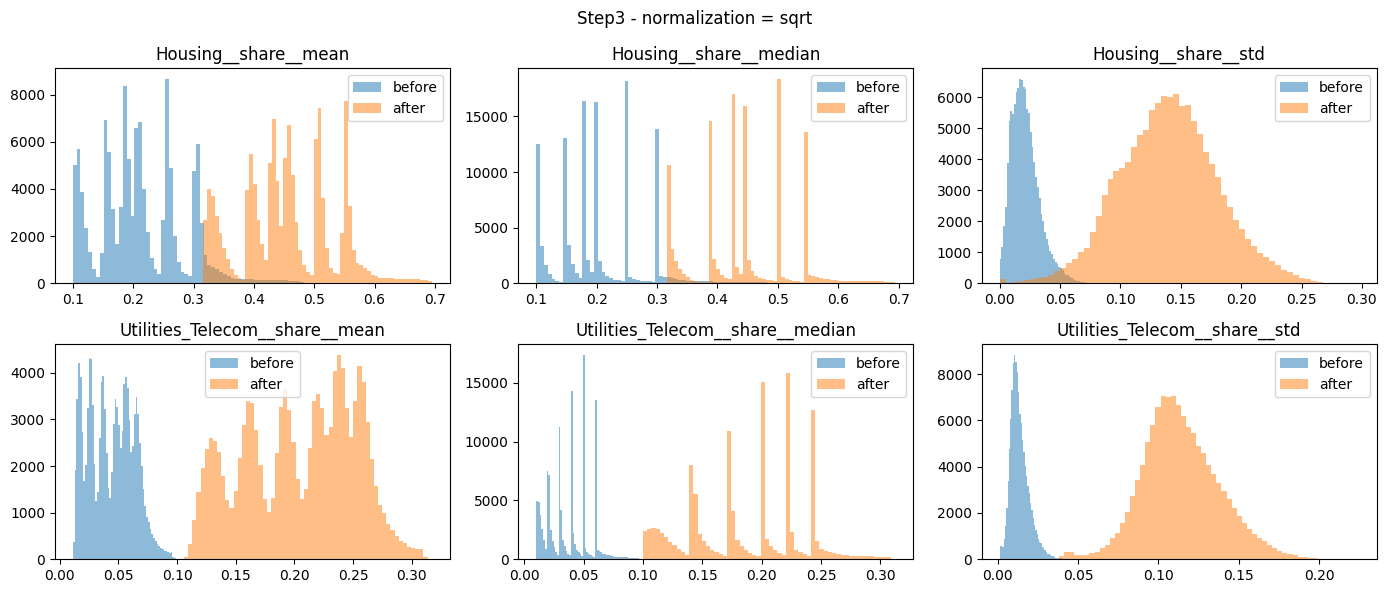

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


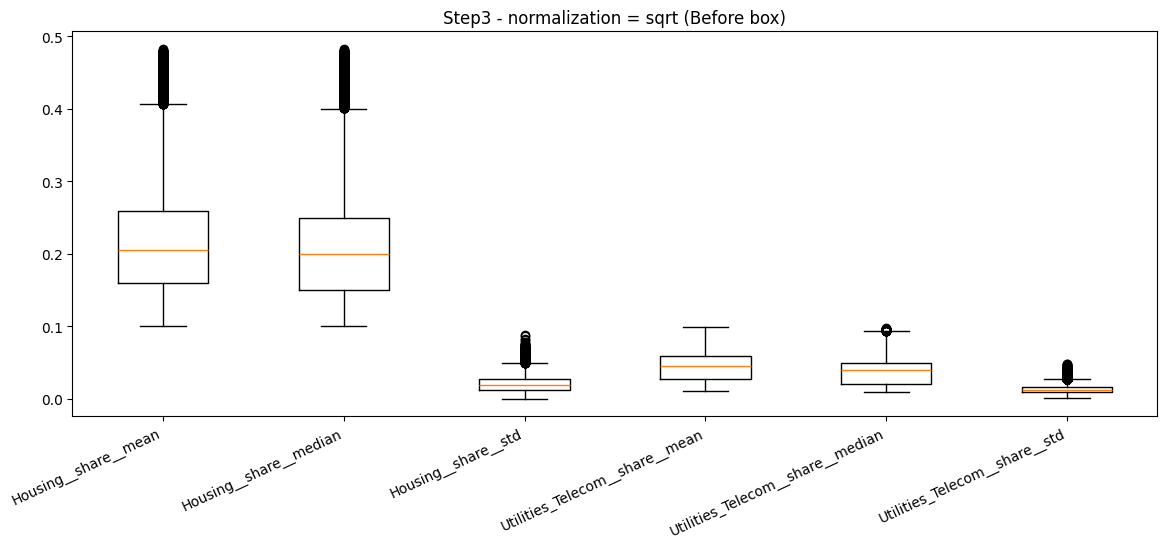

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


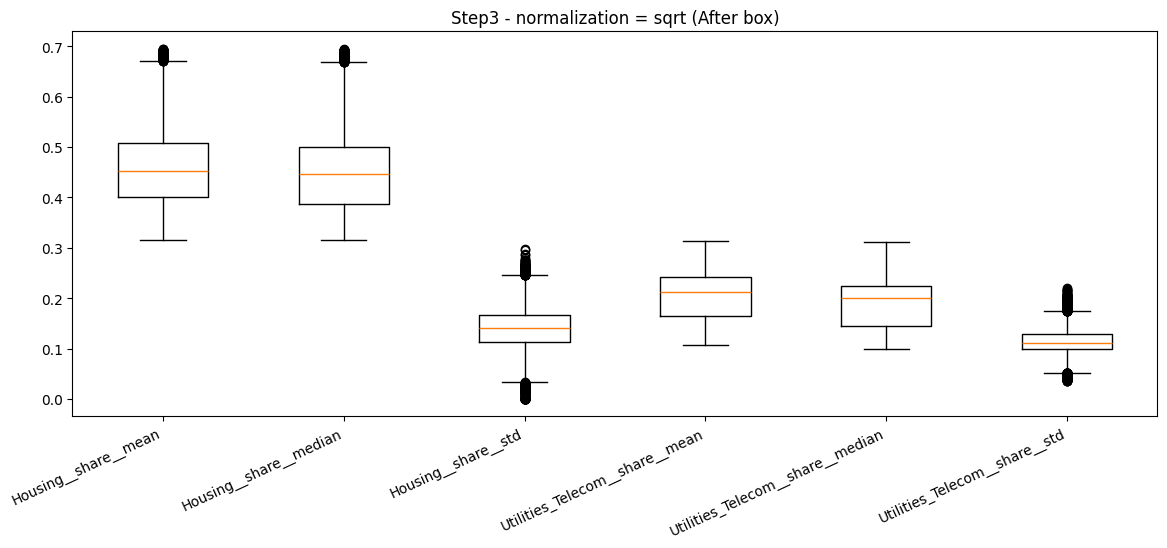

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


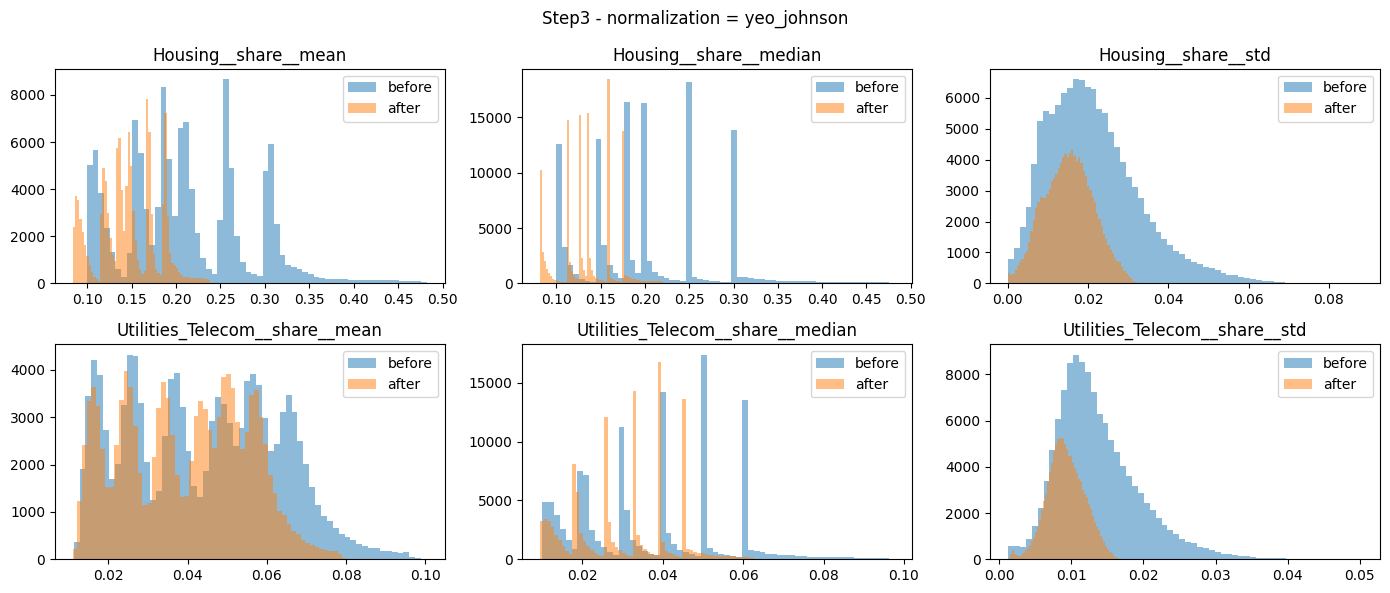

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


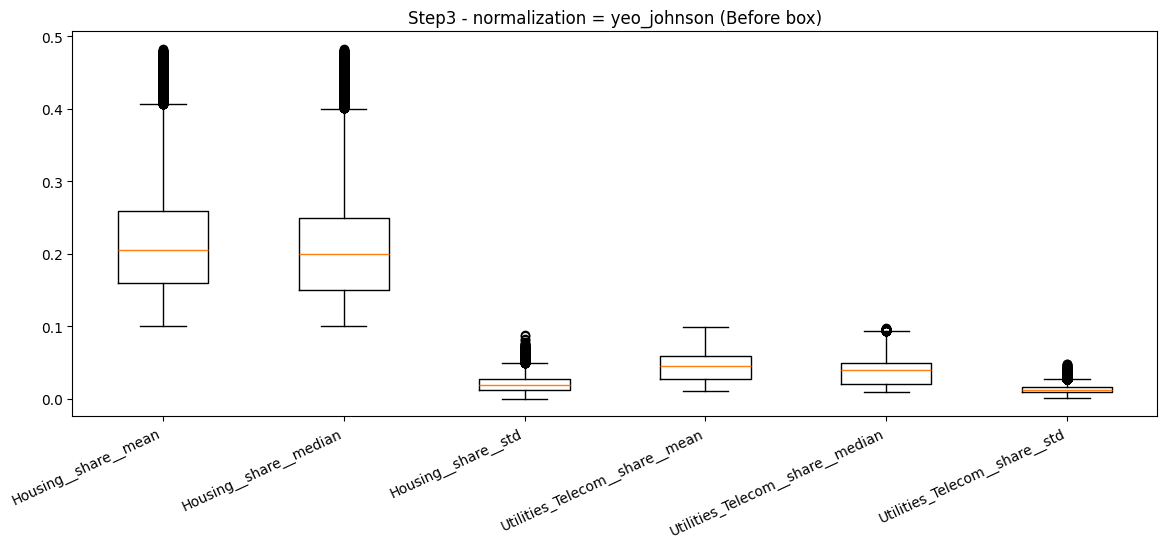

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


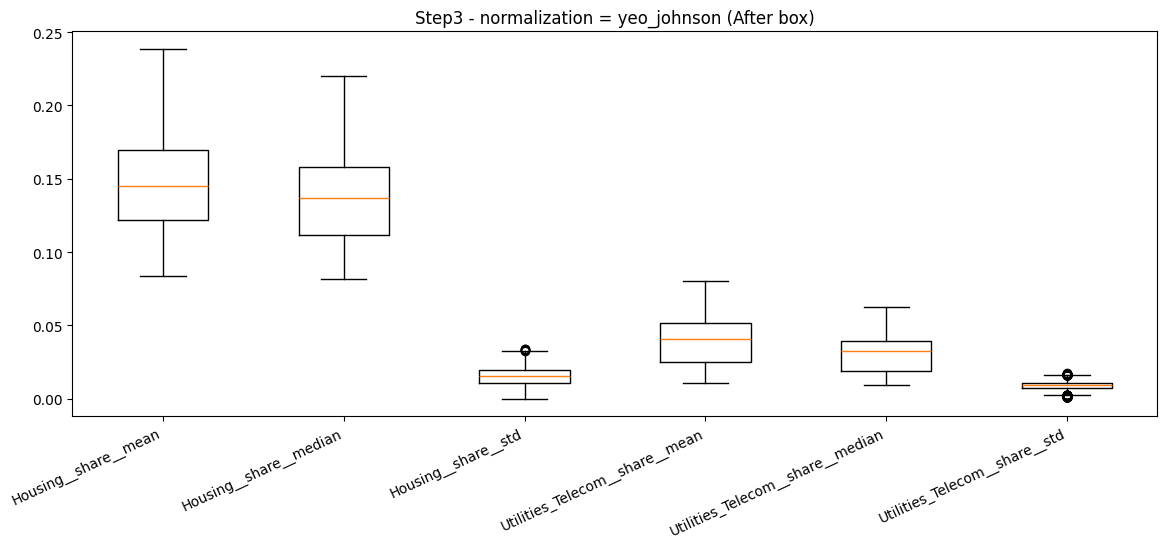

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


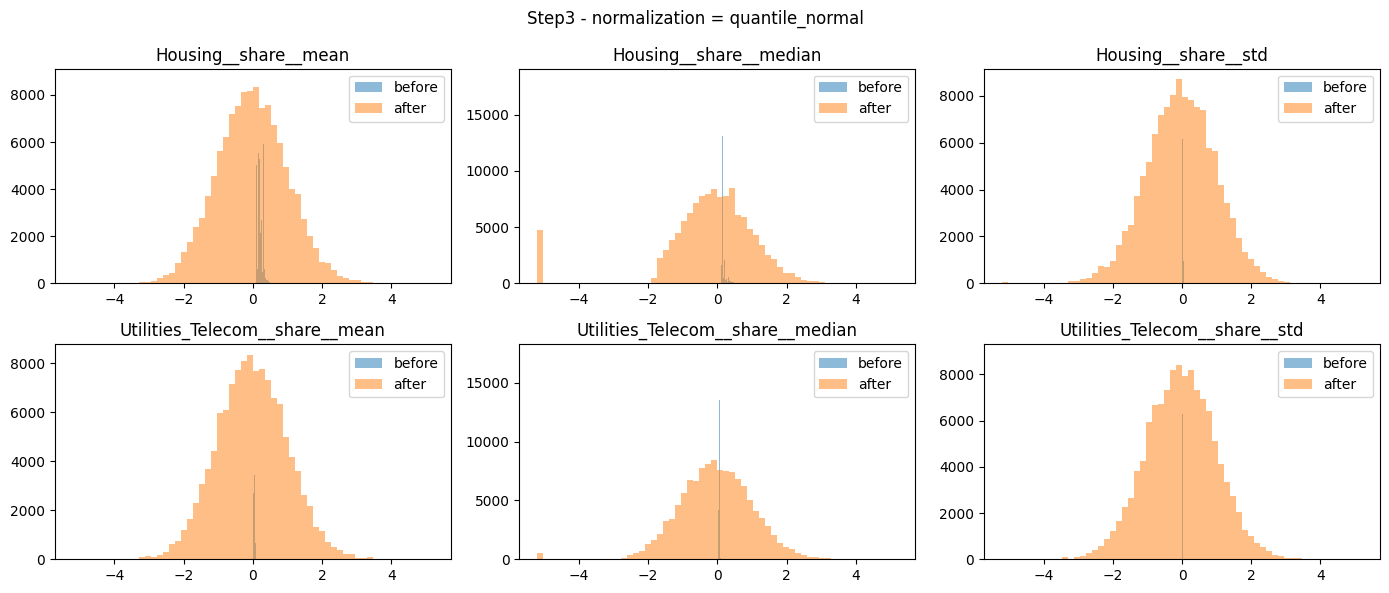

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


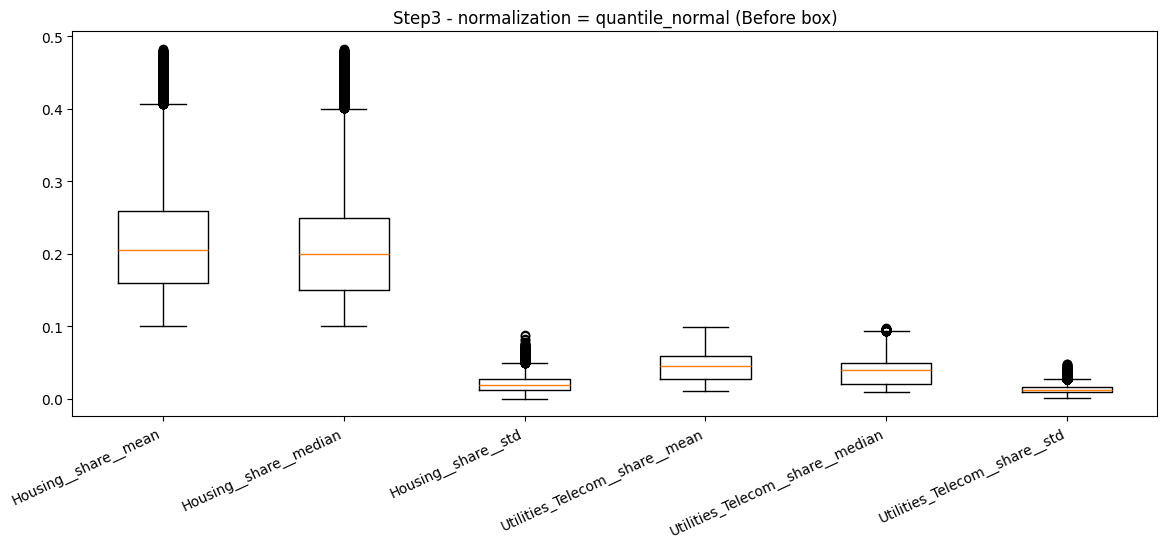

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


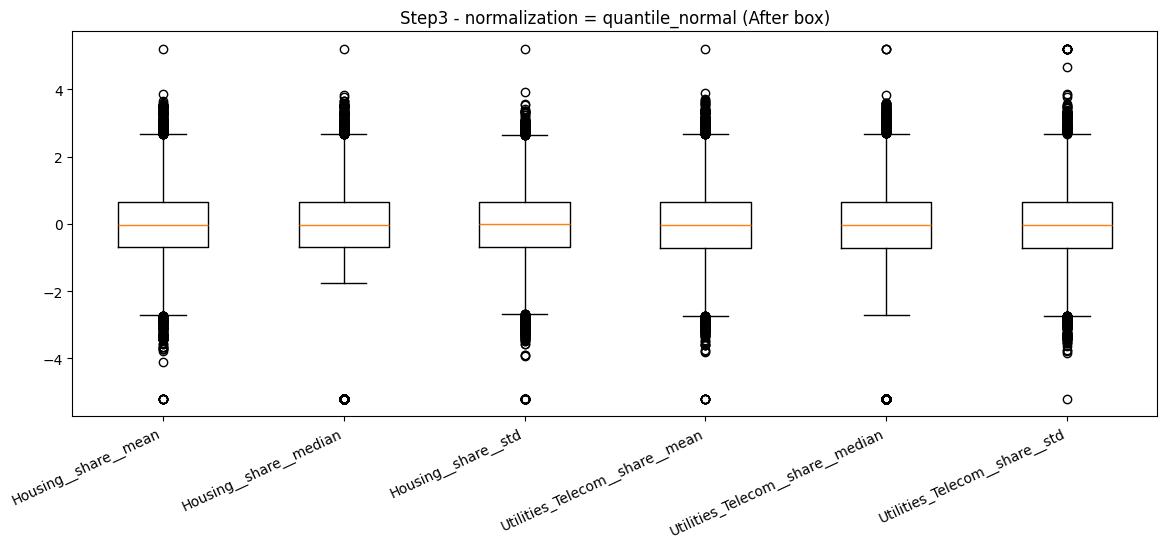

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


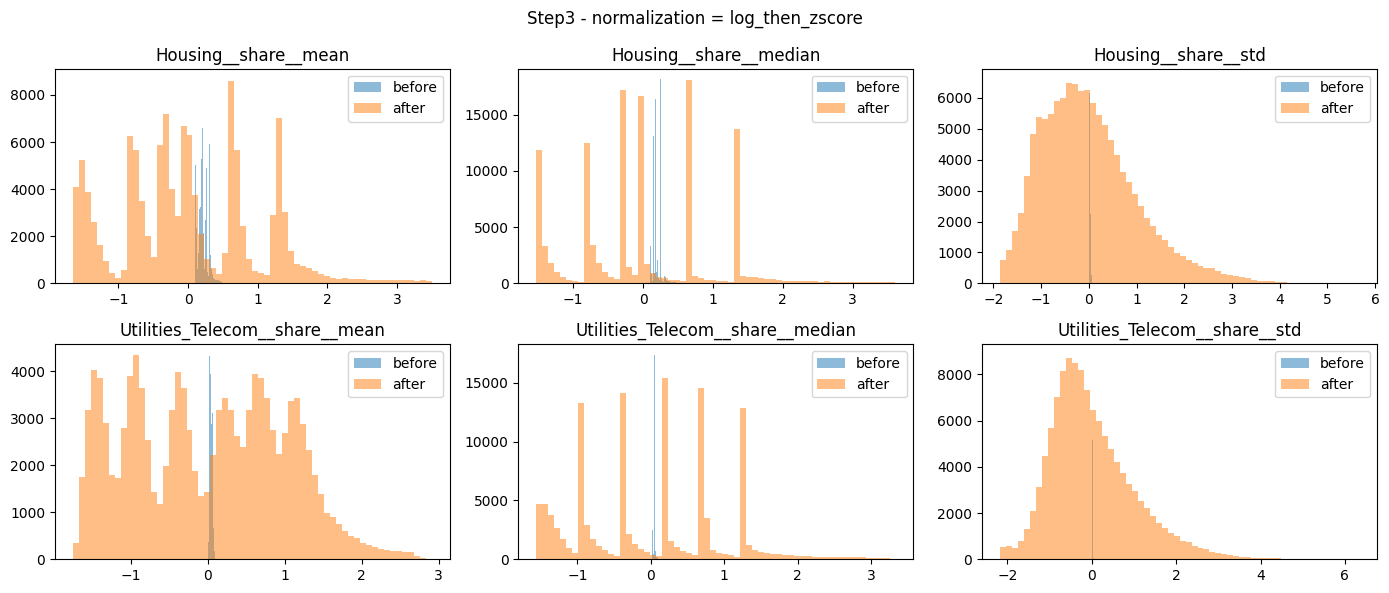

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


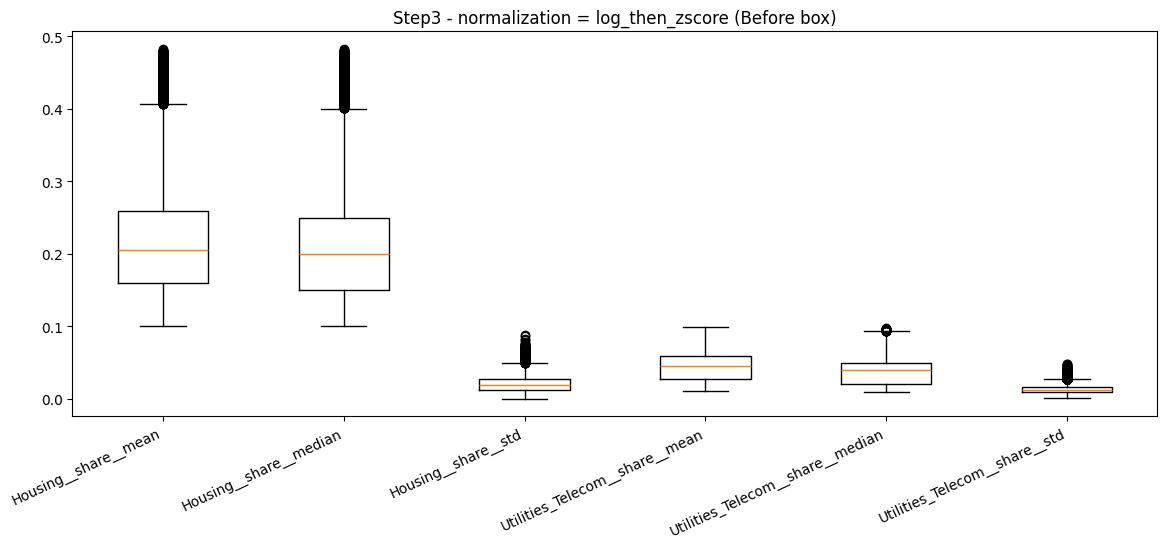

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


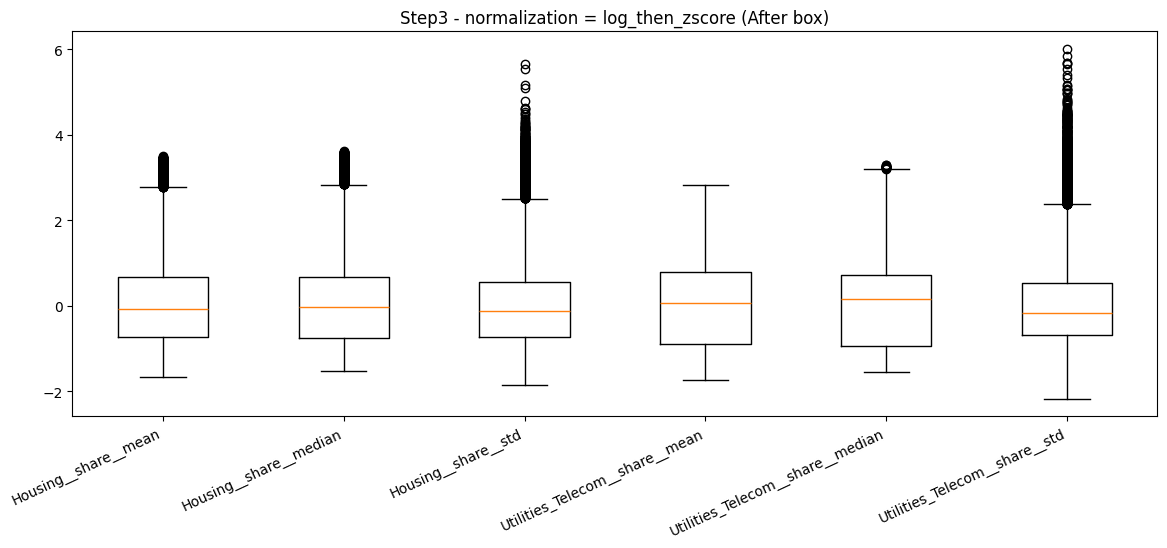

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step3 summary:


method       acc  macro_f1
5             sqrt  0.999833  0.999833
7  quantile_normal  0.999708  0.999706
8  log_then_zscore  0.999667  0.999666
0             none  0.999667  0.999665
1              log  0.999667  0.999664
6      yeo_johnson  0.999583  0.999580
4           zscore  0.999542  0.999539
3           square  0.999167  0.999159
2          inverse  0.998958  0.998954


Step3 BEST = sqrt | acc=0.9998 macro_f1=0.9998


In [8]:
# compare methods, plot before/after, eval each, keep best

X0 = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

# to keep plots readable, only show first 6 features
plot_feats = list(X0.columns[:6])
X_plot = X0[plot_feats].copy()

def apply_norm(Xdf, method):
    X = Xdf.copy()

    if method == "none":
        return X

    # IMPORTANT: use pandas clip so we keep DataFrame + columns
    if method == "log":
        return np.log1p(X.clip(lower=0))

    if method == "inverse":
        eps = 1e-3
        return 1.0 / (X.clip(lower=0) + eps)

    if method == "sqrt":
        return np.sqrt(X.clip(lower=0))

    if method == "square":
        return X * X

    if method == "yeo_johnson":
        from sklearn.preprocessing import PowerTransformer
        pt = PowerTransformer(method="yeo-johnson", standardize=False)
        Xt = pt.fit_transform(X.values)
        STATE["norm_obj_candidate"] = pt
        return pd.DataFrame(Xt, columns=X.columns, index=X.index)

    if method == "quantile_normal":
        from sklearn.preprocessing import QuantileTransformer
        qt = QuantileTransformer(output_distribution="normal", n_quantiles=min(2000, len(X)), random_state=RANDOM_SEED)
        Xt = qt.fit_transform(X.values)
        STATE["norm_obj_candidate"] = qt
        return pd.DataFrame(Xt, columns=X.columns, index=X.index)

    if method == "zscore":
        sc = StandardScaler()
        Xt = sc.fit_transform(X.values)
        STATE["norm_obj_candidate"] = sc
        return pd.DataFrame(Xt, columns=X.columns, index=X.index)

    if method == "log_then_zscore":
        X1 = np.log1p(X.clip(lower=0))
        sc = StandardScaler()
        Xt = sc.fit_transform(X1.values)
        STATE["norm_obj_candidate"] = sc
        return pd.DataFrame(Xt, columns=X.columns, index=X.index)

    raise ValueError(method)

def plot_before_after_df(X_before, X_after, title):
    # hist overlays
    plt.figure(figsize=(14, 6))
    for i, c in enumerate(X_before.columns):
        plt.subplot(2, 3, i+1)
        plt.hist(X_before[c].values, bins=60, alpha=0.5, label="before")
        plt.hist(X_after[c].values, bins=60, alpha=0.5, label="after")
        plt.title(c)
        plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # boxplots
    plot_box(X_before, list(X_before.columns), title + " (Before box)")
    plot_box(X_after, list(X_after.columns), title + " (After box)")

methods = ["none","log","inverse","square","zscore","sqrt","yeo_johnson","quantile_normal","log_then_zscore"]

results = []
best = {"method": None, "macro_f1": -1, "acc": -1, "X": None, "norm_obj": None}

pbar = tqdm(methods, desc="Step3 normalization compare")
for m in pbar:
    STATE["norm_obj_candidate"] = None
    Xm = apply_norm(X0, m)

    # plots (only on small feature slice to not crash colab UI)
    _ = None
    Xp_after = apply_norm(X_plot, m)
    plot_before_after_df(X_plot, Xp_after, f"Step3 - normalization = {m}")

    # eval
    # if you already zscored inside apply_norm, don't double-scale in eval
    scaler_in_eval = "none" if m in ("zscore","log_then_zscore") else "standard"
    acc, mf1 = quick_eval_lr(Xm, y, groups, scaler_name=scaler_in_eval, penalty_mode="l2")
    results.append((m, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["macro_f1"]:
        best.update({"method": m, "macro_f1": mf1, "acc": acc, "X": Xm, "norm_obj": STATE.get("norm_obj_candidate")})

pbar.close()

res_df = pd.DataFrame(results, columns=["method","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep3 summary:")
display(res_df)

print(f"\nStep3 BEST = {best['method']} | acc={best['acc']:.4f} macro_f1={best['macro_f1']:.4f}")

STATE["norm_method"] = best["method"]
STATE["norm_obj"] = best["norm_obj"]  # might be None for simple transforms
STATE["X_current"] = best["X"]


Data Regularization (L1, L2, 3rd = ElasticNet) with eval and pick best

In [9]:
# only compare on LR here because regularization is an LR thing mainly.

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

choices = [
    ("l2", {"C": 1.0}),
    ("l1", {"C": 1.0}),
    ("elasticnet", {"C": 1.0, "l1_ratio": 0.5}),
]

results = []
best = {"mode": None, "mf1": -1, "acc": -1, "params": None}

pbar = tqdm(choices, desc="Step4 regularization compare")
for mode, params in pbar:
    C = params.get("C", 1.0)
    l1r = params.get("l1_ratio", 0.5)

    acc, mf1 = quick_eval_lr(X, y, groups, scaler_name="standard", penalty_mode=mode, C=C, l1_ratio=l1r)
    results.append((mode, C, l1r, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"mode": mode, "mf1": mf1, "acc": acc, "params": params})

pbar.close()

res_df = pd.DataFrame(results, columns=["penalty","C","l1_ratio","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep4 summary:")
display(res_df)

print(f"\nStep4 BEST = {best['mode']} params={best['params']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["reg_mode"] = best["mode"]
STATE["reg_params"] = best["params"]


Step4 regularization compare:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step4 summary:


penalty    C  l1_ratio       acc  macro_f1
0          l2  1.0       0.5  0.999833  0.999833
1          l1  1.0       0.5  0.999583  0.999577
2  elasticnet  1.0       0.5  0.999542  0.999536


Step4 BEST = l2 params={'C': 1.0} | acc=0.9998 macro_f1=0.9998


Outlier Detection (IQR + 2nd way = MAD) with before/after plots, eval, and pick best

Step5 outlier compare:   0%|          | 0/3 [00:00<?, ?it/s]

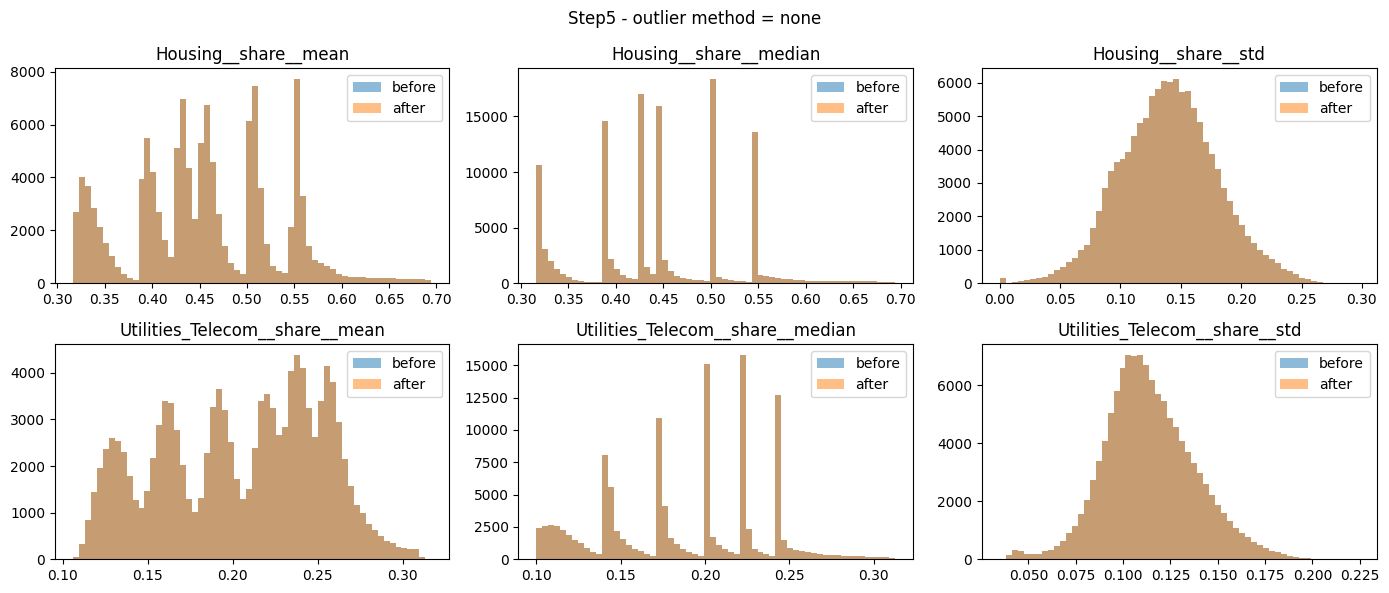

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


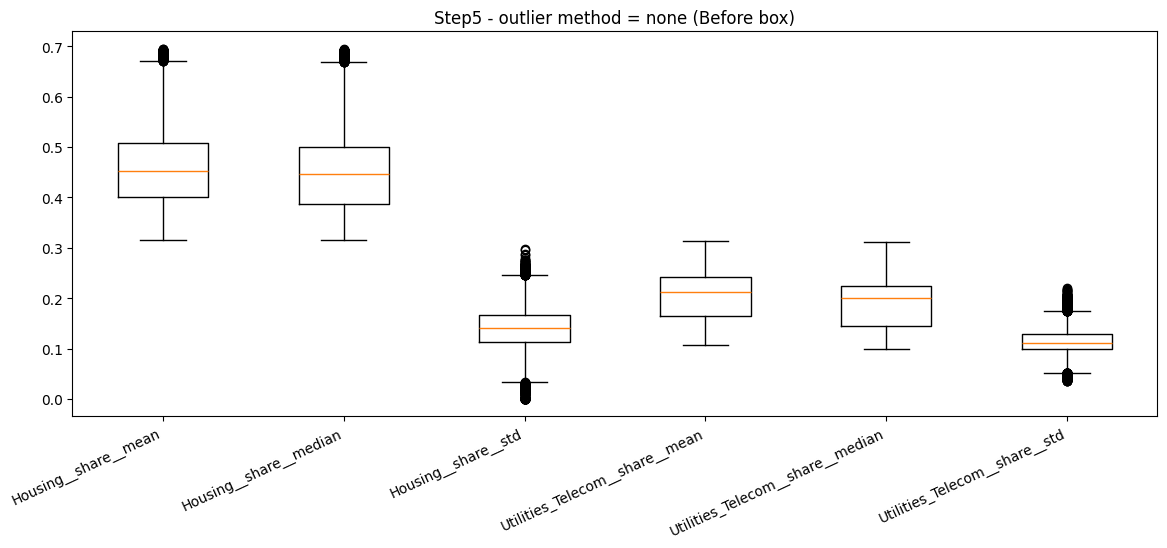

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


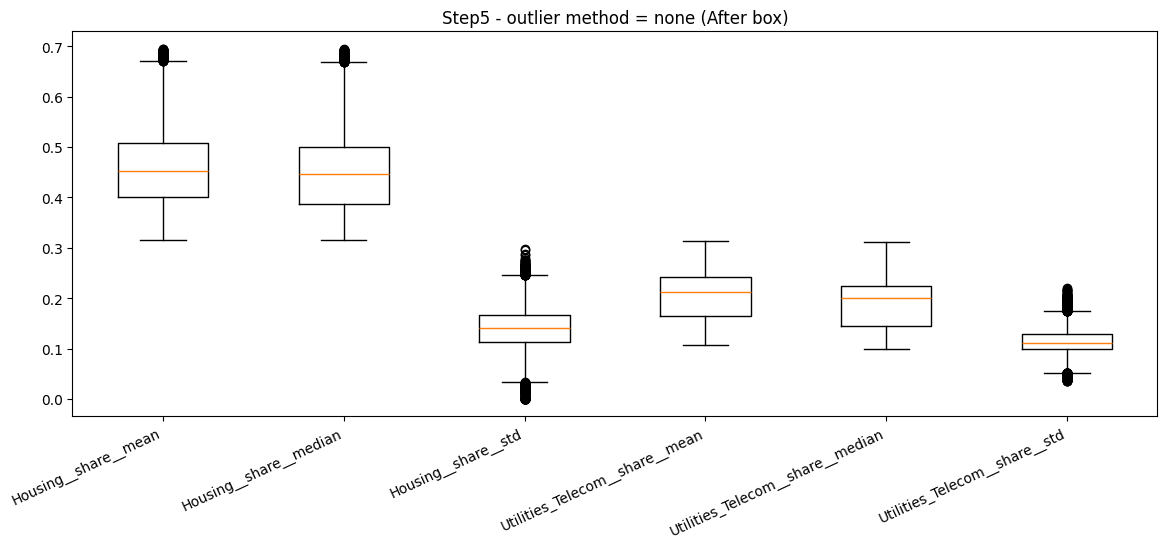

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


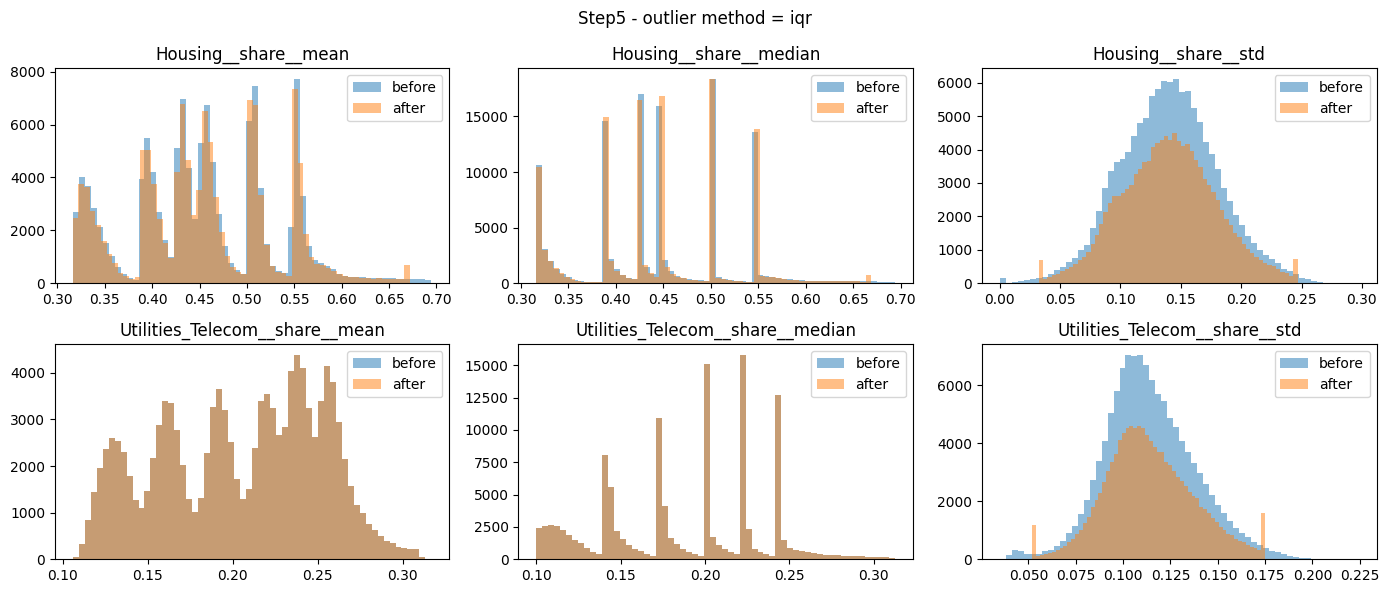

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


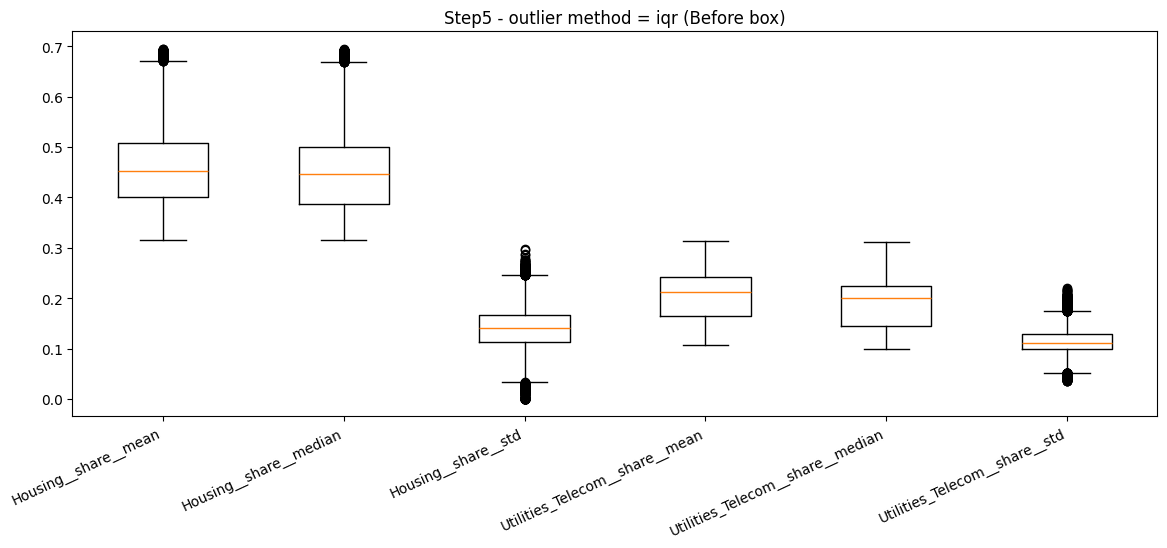

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


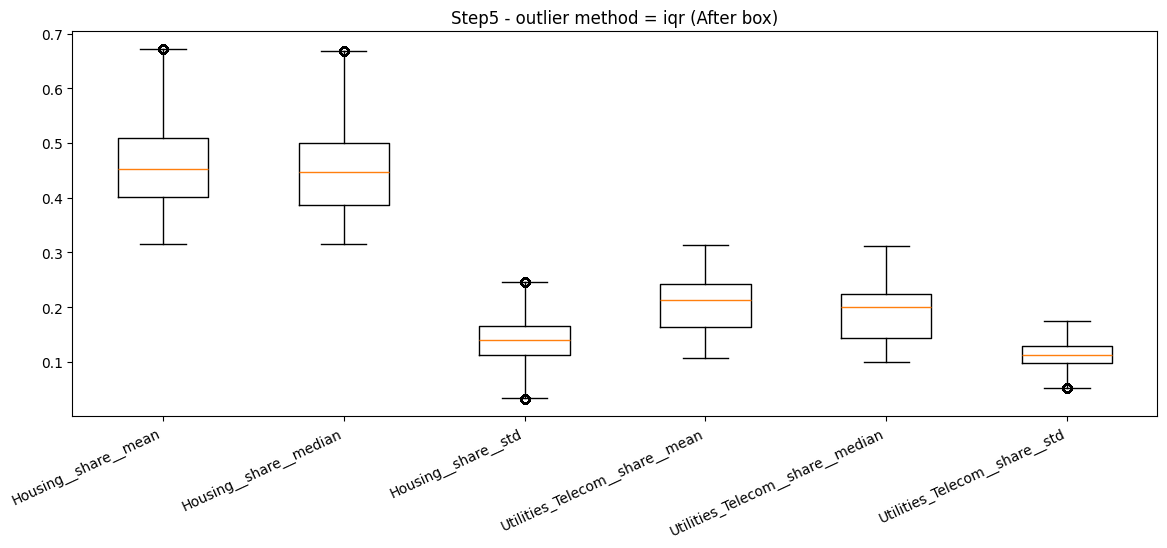

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


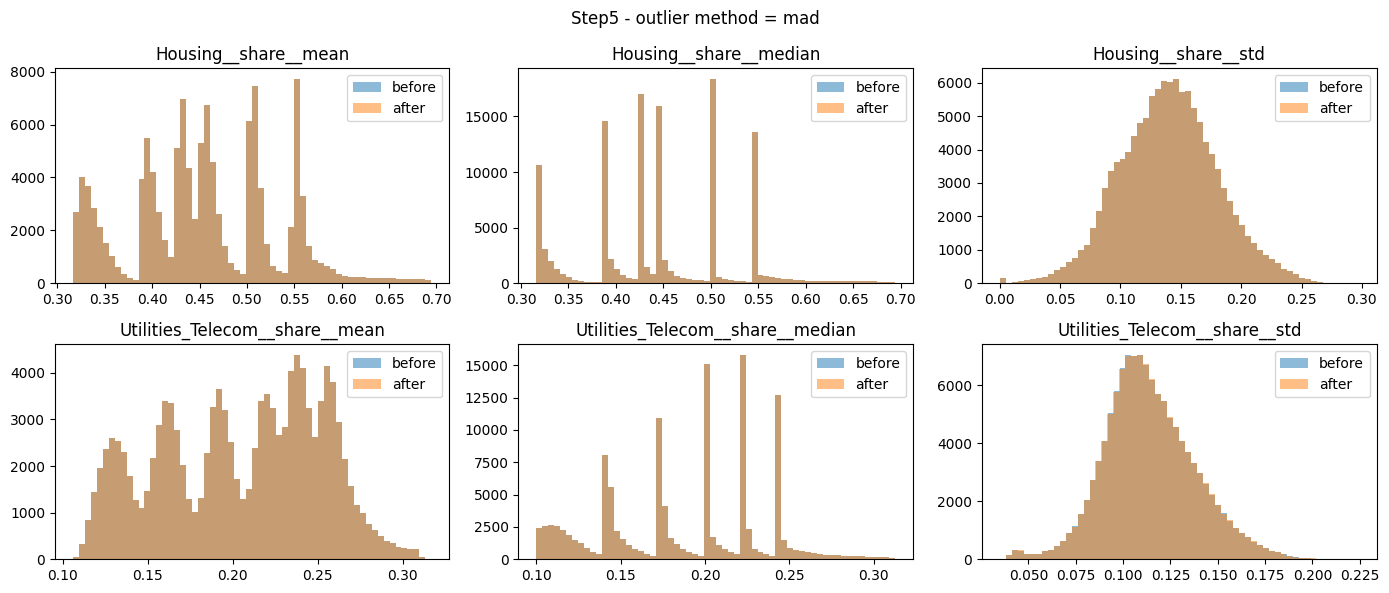

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


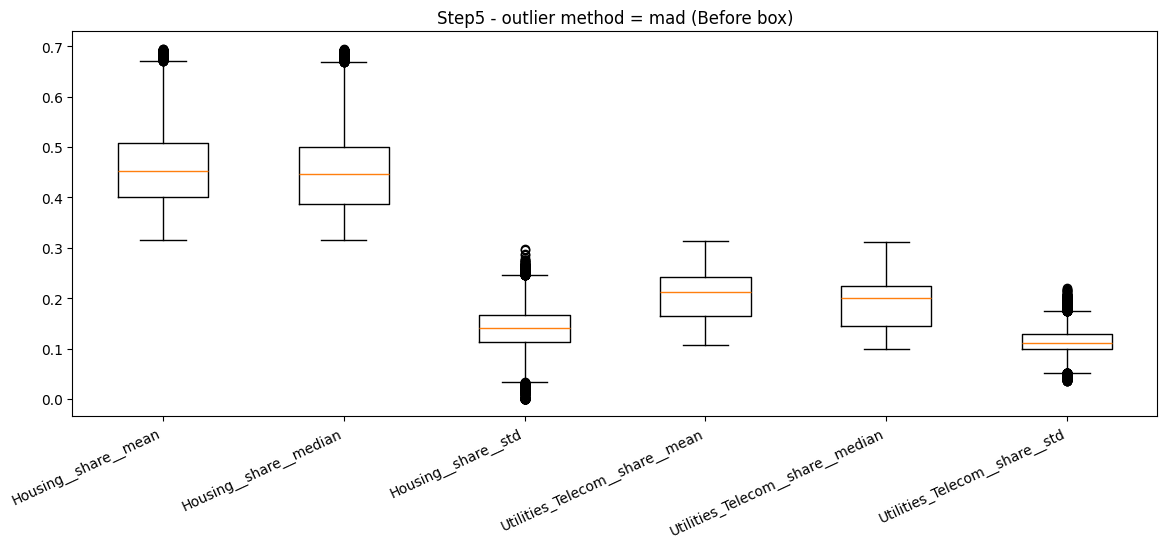

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


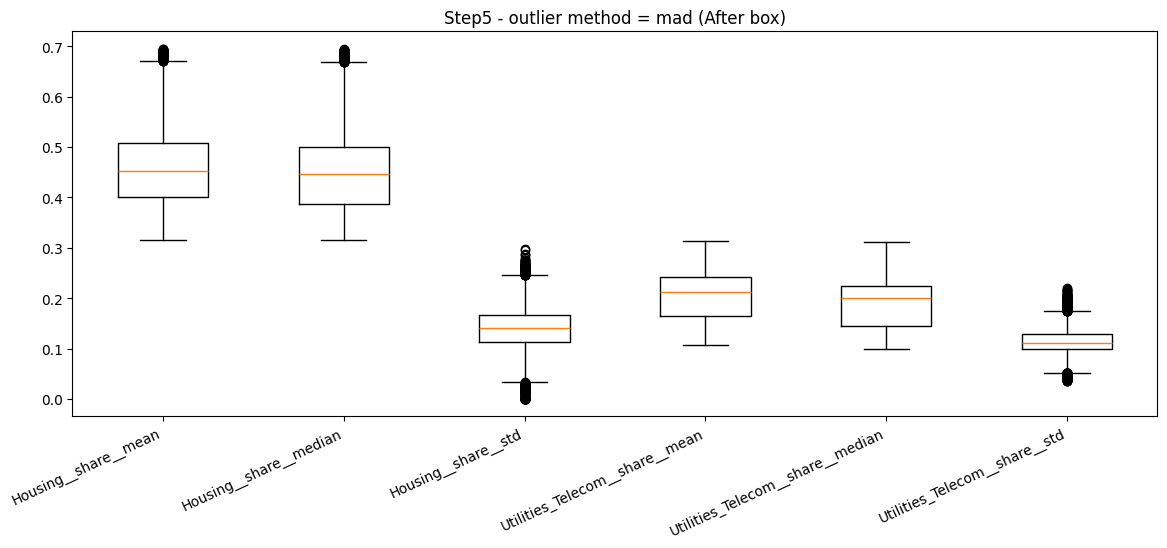

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step5 summary:


outlier_method       acc  macro_f1
0           none  0.999833  0.999833
2            mad  0.999708  0.999707
1            iqr  0.999625  0.999622


Step5 BEST = none | acc=0.9998 macro_f1=0.9998


In [10]:
# compare IQR clipping vs MAD clipping, keep best.

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

def fit_iqr_bounds(Xdf, k=1.5):
    q1 = Xdf.quantile(0.25)
    q3 = Xdf.quantile(0.75)
    iqr = (q3 - q1).replace(0, 1e-9)
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return lo, hi

def fit_mad_bounds(Xdf, z=5.0):
    med = Xdf.median()
    mad = (Xdf - med).abs().median().replace(0, 1e-9)
    lo = med - (z * mad / 0.6745)
    hi = med + (z * mad / 0.6745)
    return lo, hi

def clip_apply(Xdf, lo, hi):
    return Xdf.clip(lower=lo, upper=hi, axis=1)

methods = ["none","iqr","mad"]
plot_feats = list(X.columns[:6])
X_plot = X[plot_feats].copy()

results = []
best = {"method": None, "X": None, "mf1": -1, "acc": -1, "bounds": None}

pbar = tqdm(methods, desc="Step5 outlier compare")
for m in pbar:
    if m == "none":
        Xm = X.copy()
        Xp = X_plot.copy()
        bounds = None
    elif m == "iqr":
        lo, hi = fit_iqr_bounds(X)
        Xm = clip_apply(X, lo, hi)
        lo2, hi2 = fit_iqr_bounds(X_plot)
        Xp = clip_apply(X_plot, lo2, hi2)
        bounds = ("iqr", lo, hi)
    else:
        lo, hi = fit_mad_bounds(X)
        Xm = clip_apply(X, lo, hi)
        lo2, hi2 = fit_mad_bounds(X_plot)
        Xp = clip_apply(X_plot, lo2, hi2)
        bounds = ("mad", lo, hi)

    plot_before_after_df(X_plot, Xp, f"Step5 - outlier method = {m}")

    acc, mf1 = quick_eval_lr(
        Xm, y, groups,
        scaler_name="standard",
        penalty_mode=STATE["reg_mode"],
        C=STATE["reg_params"].get("C",1.0),
        l1_ratio=STATE["reg_params"].get("l1_ratio",0.5)
    )
    results.append((m, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"method": m, "X": Xm, "mf1": mf1, "acc": acc, "bounds": bounds})

pbar.close()

res_df = pd.DataFrame(results, columns=["outlier_method","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep5 summary:")
display(res_df)

print(f"\nStep5 BEST = {best['method']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["outlier_method"] = best["method"]
STATE["outlier_bounds"] = best["bounds"]  # save bounds for backend reproducibility
STATE["X_current"] = best["X"]


Feature Selection (Heatmap, VIF, confusion entropy, feature importance) with eval and pick best

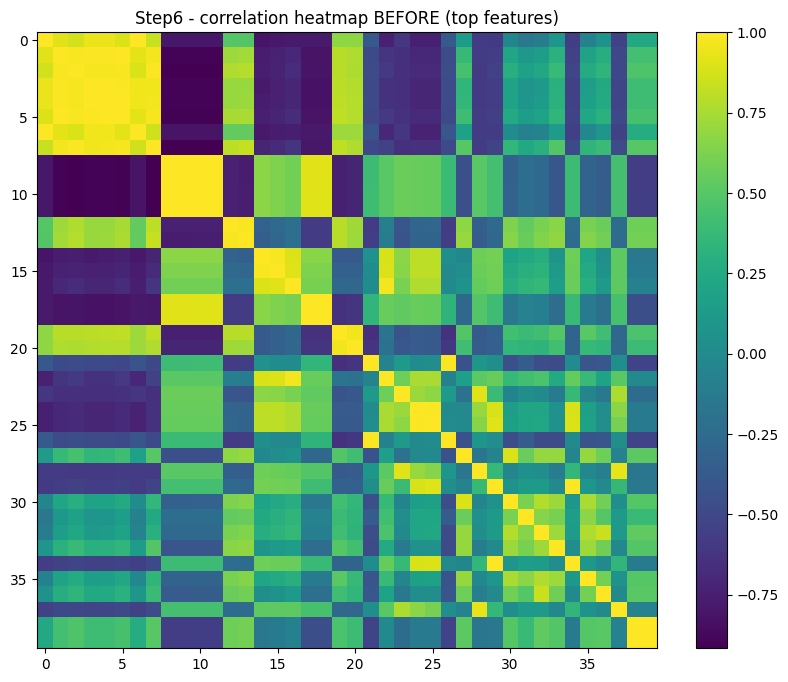

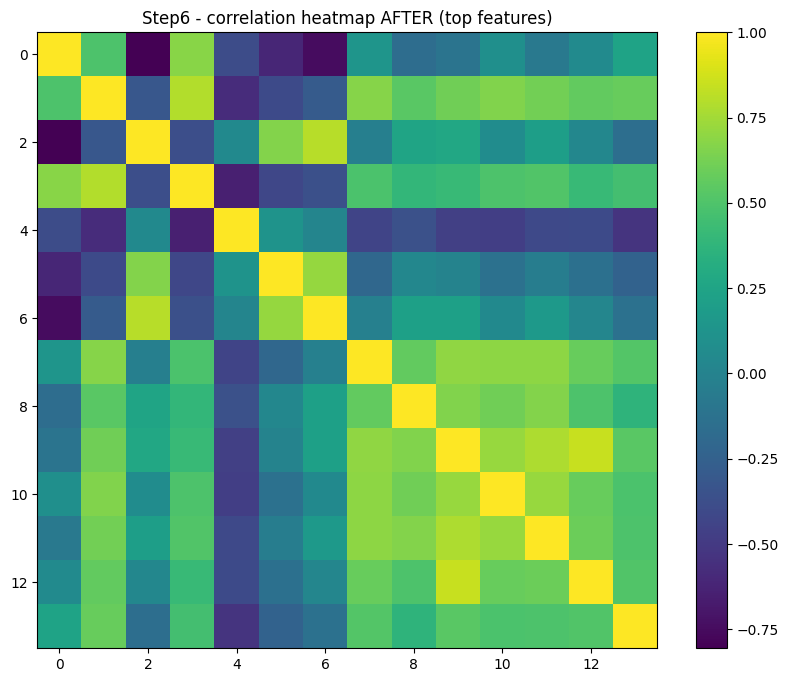

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Heatmap-drop eval: acc=0.9922 macro_f1=0.9923


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Top VIFs (secondary check):


feature          vif
24              Debt_Payments__share__mean          inf
23                          DebtRate__mean          inf
16                 Auto_Costs__share__mean  1488.229360
9              Healthcare_OOP__share__mean  1410.626246
15               Auto_Costs__share__median   650.088079
3               Insurance_All__share__mean   492.828699
14           Healthcare_OOP__share__median   465.430529
1   Transportation_Variable__share__median   404.193452
20                  Auto_Costs__share__std   290.139224
12              Healthcare_OOP__share__std   225.351986
13               Debt_Payments__share__std   219.542359
11               Insurance_All__share__std   139.428371
17                  DiscretionaryRate__std   139.046245
21                        Pets__share__std   137.943165
0      Groceries_FoodAtHome__share__median   110.582508

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



VIF-drop eval: acc=0.6399 macro_f1=0.6377


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Entropy-wrapper baseline: score=0.3774 f1=0.6377 ent=1.0413 (features=13)


Entropy-wrapper pruning: 0it [00:00, ?it/s]


Entropy-wrapper final feature count: 13
last drops: []


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Entropy-selected eval: acc=0.6399 macro_f1=0.6377


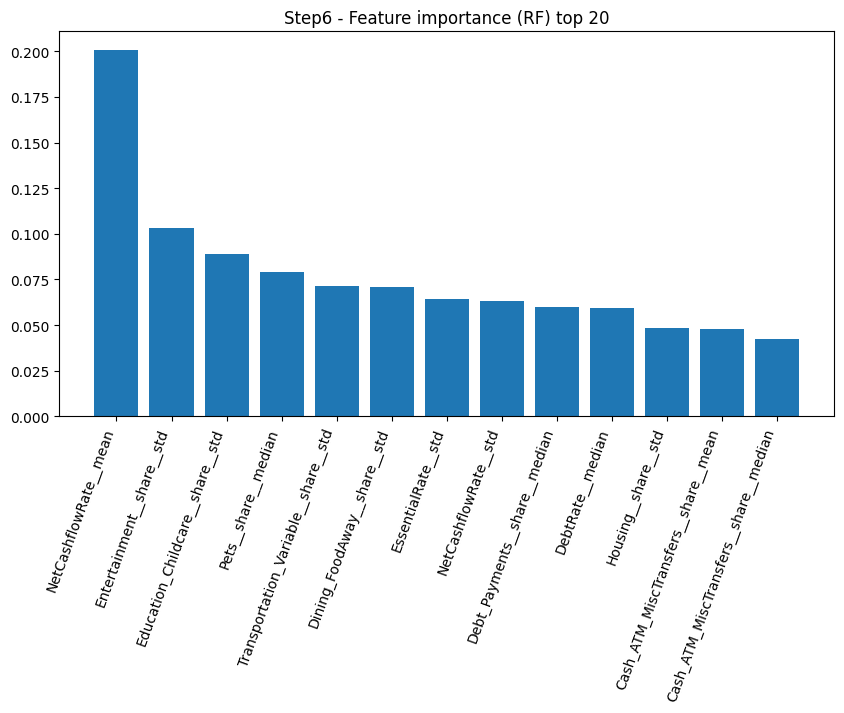


Step6 BEST feature set = heatmap_drop | acc=0.9922 macro_f1=0.9923 | features=37


In [11]:
# must include: heatmap, VIF, confusion entropy, and feature importance.
# done in stages and kept the best feature set.

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

# optionally cap rows for heavy stuff
df_people = STATE["df_people"]
if FAST_MODE and len(df_people) > PEOPLE_CAP_FAST:
    idx = df_people.sample(n=PEOPLE_CAP_FAST, random_state=RANDOM_SEED).index
    X_fs = X.loc[idx].copy()
    y_fs = y[idx]
    groups_fs = groups[idx]
else:
    X_fs, y_fs, groups_fs = X.copy(), y.copy(), groups.copy()

# drop exact-constant columns (helps MI/VIF stability)
stds = X_fs.std(axis=0)
const_cols = stds[stds < 1e-12].index.tolist()
if const_cols:
    X = X.drop(columns=const_cols, errors="ignore")
    X_fs = X_fs.drop(columns=const_cols, errors="ignore")

# ---- (A) Heatmap correlation ----
# show only top 40 MI features for heatmap
mi = mutual_info_classif(X_fs.values, y_fs, random_state=RANDOM_SEED)
mi_rank = pd.Series(mi, index=X_fs.columns).sort_values(ascending=False)
top_heat = list(mi_rank.head(min(40, len(mi_rank))).index)

corr_before = X_fs[top_heat].corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr_before.values, aspect="auto")
plt.title("Step6 - correlation heatmap BEFORE (top features)")
plt.colorbar()
plt.show()

to_drop = set()
th = 0.85
for i in range(len(top_heat)):
    for j in range(i+1, len(top_heat)):
        if abs(corr_before.iloc[i, j]) > th:
            # drop the lower-MI feature
            fi, fj = top_heat[i], top_heat[j]
            drop = fj if mi_rank[fi] >= mi_rank[fj] else fi
            to_drop.add(drop)

X_h = X.drop(columns=list(to_drop), errors="ignore")

corr_after = X_fs[[c for c in top_heat if c in X_h.columns]].corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr_after.values, aspect="auto")
plt.title("Step6 - correlation heatmap AFTER (top features)")
plt.colorbar()
plt.show()

acc_h, mf1_h = quick_eval_lr(X_h, y, groups, scaler_name="standard", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
print(f"\nHeatmap-drop eval: acc={acc_h:.4f} macro_f1={mf1_h:.4f}")

# ---- (B) VIF secondary (run on reduced with only for top 25 to keep it fast) ----
def compute_vif(Xdf):
    Xv = Xdf.values.astype(np.float64)
    out = []
    for i in range(Xv.shape[1]):
        out.append((Xdf.columns[i], variance_inflation_factor(Xv, i)))
    return pd.DataFrame(out, columns=["feature","vif"]).sort_values("vif", ascending=False)

mi_rank_h = mi_rank[mi_rank.index.isin(X_h.columns)]
vif_base_cols = list(mi_rank_h.head(min(25, len(X_h.columns))).index)
vif_in = X_h[vif_base_cols].replace([np.inf, -np.inf], np.nan).dropna()

vif_df = compute_vif(vif_in)
print("\nTop VIFs (secondary check):")
display(vif_df.head(15))

# optional VIF rule
vif_drop = list(vif_df[vif_df["vif"] > 12]["feature"].values)
X_v = X_h.drop(columns=vif_drop, errors="ignore")
acc_v, mf1_v = quick_eval_lr(X_v, y, groups, scaler_name="standard", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
print(f"\nVIF-drop eval: acc={acc_v:.4f} macro_f1={mf1_v:.4f}")

# ---- (C) Confusion-matrix entropy (main) ----
def confusion_entropy(cm):
    cm = cm.astype(np.float64)
    rs = cm.sum(axis=1, keepdims=True)
    rs[rs == 0] = 1.0
    p = cm / rs
    p = np.clip(p, 1e-12, 1.0)
    ent = -(p * np.log(p)).sum(axis=1)
    return float(ent.mean())

def score_features(Xdf, y, groups, feature_list, lambda_ent=0.25):
    Xs = Xdf[feature_list]
    tr_idx, te_idx = split_by_group(Xs, y, groups)

    Xtr = Xs.iloc[tr_idx].values
    Xte = Xs.iloc[te_idx].values
    ytr = y[tr_idx]
    yte = y[te_idx]

    sc = StandardScaler()
    sc.fit(Xtr)
    Xtr = sc.transform(Xtr)
    Xte = sc.transform(Xte)

    mode = STATE["reg_mode"]
    params = STATE["reg_params"]
    model = _build_lr(mode, C=params.get("C",1.0), l1_ratio=params.get("l1_ratio",0.5))

    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    mf1 = f1_score(yte, pred, average="macro")
    cm = confusion_matrix(yte, pred, labels=list(range(6)))
    ent = confusion_entropy(cm)
    score = float(mf1 - lambda_ent * ent)
    return score, mf1, ent

# candidate pool = top K MI (on X_v)
Xv_fs = X_fs[[c for c in X_v.columns if c in X_fs.columns]]
mi2 = mutual_info_classif(Xv_fs.values, y_fs, random_state=RANDOM_SEED)
mi2_rank = pd.Series(mi2, index=Xv_fs.columns).sort_values(ascending=False)

K = min(35 if FAST_MODE else 60, len(mi2_rank))
selected = list(mi2_rank.head(K).index)

base_score, base_f1, base_ent = score_features(X_v, y, groups, selected)
print(f"\nEntropy-wrapper baseline: score={base_score:.4f} f1={base_f1:.4f} ent={base_ent:.4f} (features={len(selected)})")

improved = True
hist = []
pbar = tqdm(total=max(0, len(selected)-15), desc="Entropy-wrapper pruning")
while improved and len(selected) > 15:
    improved = False
    best_local = (base_score, None, None, None)

    for f in selected:
        trial = [x for x in selected if x != f]
        sc, f1v, entv = score_features(X_v, y, groups, trial)
        if sc > best_local[0] + 1e-4:
            best_local = (sc, f, f1v, entv)

    if best_local[1] is not None:
        drop_f = best_local[1]
        selected.remove(drop_f)
        base_score, base_f1, base_ent = best_local[0], best_local[2], best_local[3]
        hist.append((drop_f, base_score, base_f1, base_ent, len(selected)))
        improved = True
        pbar.update(1)
        pbar.set_postfix({"score": f"{base_score:.3f}", "f1": f"{base_f1:.3f}", "ent": f"{base_ent:.3f}", "k": len(selected)})

pbar.close()

print("\nEntropy-wrapper final feature count:", len(selected))
print("last drops:", hist[-5:])

X_e = X_v[selected].copy()
acc_e, mf1_e = quick_eval_lr(X_e, y, groups, scaler_name="standard", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
print(f"\nEntropy-selected eval: acc={acc_e:.4f} macro_f1={mf1_e:.4f}")

# ---- (D) Feature importance (RF) ----
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1)
tr_idx, te_idx = split_by_group(X_e, y, groups)
rf.fit(X_e.iloc[tr_idx].values, y[tr_idx])
imp = pd.Series(rf.feature_importances_, index=X_e.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 5))
plt.bar(imp.index, imp.values)
plt.title("Step6 - Feature importance (RF) top 20")
plt.xticks(rotation=70, ha="right")
plt.show()

# pick best among heatmap, vif, entropy
cands = [
    ("heatmap_drop", X_h, mf1_h, acc_h),
    ("vif_drop", X_v, mf1_v, acc_v),
    ("entropy_selected", X_e, mf1_e, acc_e),
]
best = sorted(cands, key=lambda x: x[2], reverse=True)[0]
print(f"\nStep6 BEST feature set = {best[0]} | acc={best[3]:.4f} macro_f1={best[2]:.4f} | features={best[1].shape[1]}")

STATE["feature_select_method"] = best[0]
STATE["X_current"] = best[1]
STATE["feature_cols"] = list(best[1].columns)


Data Scaling (Z-score and more) with before/after plots, eval, and pick best

Step7 scaling compare:   0%|          | 0/4 [00:00<?, ?it/s]

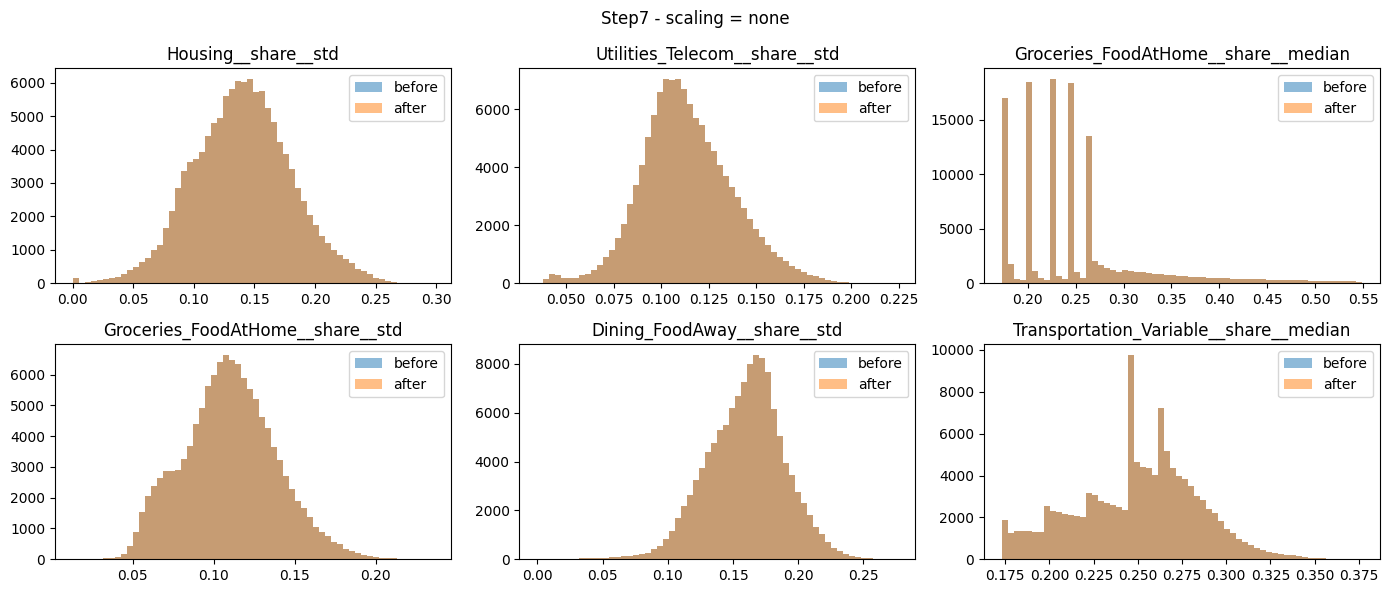

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


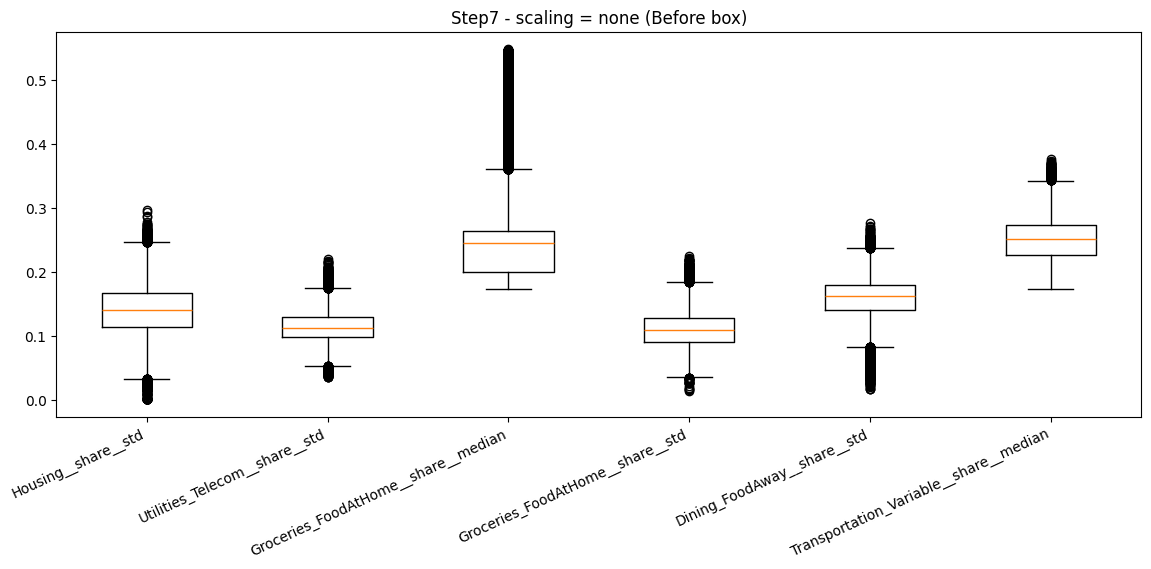

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


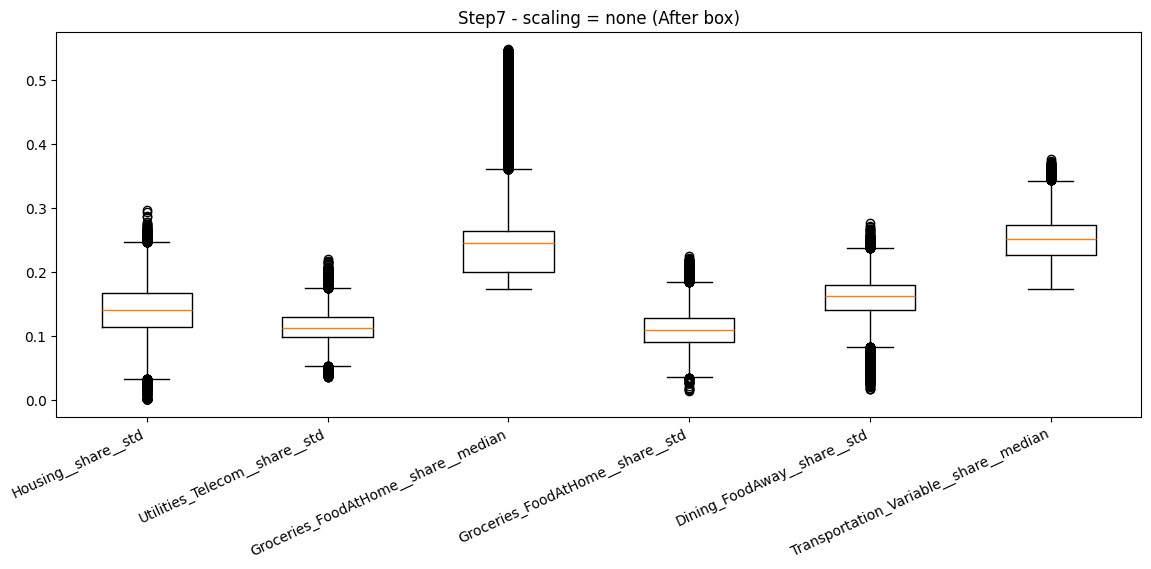

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


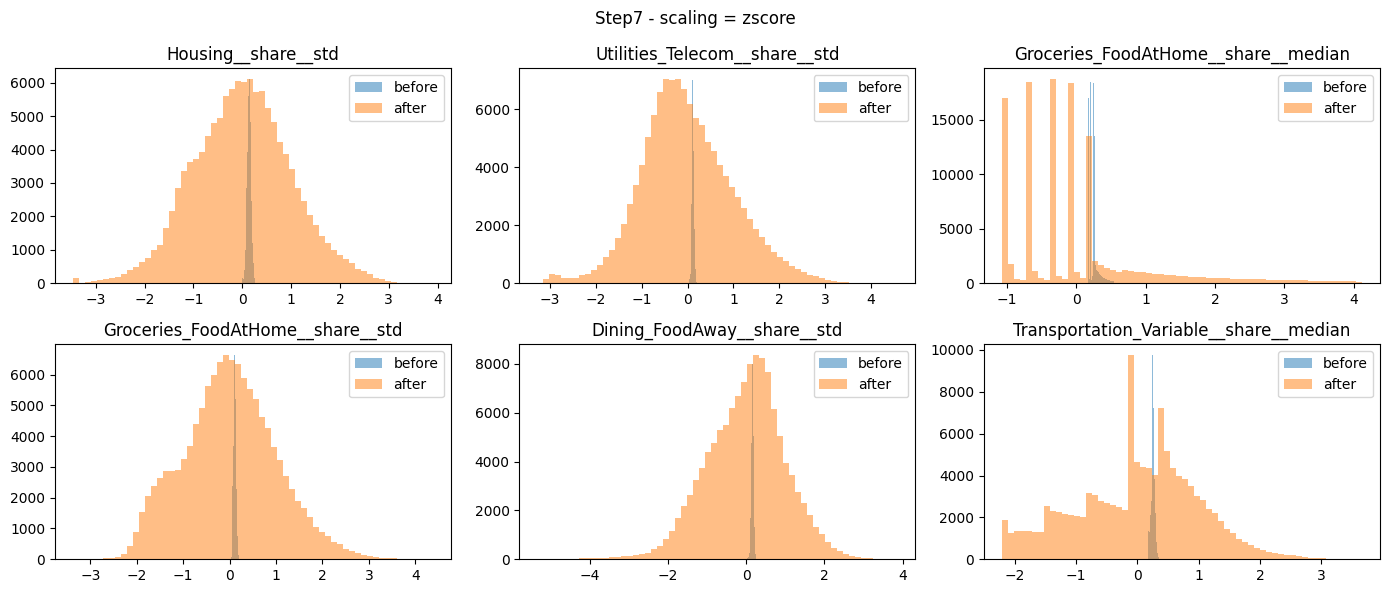

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


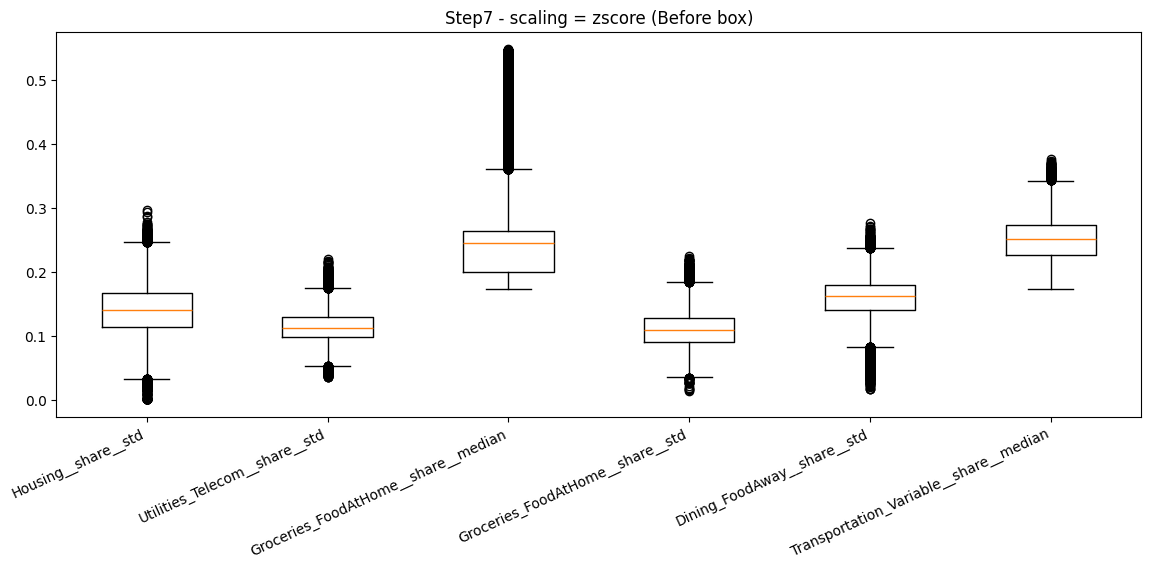

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


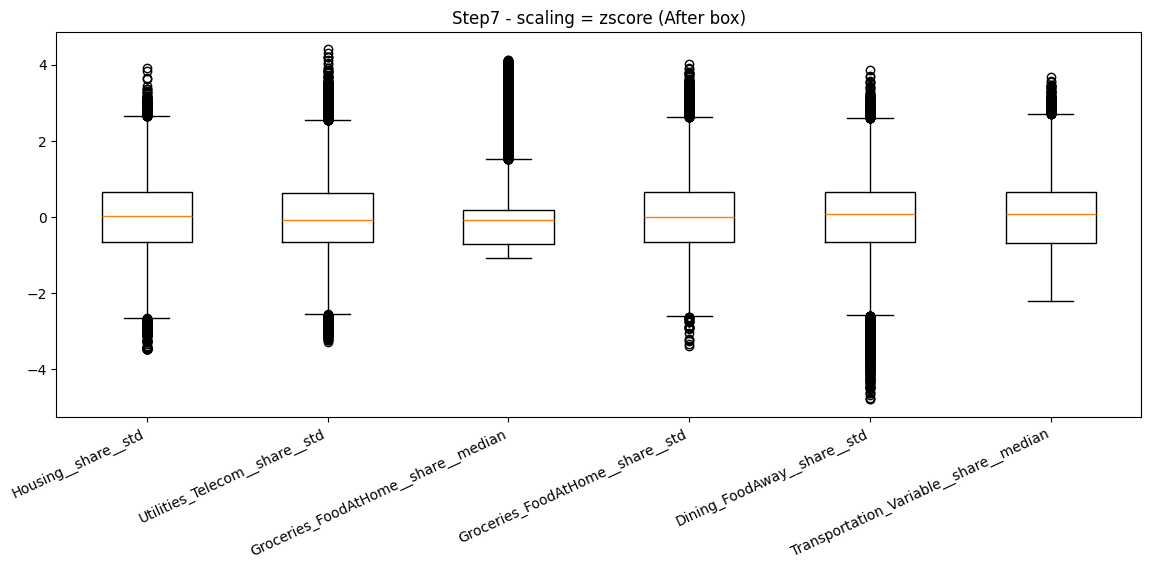

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


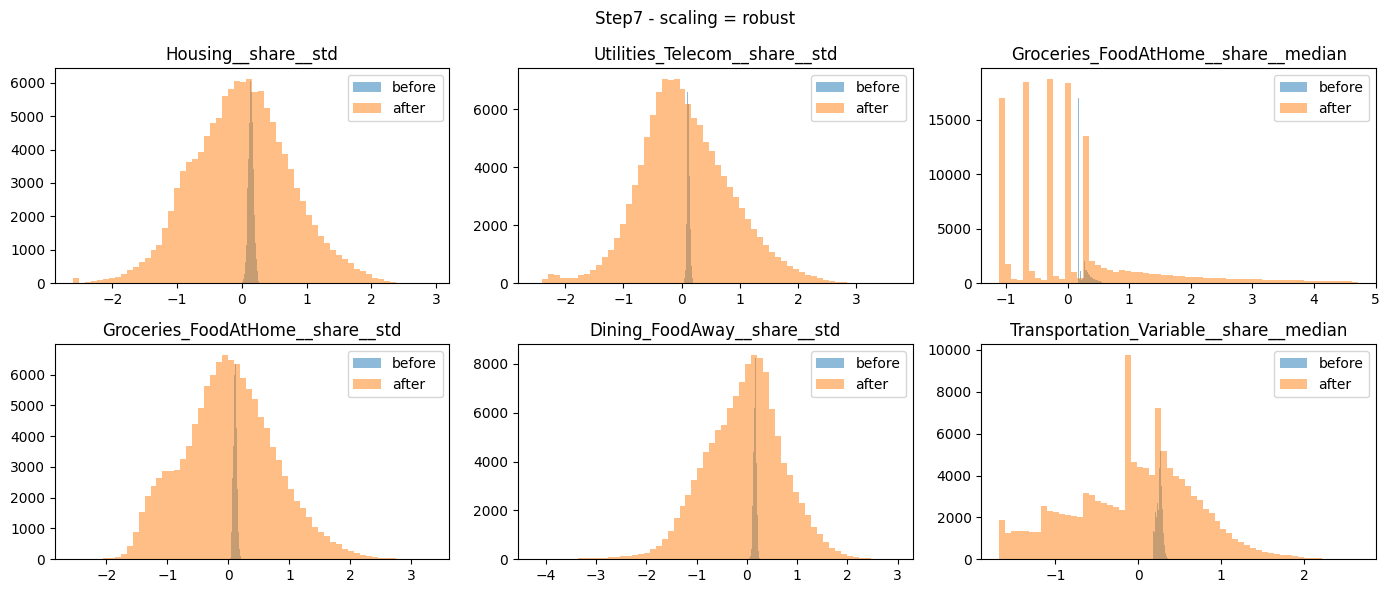

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


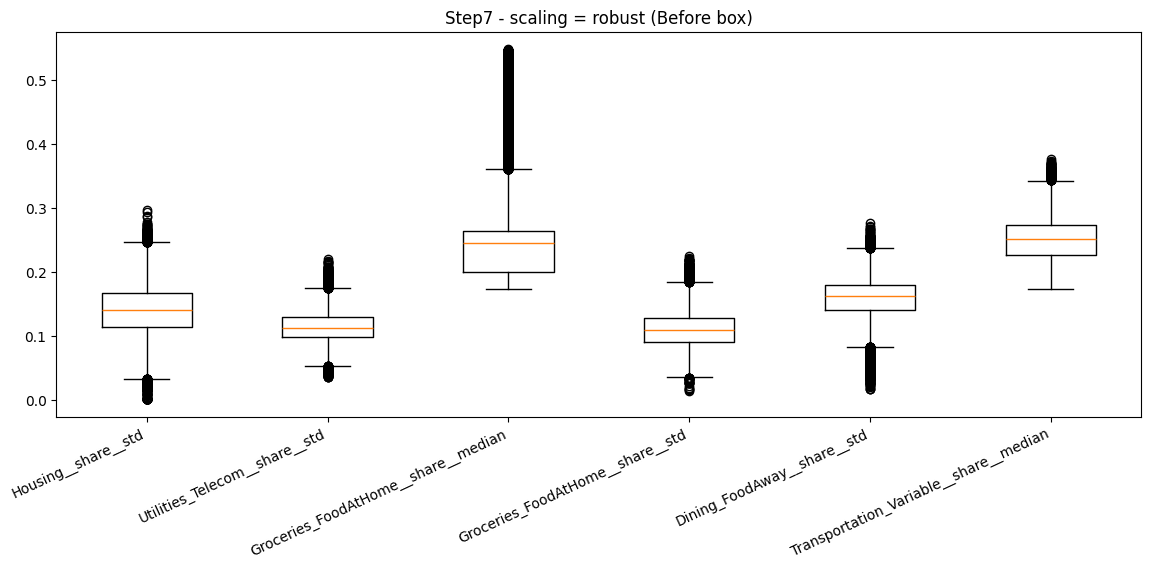

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


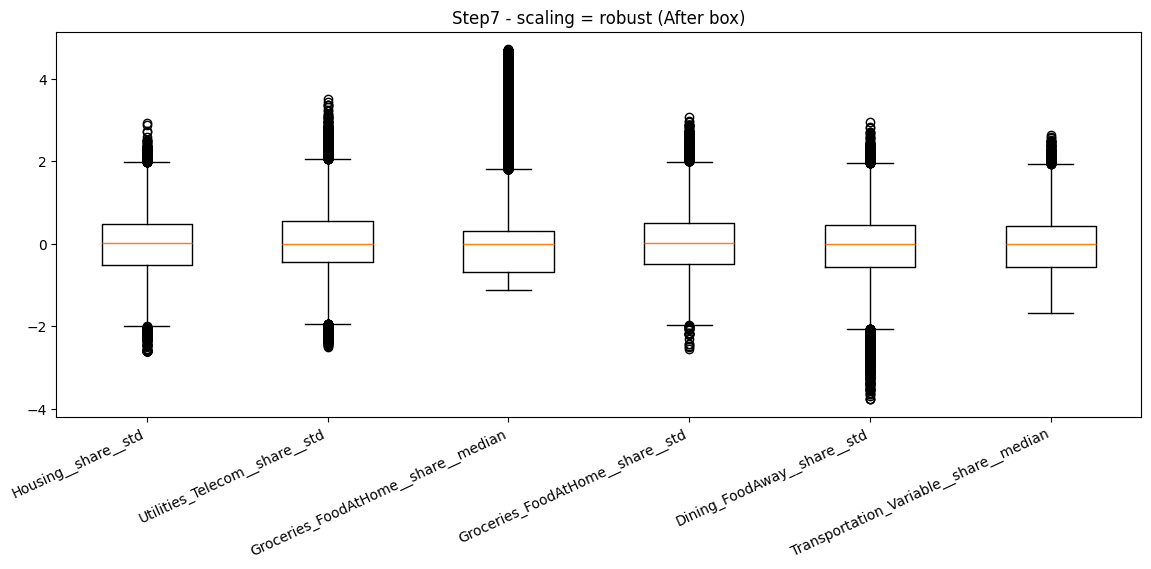

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


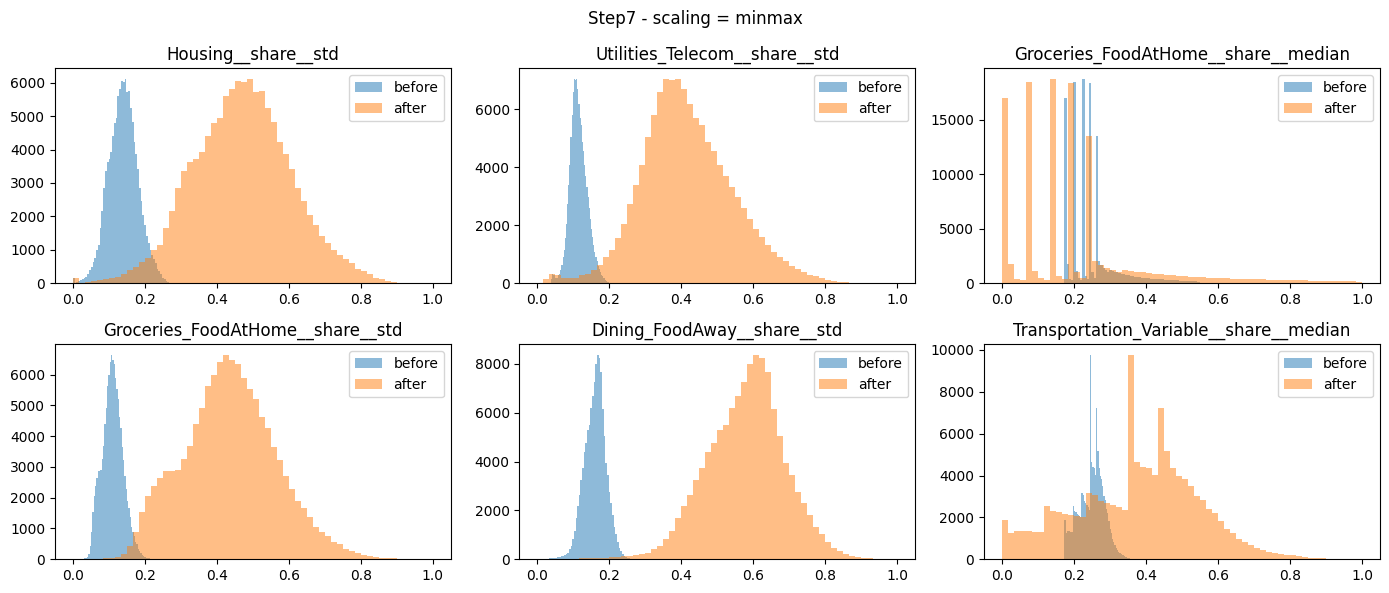

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


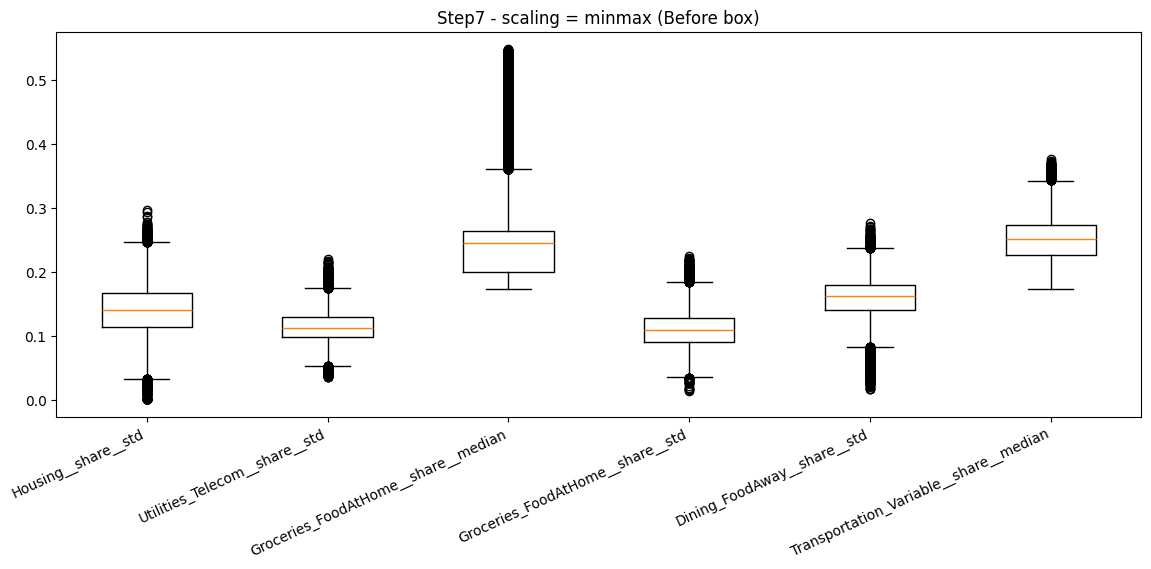

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


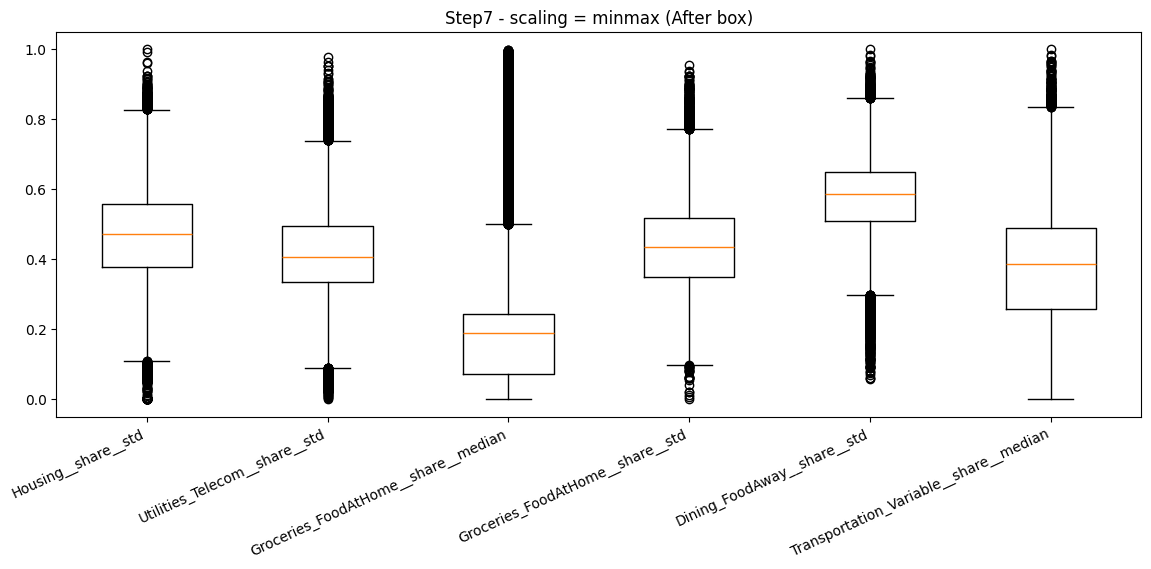

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step7 summary:


scaler       acc  macro_f1
2  robust  0.992708  0.992746
1  zscore  0.992083  0.992120
3  minmax  0.975667  0.975786
0    none  0.943042  0.943272


Step7 BEST = robust | acc=0.9927 macro_f1=0.9927


In [12]:
# compare scalers, show before/after plots, eval, keep best.

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

scalers = ["none", "zscore", "robust", "minmax"]

plot_feats = list(X.columns[:6])
X_plot = X[plot_feats].copy()

def apply_scaler_df(Xdf, scaler_name):
    if scaler_name == "none":
        return Xdf.copy(), None
    if scaler_name == "zscore":
        sc = StandardScaler()
    elif scaler_name == "robust":
        sc = RobustScaler()
    elif scaler_name == "minmax":
        sc = MinMaxScaler()
    else:
        raise ValueError(scaler_name)

    Xt = pd.DataFrame(sc.fit_transform(Xdf.values), columns=Xdf.columns, index=Xdf.index)
    return Xt, sc

results = []
best = {"scaler": None, "X": None, "mf1": -1, "acc": -1, "scaler_obj": None}

pbar = tqdm(scalers, desc="Step7 scaling compare")
for s in pbar:
    Xs, sc_obj = apply_scaler_df(X, s)
    Xp_after, _ = apply_scaler_df(X_plot, s)
    plot_before_after_df(X_plot, Xp_after, f"Step7 - scaling = {s}")

    # eval using LR (scaling affects LR the most)
    # NOTE: since already scaled in Xs, set scaler_name="none" in eval
    acc, mf1 = quick_eval_lr(Xs, y, groups, scaler_name="none", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
    results.append((s, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"scaler": s, "X": Xs, "mf1": mf1, "acc": acc, "scaler_obj": sc_obj})

pbar.close()

res_df = pd.DataFrame(results, columns=["scaler","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep7 summary:")
display(res_df)

print(f"\nStep7 BEST = {best['scaler']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["scaler_method"] = best["scaler"]
STATE["scaler_obj"] = best["scaler_obj"]
STATE["X_current"] = best["X"]


Standardization with before/after plots, eval, and pick best

Step8 standardization compare:   0%|          | 0/3 [00:00<?, ?it/s]

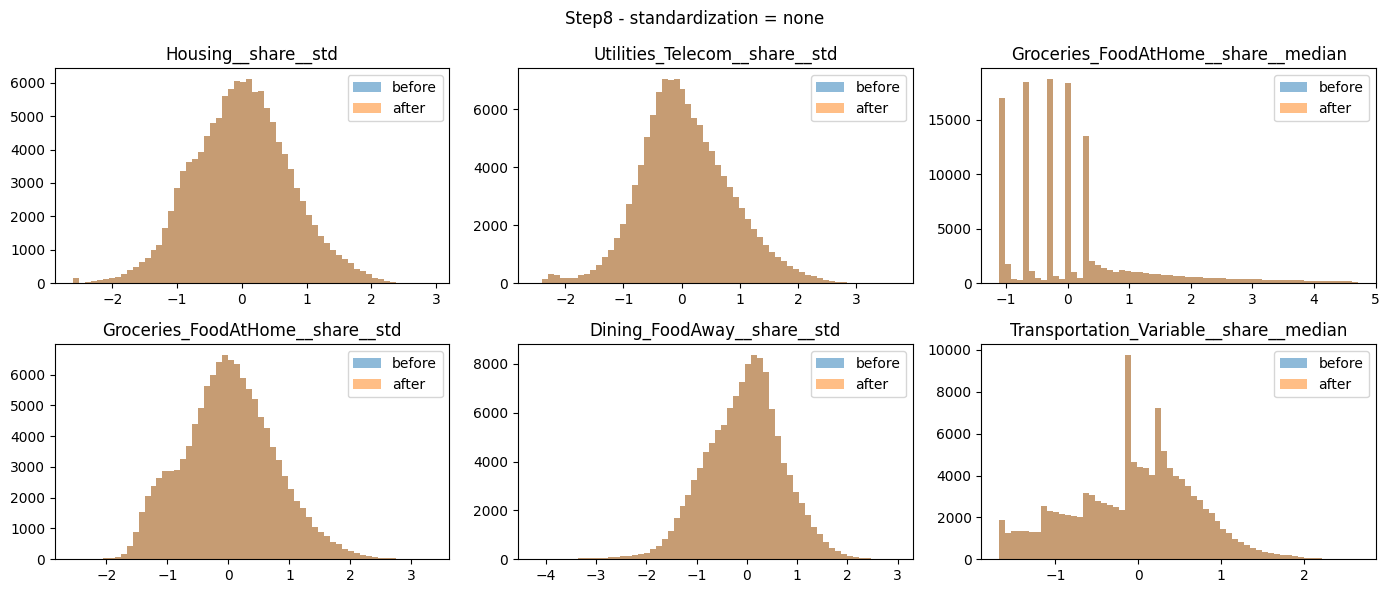

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


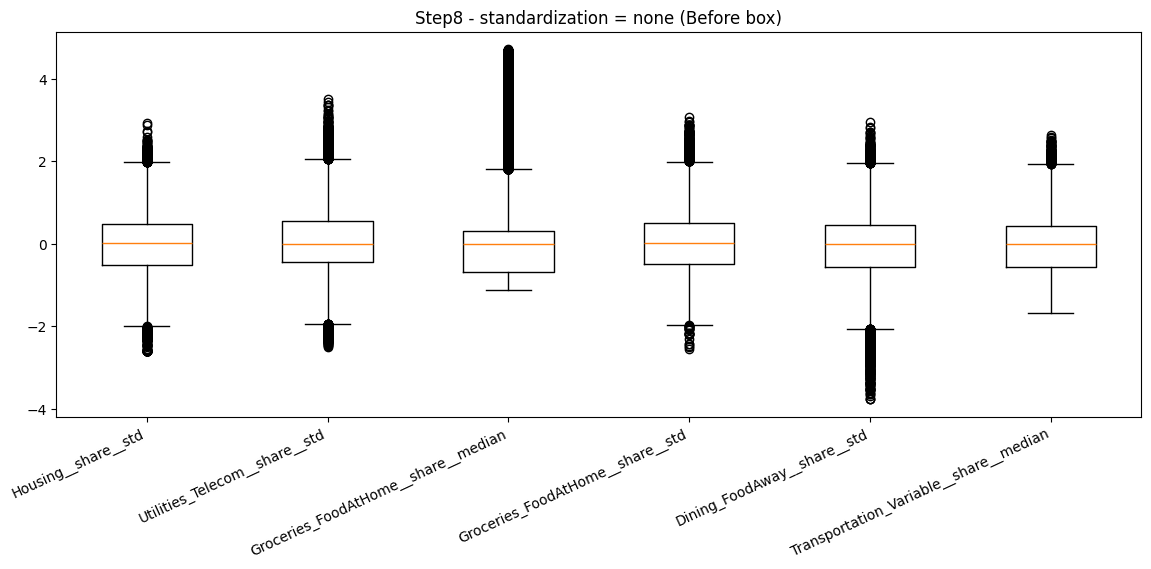

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


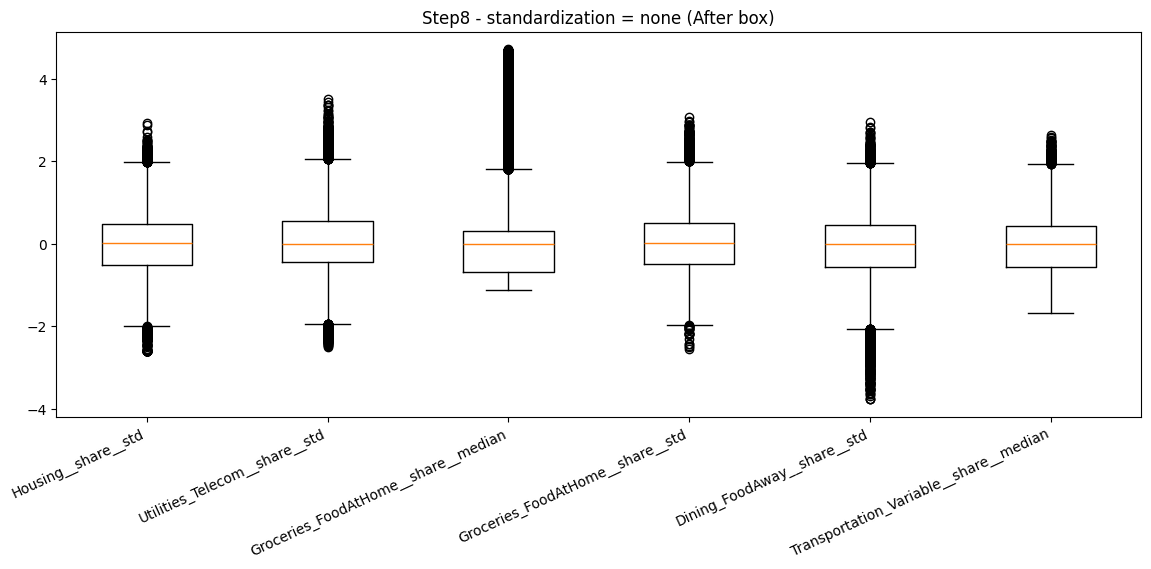

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


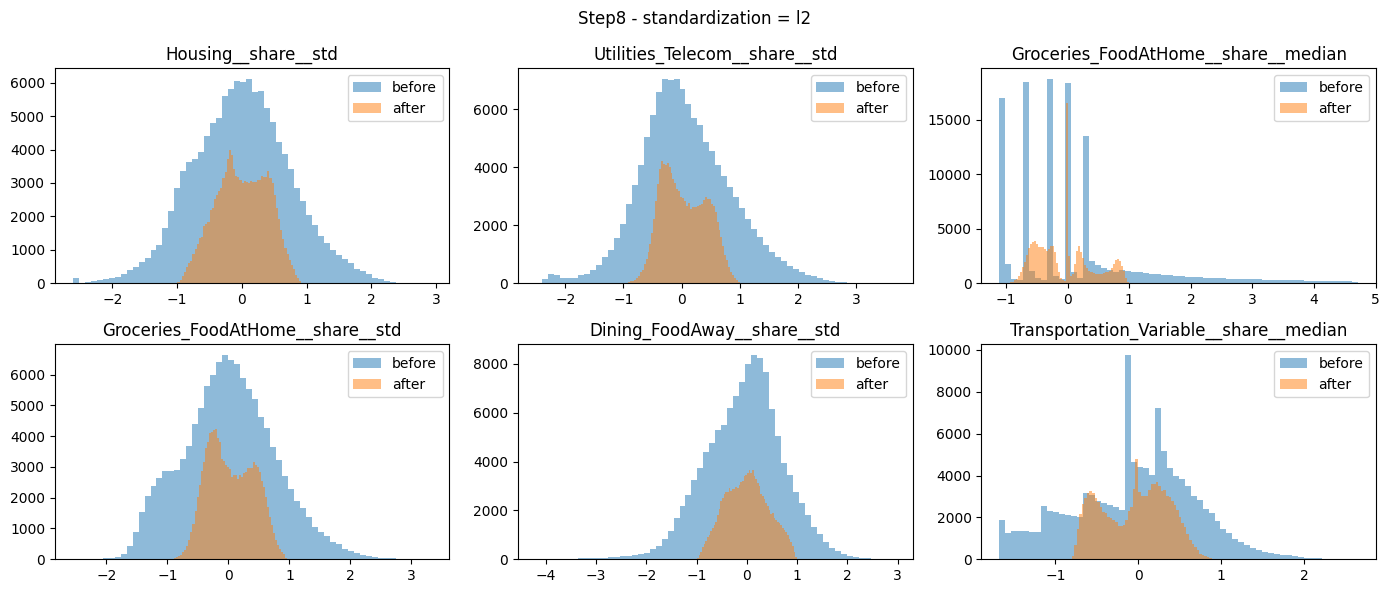

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


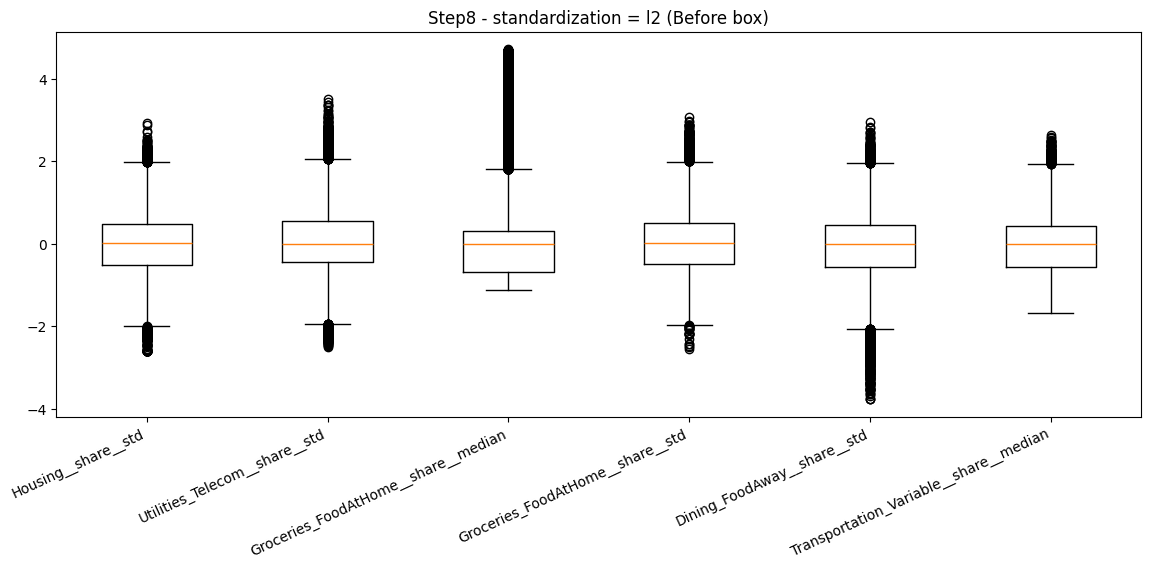

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


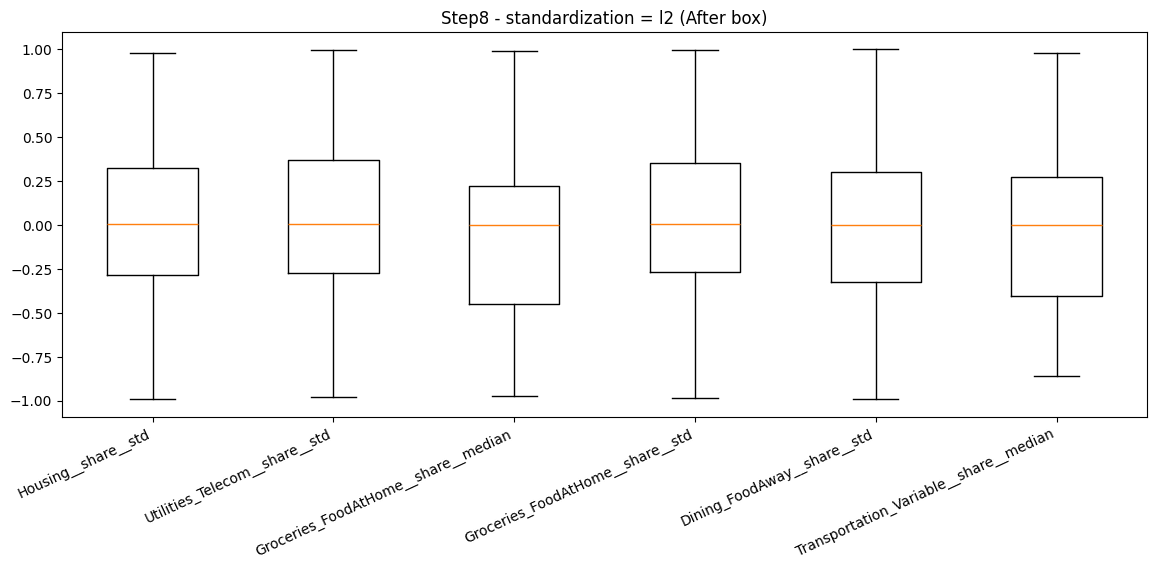

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


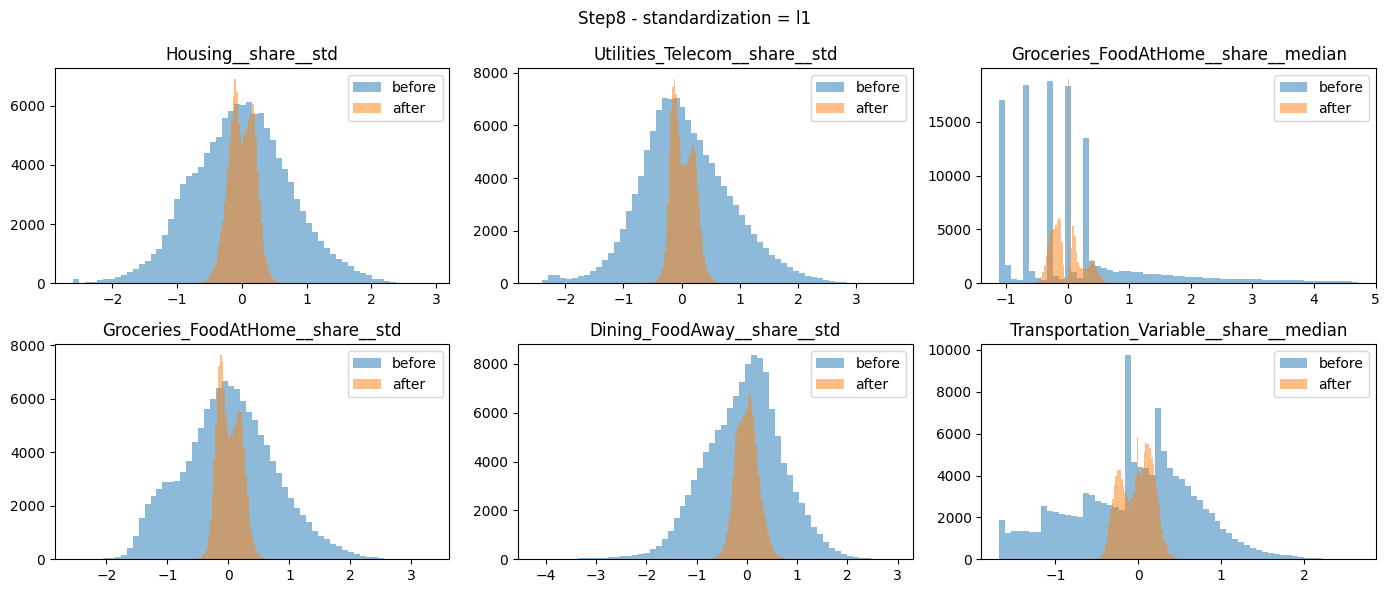

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


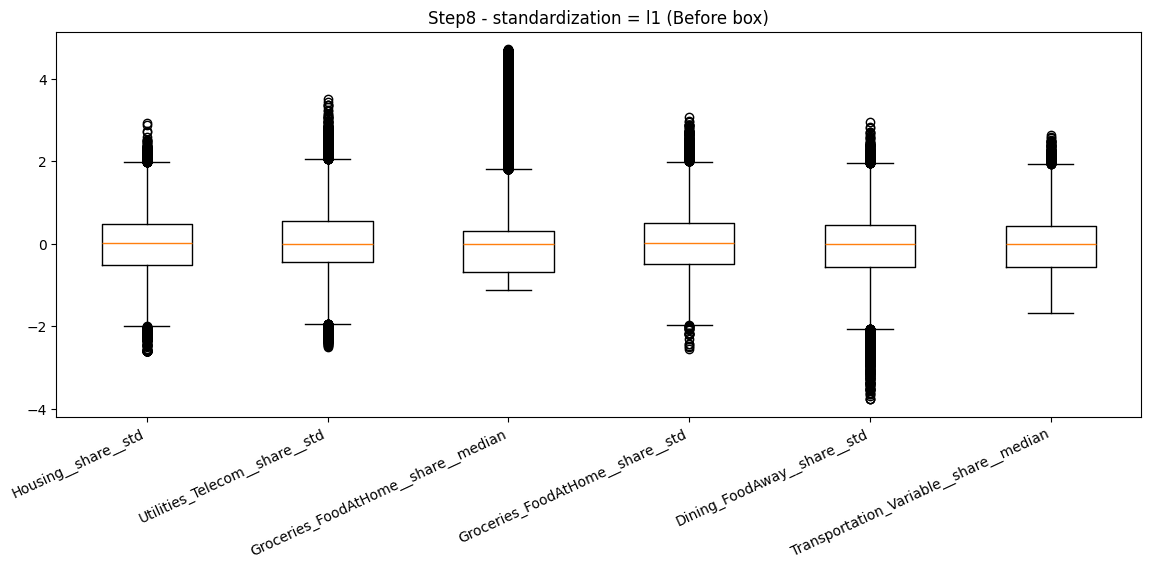

/tmp/ipython-input-1898932191.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


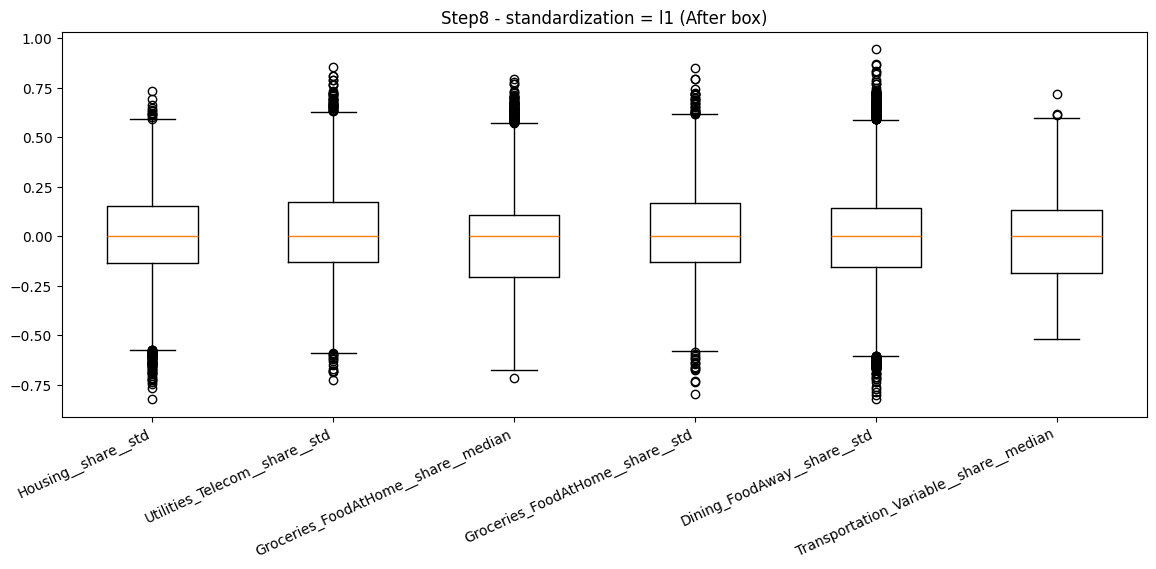

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step8 summary:


standardization       acc  macro_f1
0            none  0.992708  0.992746
1              l2  0.966458  0.966387
2              l1  0.920958  0.921226


Step8 BEST = none | acc=0.9927 macro_f1=0.9927


In [13]:
# i treat this as row-wise normalization: L1 vs L2 vs none.
# scaling was per-feature above; this is per-row standardization.

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

methods = ["none", "l2", "l1"]
plot_feats = list(X.columns[:6])
X_plot = X[plot_feats].copy()

def apply_row_norm(Xdf, mode):
    if mode == "none":
        return Xdf.copy(), None
    norm = Normalizer(norm=mode)
    Xt = pd.DataFrame(norm.fit_transform(Xdf.values), columns=Xdf.columns, index=Xdf.index)
    return Xt, norm

results = []
best = {"mode": None, "X": None, "mf1": -1, "acc": -1, "obj": None}

pbar = tqdm(methods, desc="Step8 standardization compare")
for m in pbar:
    Xm, obj = apply_row_norm(X, m)
    Xp_after, _ = apply_row_norm(X_plot, m)
    plot_before_after_df(X_plot, Xp_after, f"Step8 - standardization = {m}")

    acc, mf1 = quick_eval_lr(Xm, y, groups, scaler_name="none", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
    results.append((m, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"mode": m, "X": Xm, "mf1": mf1, "acc": acc, "obj": obj})

pbar.close()

res_df = pd.DataFrame(results, columns=["standardization","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep8 summary:")
display(res_df)

print(f"\nStep8 BEST = {best['mode']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["standardization_method"] = best["mode"]
STATE["standardization_obj"] = best["obj"]
STATE["X_current"] = best["X"]


Data Sampling (SMOTE, SMOTEENN, and more) with eval and pick best

In [14]:
# NOTE: synthetic clusters should be balanced. so sampling often wont help.
# but still compare none / SMOTE / SMOTEENN / undersample.

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

# sample only on training split (never touch test)
tr_idx, te_idx = split_by_group(X, y, groups)
Xtr = X.iloc[tr_idx].values
Xte = X.iloc[te_idx].values
ytr = y[tr_idx]
yte = y[te_idx]

samplers = [
    ("none", None),
    ("SMOTE", SMOTE(random_state=RANDOM_SEED)),
    ("SMOTEENN", SMOTEENN(random_state=RANDOM_SEED)),
    ("UnderSample", RandomUnderSampler(random_state=RANDOM_SEED)),
]

results = []
best = {"name": None, "mf1": -1, "acc": -1, "sampler": None, "Xtr": None, "ytr": None}

pbar = tqdm(samplers, desc="Step9 sampling compare")
for name, sampler in pbar:
    if sampler is None:
        Xtr_s, ytr_s = Xtr, ytr
    else:
        Xtr_s, ytr_s = sampler.fit_resample(Xtr, ytr)

    # evaluation model for sampling stage: LR (fast)
    mode = STATE["reg_mode"]
    params = STATE["reg_params"]

    model = _build_lr(mode, C=params.get("C",1.0), l1_ratio=params.get("l1_ratio",0.5))
    model.fit(Xtr_s, ytr_s)
    pred = model.predict(Xte)

    acc = accuracy_score(yte, pred)
    mf1 = f1_score(yte, pred, average="macro")
    results.append((name, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"name": name, "mf1": mf1, "acc": acc, "sampler": sampler, "Xtr": Xtr_s, "ytr": ytr_s})

pbar.close()

res_df = pd.DataFrame(results, columns=["sampler","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep9 summary:")
display(res_df)

print(f"\nStep9 BEST = {best['name']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["sampling_method"] = best["name"]
STATE["sampler_obj"] = best["sampler"]
STATE["train_split"] = {"tr_idx": tr_idx, "te_idx": te_idx}
STATE["Xtr_final"] = best["Xtr"]
STATE["ytr_final"] = best["ytr"]
STATE["Xte_final"] = Xte
STATE["yte_final"] = yte


Step9 sampling compare:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi


Step9 summary:


sampler       acc  macro_f1
1        SMOTE  0.993000  0.993039
3  UnderSample  0.992958  0.992996
0         none  0.992708  0.992746
2     SMOTEENN  0.979708  0.979812


Step9 BEST = SMOTE | acc=0.9930 macro_f1=0.9930


Logistic Regression with progress and eval

Training LogisticRegression:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LR results: acc=0.9930 macro_f1=0.9930

              precision    recall  f1-score   support

           0      0.998     0.997     0.997      4082
           1      0.985     0.989     0.987      4010
           2      0.989     0.986     0.987      4109
           3      0.994     0.995     0.994      3939
           4      0.993     0.996     0.995      3958
           5      0.999     0.995     0.997      3902

    accuracy                          0.993     24000
   macro avg      0.993     0.993     0.993     24000
weighted avg      0.993     0.993     0.993     24000



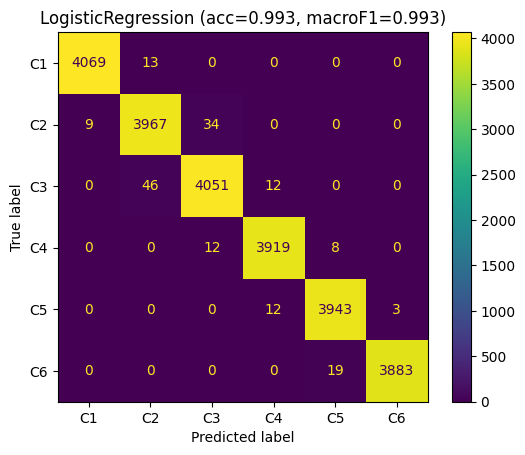

In [15]:
# train using the best preprocessing found and best sampling choice.

Xtr = STATE["Xtr_final"]
ytr = STATE["ytr_final"]
Xte = STATE["Xte_final"]
yte = STATE["yte_final"]

mode = STATE["reg_mode"]
params = STATE["reg_params"]

pbar = tqdm(total=1, desc="Training LogisticRegression")
lr = _build_lr(mode, C=params.get("C",1.0), l1_ratio=params.get("l1_ratio",0.5))
lr.fit(Xtr, ytr)
pbar.update(1)
pbar.close()

pred = lr.predict(Xte)
acc = accuracy_score(yte, pred)
mf1 = f1_score(yte, pred, average="macro")

print(f"\nLR results: acc={acc:.4f} macro_f1={mf1:.4f}\n")
print(classification_report(yte, pred, digits=3))

ConfusionMatrixDisplay.from_predictions(yte, pred, display_labels=[f"C{i+1}" for i in range(6)], values_format="d")
plt.title(f"LogisticRegression (acc={acc:.3f}, macroF1={mf1:.3f})")
plt.show()

STATE["model_lr"] = lr
STATE["metrics_lr"] = {"acc": acc, "macro_f1": mf1}


Random Forest and ExtraTrees with progress and eval

Training RandomForest:   0%|          | 0/1 [00:00<?, ?it/s]


RandomForest results: acc=0.9956 macro_f1=0.9956

              precision    recall  f1-score   support

           0      0.998     0.999     0.998      4082
           1      0.988     0.997     0.992      4010
           2      0.995     0.989     0.992      4109
           3      0.996     0.996     0.996      3939
           4      0.997     0.996     0.997      3958
           5      1.000     0.997     0.998      3902

    accuracy                          0.996     24000
   macro avg      0.996     0.996     0.996     24000
weighted avg      0.996     0.996     0.996     24000



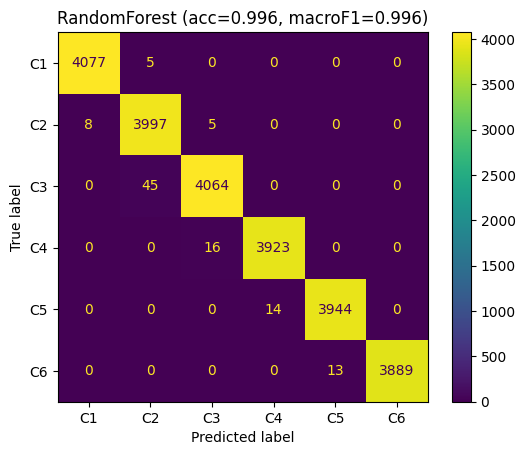

Training ExtraTrees:   0%|          | 0/1 [00:00<?, ?it/s]


ExtraTrees results: acc=0.9952 macro_f1=0.9952

              precision    recall  f1-score   support

           0      0.999     0.993     0.996      4082
           1      0.984     0.995     0.989      4010
           2      0.995     0.990     0.993      4109
           3      0.997     0.998     0.998      3939
           4      0.997     0.998     0.997      3958
           5      1.000     0.997     0.998      3902

    accuracy                          0.995     24000
   macro avg      0.995     0.995     0.995     24000
weighted avg      0.995     0.995     0.995     24000



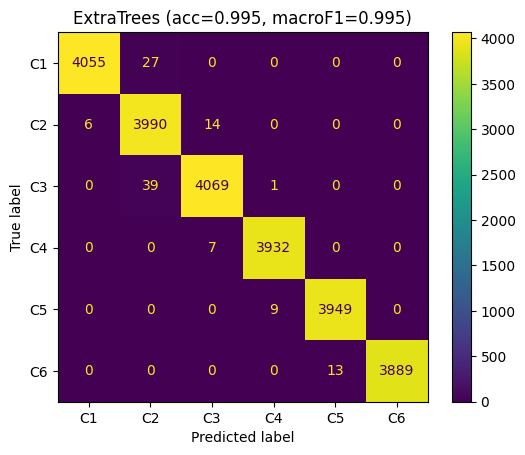

In [16]:
Xtr = STATE["Xtr_final"]
ytr = STATE["ytr_final"]
Xte = STATE["Xte_final"]
yte = STATE["yte_final"]

models = [
    ("RandomForest", RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=RANDOM_SEED)),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=700, n_jobs=-1, random_state=RANDOM_SEED)),
]

for name, model in models:
    pbar = tqdm(total=1, desc=f"Training {name}")
    model.fit(Xtr, ytr)
    pbar.update(1)
    pbar.close()

    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    mf1 = f1_score(yte, pred, average="macro")

    print(f"\n{name} results: acc={acc:.4f} macro_f1={mf1:.4f}\n")
    print(classification_report(yte, pred, digits=3))

    ConfusionMatrixDisplay.from_predictions(yte, pred, display_labels=[f"C{i+1}" for i in range(6)], values_format="d")
    plt.title(f"{name} (acc={acc:.3f}, macroF1={mf1:.3f})")
    plt.show()

    STATE[f"model_{name.lower()}"] = model
    STATE[f"metrics_{name.lower()}"] = {"acc": acc, "macro_f1": mf1}


XGBoost, MLP, and optional LinearSVC with progress and eval

Training XGBoost:   0%|          | 0/1 [00:00<?, ?it/s]


XGBoost results: acc=0.9960 macro_f1=0.9961

              precision    recall  f1-score   support

           0      0.998     0.998     0.998      4082
           1      0.989     0.995     0.992      4010
           2      0.996     0.991     0.993      4109
           3      0.997     0.997     0.997      3939
           4      0.997     0.997     0.997      3958
           5      1.000     0.997     0.999      3902

    accuracy                          0.996     24000
   macro avg      0.996     0.996     0.996     24000
weighted avg      0.996     0.996     0.996     24000



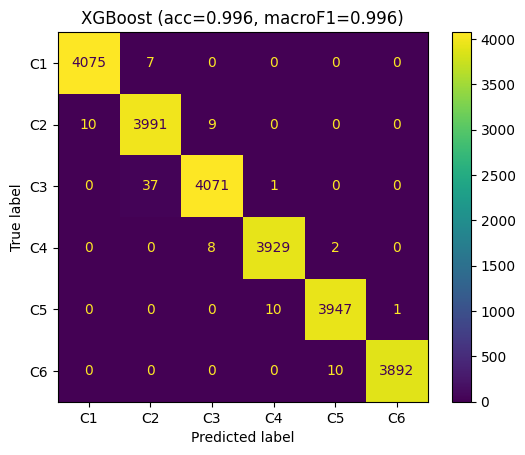

Training MLP:   0%|          | 0/1 [00:00<?, ?it/s]


MLP results: acc=0.9960 macro_f1=0.9960

              precision    recall  f1-score   support

           0      0.998     0.998     0.998      4082
           1      0.989     0.995     0.992      4010
           2      0.994     0.990     0.992      4109
           3      0.998     0.996     0.997      3939
           4      0.997     0.998     0.997      3958
           5      0.999     0.998     0.999      3902

    accuracy                          0.996     24000
   macro avg      0.996     0.996     0.996     24000
weighted avg      0.996     0.996     0.996     24000



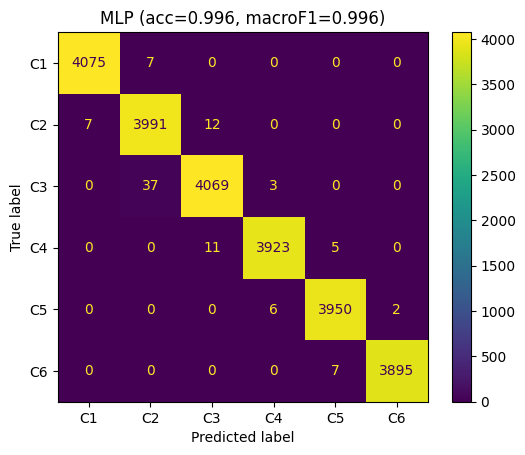

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

Xtr = STATE["Xtr_final"]
ytr = STATE["ytr_final"]
Xte = STATE["Xte_final"]
yte = STATE["yte_final"]

models = []

# XGBoost
models.append((
    "XGBoost",
    xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=6,
        n_estimators=900,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        eval_metric="mlogloss"
    )
))

# MLP (small)
models.append((
    "MLP",
    MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=200, random_state=RANDOM_SEED, early_stopping=True)
))

# Optional SVM (can be slower on big data)
if FAST_MODE:
    models.append((
        "LinearSVC",
        LinearSVC(random_state=RANDOM_SEED)
    ))

for name, model in models:
    pbar = tqdm(total=1, desc=f"Training {name}")
    if name == "XGBoost":
        model.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    else:
        model.fit(Xtr, ytr)
    pbar.update(1)
    pbar.close()

    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    mf1 = f1_score(yte, pred, average="macro")

    print(f"\n{name} results: acc={acc:.4f} macro_f1={mf1:.4f}\n")
    print(classification_report(yte, pred, digits=3))

    ConfusionMatrixDisplay.from_predictions(yte, pred, display_labels=[f"C{i+1}" for i in range(6)], values_format="d")
    plt.title(f"{name} (acc={acc:.3f}, macroF1={mf1:.3f})")
    plt.show()

    STATE[f"model_{name.lower()}"] = model
    STATE[f"metrics_{name.lower()}"] = {"acc": acc, "macro_f1": mf1}


Results & Evaluation to pick the best model and dump pkl for backend


Final model comparison:


model       acc  macro_f1
3       xgboost  0.996042  0.996066
4           mlp  0.995958  0.995986
1  randomforest  0.995583  0.995608
2    extratrees  0.995167  0.995207
0            lr  0.993000  0.993039


BEST MODEL = xgboost | acc=0.9960 macro_f1=0.9961

Saved artifacts:
total 9.9M
-rw-r--r-- 1 root root 7.6M Jan  3 01:07 best_cluster_model.pkl
-rw-r--r-- 1 root root 1.2K Jan  3 01:07 feature_cols.json
-rw-r--r-- 1 root root    4 Jan  3 01:07 norm_obj.pkl
-rw-r--r-- 1 root root    4 Jan  3 01:07 outlier_bounds.pkl
-rw-r--r-- 1 root root  249 Jan  3 01:07 pipeline_config.json
-rw-r--r-- 1 root root 2.3M Jan  3 01:07 sampler_obj.pkl
-rw-r--r-- 1 root root  975 Jan  3 01:07 scaler_obj.pkl
-rw-r--r-- 1 root root    4 Jan  3 01:07 standardization_obj.pkl

Predicted cluster counts: {0: np.int64(4085), 1: np.int64(4035), 2: np.int64(4088), 3: np.int64(3940), 4: np.int64(3959), 5: np.int64(3893)}
Intended cluster counts: {0: np.int64(4082), 1: np.int64(4010), 2: np.int64(4109), 3: np.int64(3939), 4: np.int64(3958), 5: np.int64(3902)}

Top-1 probability stats: 0.5009378790855408 0.998508870601654 0.9999998807907104


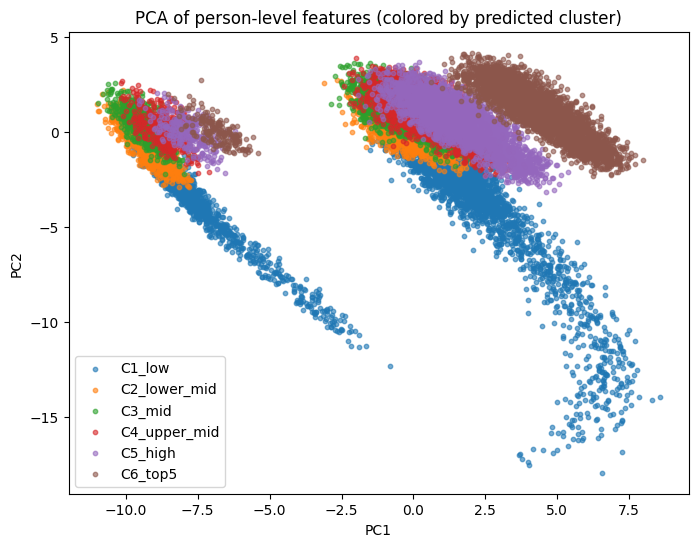

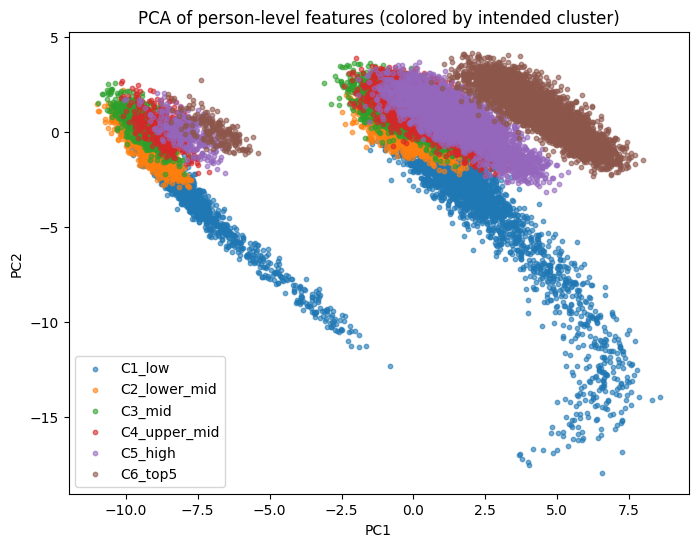

In [18]:
# final: pick best model by macro_f1 and save it with preprocess config.

import joblib
from sklearn.decomposition import PCA

# gather metrics
all_metrics = []
for k, v in STATE.items():
    if k.startswith("metrics_"):
        model_name = k.replace("metrics_", "")
        all_metrics.append((model_name, v["acc"], v["macro_f1"]))

res = pd.DataFrame(all_metrics, columns=["model","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nFinal model comparison:")
display(res)

best_row = res.iloc[0]
best_name = best_row["model"]
best_model = STATE.get(f"model_{best_name}")

print(f"\nBEST MODEL = {best_name} | acc={best_row['acc']:.4f} macro_f1={best_row['macro_f1']:.4f}")

# save everything needed for backend
os.makedirs("artifacts", exist_ok=True)

joblib.dump(best_model, "artifacts/best_cluster_model.pkl")

# save feature names and pipeline choices so server can reproduce input exactly
with open("artifacts/feature_cols.json", "w") as f:
    json.dump(STATE["feature_cols"], f, indent=2)

with open("artifacts/pipeline_config.json", "w") as f:
    json.dump({
        "norm_method": STATE.get("norm_method"),
        "reg_mode": STATE.get("reg_mode"),
        "reg_params": STATE.get("reg_params"),
        "outlier_method": STATE.get("outlier_method"),
        "feature_select_method": STATE.get("feature_select_method"),
        "scaler_method": STATE.get("scaler_method"),
        "standardization_method": STATE.get("standardization_method"),
        "sampling_method": STATE.get("sampling_method"),
    }, f, indent=2)

# if scaler / normalizer exist we dump them too (so backend uses same objects)
joblib.dump(STATE.get("norm_obj"), "artifacts/norm_obj.pkl")
joblib.dump(STATE.get("outlier_bounds"), "artifacts/outlier_bounds.pkl")
joblib.dump(STATE.get("scaler_obj"), "artifacts/scaler_obj.pkl")
joblib.dump(STATE.get("standardization_obj"), "artifacts/standardization_obj.pkl")
joblib.dump(STATE.get("sampler_obj"), "artifacts/sampler_obj.pkl")

print("\nSaved artifacts:")
!ls -lh artifacts

# ----------------------------
# Post-check: predicted vs intended clusters + PCA visualization
# ----------------------------

# Use the SAME representation the final models saw:
# If need a sanity check, run it on the TEST set (no leakage).
# (If need all data, use STATE["X_current"] + STATE["y"], but test is safer.)
Xte = STATE["Xte_final"]
yte = STATE["yte_final"]

# Rebuild a DataFrame with the correct column names/order for PCA labels/debugging
X_probe = pd.DataFrame(Xte, columns=STATE["feature_cols"])
y_intended = yte

# predicted classes
pred = best_model.predict(X_probe.values)

print("\nPredicted cluster counts:", dict(pd.Series(pred).value_counts().sort_index()))
print("Intended cluster counts:", dict(pd.Series(y_intended).value_counts().sort_index()))

# probability sanity (if available)
if hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(X_probe.values)
    top1 = proba.max(axis=1)
    print("\nTop-1 probability stats:",
          float(np.min(top1)), float(np.mean(top1)), float(np.max(top1)))
else:
    print("\nModel does not support predict_proba (skipping probability stats).")

# PCA projection for visualization
pca = PCA(n_components=2, random_state=RANDOM_SEED)
Z = pca.fit_transform(X_probe.values)

# PCA colored by predicted
plt.figure(figsize=(8, 6))
for k in range(6):
    mask = (pred == k)
    plt.scatter(Z[mask, 0], Z[mask, 1], s=10, alpha=0.6, label=CLUSTER_NAMES[k])
plt.title("PCA of person-level features (colored by predicted cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# PCA colored by intended
plt.figure(figsize=(8, 6))
for k in range(6):
    mask = (y_intended == k)
    plt.scatter(Z[mask, 0], Z[mask, 1], s=10, alpha=0.6, label=CLUSTER_NAMES[k])
plt.title("PCA of person-level features (colored by intended cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Load best model artifacts + define categories/meta

In [19]:
import json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- load artifacts saved ---
model = joblib.load("artifacts/best_cluster_model.pkl")

with open("artifacts/feature_cols.json", "r") as f:
    feature_cols = json.load(f)

with open("artifacts/pipeline_config.json", "r") as f:
    PIPECFG = json.load(f)

# optional objects (may be None if didn't save them during training)
try:
    norm_obj = joblib.load("artifacts/norm_obj.pkl")
except Exception:
    norm_obj = None

try:
    outlier_bounds = joblib.load("artifacts/outlier_bounds.pkl")  # expected: {"lo":Series/dict, "hi":Series/dict}
except Exception:
    outlier_bounds = None

try:
    scaler_obj = joblib.load("artifacts/scaler_obj.pkl")
except Exception:
    scaler_obj = None

try:
    standardization_obj = joblib.load("artifacts/standardization_obj.pkl")
except Exception:
    standardization_obj = None

# --- 17 categories (must match training data schema) ---
INCOME_COL = "Income_Deposits"

CATEGORIES_17 = [
    "Income_Deposits",
    "Housing",
    "Utilities_Telecom",
    "Groceries_FoodAtHome",
    "Dining_FoodAway",
    "Transportation_Gas",
    "Transportation_PublicTransit",
    "Insurance_Health",
    "Insurance_Auto",
    "Medical_OutOfPocket",
    "Debt_Payments",
    "Savings_Investments",
    "Education_Childcare",
    "Entertainment",
    "Subscriptions_Memberships",
    "Pets",
    "Travel",
]

OUTFLOW_COLS = [c for c in CATEGORIES_17 if c != INCOME_COL]

CLUSTER_META = {
    0: {"name":"C1_low",        "range_yr":"<$28k",            "range_mo":"<$2.3k"},
    1: {"name":"C2_lower_mid",  "range_yr":"$28k–$50k",        "range_mo":"$2.3k–$4.2k"},
    2: {"name":"C3_mid",        "range_yr":"$50k–$75k",        "range_mo":"$4.2k–$6.2k"},
    3: {"name":"C4_upper_mid",  "range_yr":"$75k–$155k",       "range_mo":"$6.2k–$12.9k"},
    4: {"name":"C5_high",       "range_yr":"$155k–$210k",      "range_mo":"$12.9k–$17.5k"},
    5: {"name":"C6_top5",       "range_yr":">=$210k (top 5%)", "range_mo":">=$17.5k"},
}

def expected_cluster_by_income(monthly_income):
    if monthly_income < 2300: return 0
    if monthly_income < 4200: return 1
    if monthly_income < 6200: return 2
    if monthly_income < 12900: return 3
    if monthly_income < 17500: return 4
    return 5

print("Loaded model + artifacts.")
print("feature_cols:", len(feature_cols))
print("pipeline_config:", PIPECFG)

Loaded model + artifacts.
feature_cols: 37
pipeline_config: {'norm_method': 'sqrt', 'reg_mode': 'l2', 'reg_params': {'C': 1.0}, 'outlier_method': 'none', 'feature_select_method': 'heatmap_drop', 'scaler_method': 'robust', 'standardization_method': 'none', 'sampling_method': 'SMOTE'}


Inference transforms + feature builders (one month + multi-month)

In [20]:
def _apply_norm_df(Xdf: pd.DataFrame, method: str):
    if method in (None, "none"):
        return Xdf

    X = Xdf.copy()

    if method == "log":
        return np.log1p(np.clip(X, 0, None))

    if method == "inverse":
        eps = 1e-3
        return 1.0 / (np.clip(X, 0, None) + eps)

    if method == "sqrt":
        return np.sqrt(np.clip(X, 0, None))

    if method == "square":
        return np.square(X)

    if method == "zscore":
        # NOTE: "zscore" in training was fitted; if used zscore here, MUST have scaler_obj instead.
        # Treat this as "do nothing" because proper zscore needs fitted mean/std.
        print("[WARN] norm_method=zscore requires fitted stats; skipping here. Prefer scaler_obj stage.")
        return X

    if method in ("yeo_johnson", "quantile_normal"):
        if norm_obj is None:
            raise RuntimeError(f"norm_method={method} but artifacts/norm_obj.pkl is missing. Save it during training.")
        Xt = norm_obj.transform(X.values)
        return pd.DataFrame(Xt, columns=X.columns, index=X.index)

    raise ValueError(f"Unknown norm_method: {method}")

def _apply_outlier_clip_df(Xdf: pd.DataFrame, outlier_method: str):
    if outlier_method in (None, "none"):
        return Xdf

    if outlier_bounds is None:
        print("[WARN] outlier_method set but artifacts/outlier_bounds.pkl missing; skipping clipping.")
        return Xdf

    lo = outlier_bounds.get("lo", None)
    hi = outlier_bounds.get("hi", None)
    if lo is None or hi is None:
        print("[WARN] outlier_bounds missing lo/hi; skipping clipping.")
        return Xdf

    # allow dict/Series
    lo_s = pd.Series(lo)
    hi_s = pd.Series(hi)

    # clip only columns that exist in bounds
    Xc = Xdf.copy()
    common = [c for c in Xc.columns if c in lo_s.index and c in hi_s.index]
    if not common:
        return Xc
    return Xc.clip(lower=lo_s[common], upper=hi_s[common], axis=1)

def apply_inference_pipeline(feats: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the SAME preprocessing choices used at training time (as much as possible from saved artifacts).
    Expects feats already aligned to `feature_cols` (final selected features).
    """
    X = feats.copy()

    # normalization (if used) — may require norm_obj
    X = _apply_norm_df(X, PIPECFG.get("norm_method"))

    # outlier clipping (if used) — requires outlier_bounds
    X = _apply_outlier_clip_df(X, PIPECFG.get("outlier_method"))

    # scaling (if used) — uses fitted scaler_obj
    if PIPECFG.get("scaler_method") not in (None, "none"):
        if scaler_obj is None:
            raise RuntimeError("scaler_method is set but artifacts/scaler_obj.pkl is missing.")
        X = pd.DataFrame(scaler_obj.transform(X.values), columns=X.columns, index=X.index)

    # row-wise normalization (if used) — uses fitted normalizer
    if PIPECFG.get("standardization_method") not in (None, "none"):
        if standardization_obj is None:
            raise RuntimeError("standardization_method is set but artifacts/standardization_obj.pkl is missing.")
        X = pd.DataFrame(standardization_obj.transform(X.values), columns=X.columns, index=X.index)

    return X

def month_dict_to_base_features(m: dict) -> dict:
    income = float(m[INCOME_COL])
    if income <= 0:
        raise ValueError("Income must be > 0")

    base = {}
    for c in OUTFLOW_COLS:
        base[f"{c}__share"] = float(m.get(c, 0.0)) / income

    total_out = sum(float(m.get(c, 0.0)) for c in OUTFLOW_COLS)
    net = income - total_out

    base["NetCashflowRate"] = net / income
    base["EssentialRate"] = (float(m.get("Housing",0.0)) +
                             float(m.get("Utilities_Telecom",0.0)) +
                             float(m.get("Groceries_FoodAtHome",0.0))) / income
    base["DebtRate"] = float(m.get("Debt_Payments",0.0)) / income
    base["SavingsRate"] = float(m.get("Savings_Investments",0.0)) / income
    base["DiscretionaryRate"] = (float(m.get("Dining_FoodAway",0.0)) +
                                 float(m.get("Entertainment",0.0)) +
                                 float(m.get("Travel",0.0)) +
                                 float(m.get("Subscriptions_Memberships",0.0))) / income
    return base

def months_to_features(months: list[dict]) -> pd.DataFrame:
    """
    Build the same person-level aggregate features you trained on:
    base monthly (shares + rates) -> mean/median/std
    """
    B = pd.DataFrame([month_dict_to_base_features(m) for m in months])

    agg = {}
    for c in B.columns:
        agg[f"{c}__mean"] = float(B[c].mean())
        agg[f"{c}__median"] = float(B[c].median())
        agg[f"{c}__std"] = float(B[c].std(ddof=0))

    feats = pd.DataFrame([agg])

    # align to final selected feature list
    for c in feature_cols:
        if c not in feats.columns:
            feats[c] = 0.0
    feats = feats[feature_cols]

    # apply inference transforms
    feats = apply_inference_pipeline(feats)
    return feats

def month_to_feature_row(month_dollars: dict) -> pd.DataFrame:
    """
    One-month "proxy person" features:
    mean=median=value, std ~ 0 (we keep tiny eps to avoid pathological zeros if you want)
    """
    row = {c: float(month_dollars.get(c, 0.0)) for c in CATEGORIES_17}
    df = pd.DataFrame([row])

    income = float(df[INCOME_COL].values[0])
    if income <= 0:
        raise ValueError("Income must be > 0 for shares/rates")

    # base monthly features
    base = {}
    for c in OUTFLOW_COLS:
        base[f"{c}__share"] = float(df[c].values[0]) / income

    total_out = float(df[OUTFLOW_COLS].sum(axis=1).values[0])
    net = income - total_out

    base["NetCashflowRate"] = net / income
    base["EssentialRate"] = float(df[["Housing","Utilities_Telecom","Groceries_FoodAtHome"]].sum(axis=1).values[0]) / income
    base["DebtRate"] = float(df["Debt_Payments"].values[0]) / income
    base["SavingsRate"] = float(df["Savings_Investments"].values[0]) / income
    base["DiscretionaryRate"] = float(df[["Dining_FoodAway","Entertainment","Travel","Subscriptions_Memberships"]].sum(axis=1).values[0]) / income

    # aggregate proxy
    eps_std = 0.0  # keep 0.0 to match your earlier intent; if needed, change to 1e-6
    agg = {}
    for k, v in base.items():
        agg[f"{k}__mean"] = float(v)
        agg[f"{k}__median"] = float(v)
        agg[f"{k}__std"] = float(eps_std)

    feats = pd.DataFrame([agg])

    # align to final selected feature list
    for c in feature_cols:
        if c not in feats.columns:
            feats[c] = 0.0
    feats = feats[feature_cols]

    # apply inference transforms
    feats = apply_inference_pipeline(feats)
    return feats

def proba_dict(proba):
    return {f"p_{CLUSTER_META[j]['name']}": float(proba[j]) for j in range(len(proba))}

def pretty_predict_one_month(month_dollars: dict):
    X = month_to_feature_row(month_dollars)
    proba = model.predict_proba(X.values)[0]
    pred = int(np.argmax(proba))

    print(f"Predicted cluster: {pred} | {CLUSTER_META[pred]['name']} | income ~ {CLUSTER_META[pred]['range_yr']} ({CLUSTER_META[pred]['range_mo']}/mo)")
    print("Probabilities:")
    for i, p in enumerate(proba * 100):
        print(f"  {i} {CLUSTER_META[i]['name']:<12} : {p:10.6f}%")
    return pred, proba

One-month test + 6-month behavior timeline test

Expected by income: 2 | C3_mid | $50k–$75k ($4.2k–$6.2k/mo)

Predicted cluster: 1 | C2_lower_mid | income ~ $28k–$50k ($2.3k–$4.2k/mo)
Probabilities:
  0 C1_low       :   0.192774%
  1 C2_lower_mid :  81.103020%
  2 C3_mid       :   1.424864%
  3 C4_upper_mid :   5.603523%
  4 C5_high      :   0.808951%
  5 C6_top5      :  10.866864%

--- Another extreme month ---

Expected by income: 5 | C6_top5 | >=$210k (top 5%) (>=$17.5k/mo)

Predicted cluster: 5 | C6_top5 | income ~ >=$210k (top 5%) (>=$17.5k/mo)
Probabilities:
  0 C1_low       :   0.003785%
  1 C2_lower_mid :   0.000107%
  2 C3_mid       :   0.000538%
  3 C4_upper_mid :   0.001516%
  4 C5_high      :   0.003300%
  5 C6_top5      :  99.990753%
Predicted cluster: 1 | C2_lower_mid | income ~ $28k–$50k ($2.3k–$4.2k/mo)
Probabilities:
  0 C1_low       :   0.192774%
  1 C2_lower_mid :  81.103020%
  2 C3_mid       :   1.424864%
  3 C4_upper_mid :   5.603523%
  4 C5_high      :   0.808951%
  5 C6_top5      :  10.866864%
Predicted cluster

month  SavingsRate  NetCashflowRate pred_single_month  top_prob_%  \
0      1     0.133333         0.143333      C2_lower_mid   81.103020   
1      2     0.150000         0.131667      C2_lower_mid   81.552383   
2      3     0.166667         0.120000      C2_lower_mid   81.916595   
3      4     0.183333         0.108333      C2_lower_mid   81.526527   
4      5     0.200000         0.096667      C2_lower_mid   82.131279   
5      6     0.216667         0.085000      C2_lower_mid   82.481873   

   p_C1_low  p_C2_lower_mid  p_C3_mid  p_C4_upper_mid  p_C5_high  p_C6_top5  
0  0.001928        0.811030  0.014249        0.056035   0.008090   0.108669  
1  0.002057        0.815524  0.013991        0.056058   0.008216   0.104154  
2  0.002104        0.819166  0.013936        0.055986   0.008447   0.100361  
3  0.002661        0.815265  0.013253        0.061350   0.008343   0.099128  
4  0.004506        0.821313  0.013425        0.048137   0.008577   0.104041  
5  0.005593        0.824819  0.010473        0.047646   0.008490   0.102980


Table 2 — Timeline prediction (cumulative months 1..t):



months_used  pred_index     pred_name  top_prob_%  p_C1_low  \
0            1           1  C2_lower_mid   81.103020  0.001928   
1            2           1  C2_lower_mid   81.433777  0.002054   
2            3           1  C2_lower_mid   81.552383  0.002057   
3            4           1  C2_lower_mid   82.005539  0.002031   
4            5           1  C2_lower_mid   81.916595  0.002104   
5            6           1  C2_lower_mid   81.541512  0.002217   

   p_C2_lower_mid  p_C3_mid  p_C4_upper_mid  p_C5_high  p_C6_top5  
0        0.811030  0.014249        0.056035   0.008090   0.108669  
1        0.814338  0.013971        0.055976   0.008092   0.105569  
2        0.815524  0.013991        0.056058   0.008216   0.104154  
3        0.820055  0.014038        0.055360   0.008268   0.100247  
4        0.819166  0.013936        0.055986   0.008447   0.100361  
5        0.815415  0.013516        0.061361   0.008344   0.099146


Plot — Predicted probabilities in log scale:



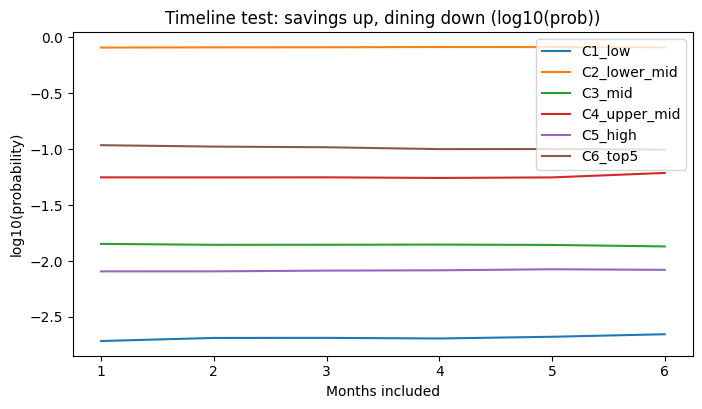

In [21]:
example_month = {
    "Income_Deposits": 6000,
    "Housing": 1800,
    "Utilities_Telecom": 250,
    "Groceries_FoodAtHome": 500,
    "Dining_FoodAway": 300,
    "Transportation_Gas": 200,
    "Transportation_PublicTransit": 0,
    "Insurance_Health": 200,
    "Insurance_Auto": 150,
    "Medical_OutOfPocket": 50,
    "Debt_Payments": 400,
    "Savings_Investments": 800,
    "Education_Childcare": 0,
    "Entertainment": 150,
    "Subscriptions_Memberships": 60,
    "Pets": 80,
    "Travel": 200,
}

example_month_2 = {
    "Income_Deposits": 490608.89,
    "Housing": 4960.89,
    "Utilities_Telecom": 3019.81,
    "Groceries_FoodAtHome": 496.09,
    "Dining_FoodAway": 1488.27,
    "Transportation_Gas": 224.53,
    "Transportation_PublicTransit": 19.82,
    "Insurance_Health": 779.54,
    "Insurance_Auto": 2893.02,
    "Medical_OutOfPocket": 9539.58,
    "Debt_Payments": 903.37,
    "Savings_Investments": 1936.71,
    "Education_Childcare": 452.55,
    "Entertainment": 1362.01,
    "Subscriptions_Memberships": 512.48,
    "Pets": 800,
    "Travel": 55.95,
}

exp_idx = expected_cluster_by_income(example_month["Income_Deposits"])
print(f"Expected by income: {exp_idx} | {CLUSTER_META[exp_idx]['name']} | {CLUSTER_META[exp_idx]['range_yr']} ({CLUSTER_META[exp_idx]['range_mo']}/mo)\n")
pretty_predict_one_month(example_month)

print("\n--- Another extreme month ---\n")
exp2 = expected_cluster_by_income(example_month_2["Income_Deposits"])
print(f"Expected by income: {exp2} | {CLUSTER_META[exp2]['name']} | {CLUSTER_META[exp2]['range_yr']} ({CLUSTER_META[exp2]['range_mo']}/mo)\n")
pretty_predict_one_month(example_month_2)

# ---- 6-month "behavior change" timeline test ----
def month_rates(m):
    inc = float(m[INCOME_COL])
    out = sum(float(m.get(c,0.0)) for c in OUTFLOW_COLS)
    return {
        "Income": inc,
        "SavingsRate": float(m.get("Savings_Investments",0.0))/inc,
        "DebtRate": float(m.get("Debt_Payments",0.0))/inc,
        "EssentialRate": (float(m.get("Housing",0.0))+float(m.get("Utilities_Telecom",0.0))+float(m.get("Groceries_FoodAtHome",0.0)))/inc,
        "DiscretionaryRate": (float(m.get("Dining_FoodAway",0.0))+float(m.get("Entertainment",0.0))+float(m.get("Travel",0.0))+float(m.get("Subscriptions_Memberships",0.0)))/inc,
        "NetCashflowRate": (inc - out)/inc,
    }

def run_trajectory(months: list[dict], title="Trajectory"):
    rows = []
    probas = []

    for t in range(1, len(months)+1):
        Xt = months_to_features(months[:t])
        proba = model.predict_proba(Xt.values)[0]
        pred = int(np.argmax(proba))
        probas.append(proba)

        row = {
            "months_used": t,
            "pred_index": pred,
            "pred_name": CLUSTER_META[pred]["name"],
            "top_prob_%": float(np.max(proba) * 100.0),
        }
        row.update(proba_dict(proba))
        rows.append(row)

    print("\nTable 2 — Timeline prediction (cumulative months 1..t):\n")
    df_out = pd.DataFrame(rows)
    display(df_out)

    # Plot — Predicted probabilities in log scale
    P = np.array(probas)
    x = np.arange(1, P.shape[0]+1)

    print("\nPlot — Predicted probabilities in log scale:\n")
    eps = 1e-12
    plt.figure(figsize=(8, 4.2))
    for i in range(P.shape[1]):
        plt.plot(x, np.log10(P[:, i] + eps), label=CLUSTER_META[i]["name"])
    plt.title(title + " (log10(prob))")
    plt.xlabel("Months included")
    plt.ylabel("log10(probability)")
    plt.legend()
    plt.show()

# hardcoded months for behavior test
month1 = dict(example_month)

month2 = dict(example_month); month2["Savings_Investments"] = 900;  month2["Dining_FoodAway"] = 270
month3 = dict(example_month); month3["Savings_Investments"] = 1000; month3["Dining_FoodAway"] = 240
month4 = dict(example_month); month4["Savings_Investments"] = 1100; month4["Dining_FoodAway"] = 210
month5 = dict(example_month); month5["Savings_Investments"] = 1200; month5["Dining_FoodAway"] = 180
month6 = dict(example_month); month6["Savings_Investments"] = 1300; month6["Dining_FoodAway"] = 150

months_demo = [month1, month2, month3, month4, month5, month6]

rows = []
for i, m in enumerate(months_demo, 1):
    pred1, proba1 = pretty_predict_one_month(m)
    rates = month_rates(m)
    row = {
        "month": i,
        "SavingsRate": rates["SavingsRate"],
        "NetCashflowRate": rates["NetCashflowRate"],
        "pred_single_month": CLUSTER_META[pred1]["name"],
        "top_prob_%": float(np.max(proba1)*100),
    }
    row.update(proba_dict(proba1))
    rows.append(row)

print("\nTable 1 — Single-month prediction + rates:\n")
display(pd.DataFrame(rows))

run_trajectory(months_demo, title="Timeline test: savings up, dining down")

48-month what-if transition C1 -> C4 (heuristic + tables + radar + plots)


Searching anchor C1->0 (income=2200, max_tries=2500)


Searching anchor C1->0:   0%|          | 0/2500 [00:00<?, ?it/s]

[FOUND] C1->0 at try=0 | top_p=1.0000 | p_target=1.0000

Searching anchor C4->3 (income=9000, max_tries=2500)


Searching anchor C4->3:   0%|          | 0/2500 [00:00<?, ?it/s]

[FOUND] C4->3 at try=1968 | top_p=0.9822 | p_target=0.9822

Expectation:

Expected (intent): start=C1_low -> target=C4_upper_mid
Expected by income (month 1):  C1_low
Expected by income (month 48): C4_upper_mid

Anchors found (single-month view for month 1 of each anchor):

Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.999809%
  1 C2_lower_mid :   0.000068%
  2 C3_mid       :   0.000002%
  3 C4_upper_mid :   0.000042%
  4 C5_high      :   0.000006%
  5 C6_top5      :   0.000077%
Predicted cluster: 3 | C4_upper_mid | income ~ $75k–$155k ($6.2k–$12.9k/mo)
Probabilities:
  0 C1_low       :   0.044454%
  1 C2_lower_mid :   0.036840%
  2 C3_mid       :  23.354239%
  3 C4_upper_mid :  76.213989%
  4 C5_high      :   0.050367%
  5 C6_top5      :   0.300115%

Table 0 — Dollar amounts per month (all categories):



month  Income_Deposits  Housing  Utilities_Telecom  Groceries_FoodAtHome  \
0       1      2200.000000   746.85             128.51                227.71   
1       2      2344.680851   779.72             126.37                243.55   
2       3      2489.361702   767.79             125.89                254.57   
3       4      2634.042553   811.40             132.82                259.19   
4       5      2778.723404   851.23             145.36                252.21   
5       6      2923.404255   877.25             144.93                246.19   
6       7      3068.085106   807.34             142.23                252.30   
7       8      3212.765957   788.90             136.88                253.04   
8       9      3357.446809   774.52             138.40                247.14   
9      10      3502.127660   758.68             145.51                239.77   
10     11      3646.808511   744.06             149.81                275.14   
11     12      3791.489362   858.56             163.30                271.81   
12     13      3936.170213   861.49             189.46                254.23   
13     14      4080.851064   843.63             192.34                274.46   
14     15      4225.531915   889.06             202.86                319.43   
15     16      4370.212766   877.90             208.60                280.09   
16     17      4514.893617   951.20             210.97                283.41   
17     18      4659.574468   983.79             247.06                317.81   
18     19      4804.255319  1004.19             245.69                312.53   
19     20      4948.936170  1042.26             232.39                309.56   
20     21      5093.617021  1115.86             234.52                333.45   
21     22      5238.297872  1096.60             249.29                358.57   
22     23      5382.978723  1101.29             269.50                377.38   
23     24      5527.659574  1141.10             279.51                360.95   
24     25      5672.340426  1077.81             267.86                371.23   
25     26      5817.021277  1152.87             279.71                389.43   
26     27      5961.702128  1305.37             309.26                383.83   
27     28      6106.382979  1319.94             273.19                406.69   
28     29      6251.063830  1425.52             291.60                394.32   
29     30      6395.744681  1330.05             293.81                391.34   
30     31      6540.425532  1378.50             326.96                395.49   
31     32      6685.106383  1269.52             321.40                358.13   
32     33      6829.787234  1361.13             319.39                420.04   
33     34      6974.468085  1470.21             361.33                418.85   
34     35      7119.148936  1497.24             351.91                437.11   
35     36      7263.829787  1543.42             360.82                446.87   
36     37      7408.510638  1716.47             388.58                447.91   
37     38      7553.191489  1851.85             336.94                419.84   
38     39      7697.872340  1587.78             369.12                433.21   
39     40      7842.553191  1708.58             364.19                458.93   
40     41      7987.234043  1577.80             393.81                538.98   
41     42      8131.914894  1606.64             398.95                557.24   
42     43      8276.595745  1653.14             369.15                558.29   
43     44      8421.276596  1717.76             382.81                546.74   
44     45      8565.957447  1926.48             379.15                507.54   
45     46      8710.638298  1901.28             433.38                454.99   
46     47      8855.319149  1979.31             444.21                471.97   
47     48      9000.000000  1829.38             487.28                591.27   

    Dining_FoodAway  Transportation_Gas  Transportation_PublicTransit  \
0         


Table 0b — Dollar change per month (Δ$ for all categories):



month  Income_Deposits  Housing  Utilities_Telecom  Groceries_FoodAtHome  \
0       1         0.000000     0.00               0.00                  0.00   
1       2       144.680851    32.87              -2.14                 15.84   
2       3       144.680851   -11.93              -0.48                 11.02   
3       4       144.680851    43.61               6.93                  4.62   
4       5       144.680851    39.83              12.54                 -6.98   
5       6       144.680851    26.02              -0.43                 -6.02   
6       7       144.680851   -69.91              -2.70                  6.11   
7       8       144.680851   -18.44              -5.35                  0.74   
8       9       144.680851   -14.38               1.52                 -5.90   
9      10       144.680851   -15.84               7.11                 -7.37   
10     11       144.680851   -14.62               4.30                 35.37   
11     12       144.680851   114.50              13.49                 -3.33   
12     13       144.680851     2.93              26.16                -17.58   
13     14       144.680851   -17.86               2.88                 20.23   
14     15       144.680851    45.43              10.52                 44.97   
15     16       144.680851   -11.16               5.74                -39.34   
16     17       144.680851    73.30               2.37                  3.32   
17     18       144.680851    32.59              36.09                 34.40   
18     19       144.680851    20.40              -1.37                 -5.28   
19     20       144.680851    38.07             -13.30                 -2.97   
20     21       144.680851    73.60               2.13                 23.89   
21     22       144.680851   -19.26              14.77                 25.12   
22     23       144.680851     4.69              20.21                 18.81   
23     24       144.680851    39.81              10.01                -16.43   
24     25       144.680851   -63.29             -11.65                 10.28   
25     26       144.680851    75.06              11.85                 18.20   
26     27       144.680851   152.50              29.55                 -5.60   
27     28       144.680851    14.57             -36.07                 22.86   
28     29       144.680851   105.58              18.41                -12.37   
29     30       144.680851   -95.47               2.21                 -2.98   
30     31       144.680851    48.45              33.15                  4.15   
31     32       144.680851  -108.98              -5.56                -37.36   
32     33       144.680851    91.61              -2.01                 61.91   
33     34       144.680851   109.08              41.94                 -1.19   
34     35       144.680851    27.03              -9.42                 18.26   
35     36       144.680851    46.18               8.91                  9.76   
36     37       144.680851   173.05              27.76                  1.04   
37     38       144.680851   135.38             -51.64                -28.07   
38     39       144.680851  -264.07              32.18                 13.37   
39     40       144.680851   120.80              -4.93                 25.72   
40     41       144.680851  -130.78              29.62                 80.05   
41     42       144.680851    28.84               5.14                 18.26   
42     43       144.680851    46.50             -29.80                  1.05   
43     44       144.680851    64.62              13.66                -11.55   
44     45       144.680851   208.72              -3.66                -39.20   
45     46       144.680851   -25.20              54.23                -52.55   
46     47       144.680851    78.03              10.83                 16.98   
47     48       144.680851  -149.93              43.07                119.30   

    Dining_FoodAway  Transportation_Gas  Transportation_PublicTransit  \
0         

Single-month predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.999725%
  1 C2_lower_mid :   0.000111%
  2 C3_mid       :   0.000004%
  3 C4_upper_mid :   0.000039%
  4 C5_high      :   0.000013%
  5 C6_top5      :   0.000113%
Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.999252%
  1 C2_lower_mid :   0.000377%
  2 C3_mid       :   0.000014%
  3 C4_upper_mid :   0.000091%
  4 C5_high      :   0.000025%
  5 C6_top5      :   0.000247%
Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.997482%
  1 C2_lower_mid :   0.001349%
  2 C3_mid       :   0.000035%
  3 C4_upper_mid :   0.000201%
  4 C5_high      :   0.000048%
  5 C6_top5      :   0.000887%
Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.995895%
  1 C2_lower_mid :   0.001769%
  2 C3_mid       :   0.000044%
  3 C4_upper_mid :   0.000362%
  4 C5_high      :   0

month       Income  SavingsRate  NetCashflowRate pred_single_month  \
0       1  2200.000000     0.027832         0.145232            C1_low   
1       2  2344.680851     0.044019         0.140002            C1_low   
2       3  2489.361702     0.057031         0.151762            C1_low   
3       4  2634.042553     0.069190         0.142645            C1_low   
4       5  2778.723404     0.086025         0.140004            C1_low   
5       6  2923.404255     0.105774         0.144757      C2_lower_mid   
6       7  3068.085106     0.113097         0.184159      C2_lower_mid   
7       8  3212.765957     0.129203         0.190719           C6_top5   
8       9  3357.446809     0.159038         0.187445           C6_top5   
9      10  3502.127660     0.166513         0.202696           C6_top5   
10     11  3646.808511     0.167053         0.211267           C6_top5   
11     12  3791.489362     0.177112         0.172441           C6_top5   
12     13  3936.170213     0.184707         0.178900            C3_mid   
13     14  4080.851064     0.188390         0.188162           C6_top5   
14     15  4225.531915     0.185070         0.182567      C2_lower_mid   
15     16  4370.212766     0.187529         0.198076            C3_mid   
16     17  4514.893617     0.195998         0.184061            C3_mid   
17     18  4659.574468     0.211938         0.158142      C2_lower_mid   
18     19  4804.255319     0.189921         0.184642            C3_mid   
19     20  4948.936170     0.207556         0.159438            C3_mid   
20     21  5093.617021     0.225612         0.140004            C3_mid   
21     22  5238.297872     0.214427         0.157354      C2_lower_mid   
22     23  5382.978723     0.228238         0.146610      C2_lower_mid   
23     24  5527.659574     0.240107         0.139998            C3_mid   
24     25  5672.340426     0.241639         0.159042            C3_mid   
25     26  5817.021277     0.212126         0.183175           C6_top5   
26     27  5961.702128     0.225635         0.146116            C3_mid   
27     28  6106.382979     0.228354         0.150736            C3_mid   
28     29  6251.063830     0.227113         0.140001            C3_mid   
29     30  6395.744681     0.233069         0.145296            C3_mid   
30     31  6540.425532     0.238714         0.139999            C3_mid   
31     32  6685.106383     0.264902         0.154319      C4_upper_mid   
32     33  6829.787234     0.259090         0.139998            C3_mid   
33     34  6974.468085     0.207120         0.180250            C3_mid   
34     35  7119.148936     0.214447         0.171301            C3_mid   
35     36  7263.829787     0.200502         0.182278            C3_mid   
36     37  7408.510638     0.198177         0.167063            C3_mid   
37     38  7553.191489     0.226347         0.140001      C4_upper_mid   
38     39  7697.872340     0.217654         0.180572      C4_upper_mid   
39     40  7842.553191     0.218167         0.163371      C4_upper_mid   
40     41  7987.234043     0.247524         0.141182            C3_mid   
41     42  8131.914894     0.212615         0.182801           C6_top5   
42     43  8276.595745     0.237725         0.146859      C2_lower_mid   
43     44  8421.276596     0.218722         0.178484            C3_mid   
44     45  8565.957447     0.221332         0.160534            C3_mid   
45     46  8710.638298     0.231474         0.157597      C4_upper_mid   
46     47  8855.319149     0.249983         0.140001      C4_upper_mid   
47     48  9000.000000     0.243704         0.140002            C3_mid   

    top_prob_%  p_C1_low  p_C2_lower_mid      p_C3_mid  p_C4_upper_mid  \
0    99.999725  0.999997        0.000001  4.092342e-08    3.941707e-07   
1    99.999252  0.999992        0.000004  1.420010e-07    9.095235e-07   
2    99.997482  0.999975        0.000013  3.523042e-07    2.014896e-06   
3    99.995895  0.999959        0.000018  4.445257e-07    3.618937e-06   
4    99


Table 2 — Timeline prediction (cumulative months 1..t):



months_used  pred_index     pred_name  top_prob_%  p_C1_low  \
0             1           0        C1_low   99.999725  0.999997   
1             2           0        C1_low   99.999664  0.999997   
2             3           0        C1_low   99.999214  0.999992   
3             4           0        C1_low   99.998451  0.999985   
4             5           0        C1_low   99.997581  0.999976   
5             6           0        C1_low   99.996819  0.999968   
6             7           0        C1_low   99.997177  0.999972   
7             8           0        C1_low   99.994911  0.999949   
8             9           0        C1_low   99.981133  0.999811   
9            10           0        C1_low   99.198090  0.991981   
10           11           1  C2_lower_mid   73.233673  0.019928   
11           12           1  C2_lower_mid   65.617302  0.016998   
12           13           1  C2_lower_mid   65.126770  0.014577   
13           14           1  C2_lower_mid   63.531673  0.013998   
14           15           5       C6_top5   65.755028  0.007023   
15           16           5       C6_top5   66.250595  0.006699   
16           17           5       C6_top5   73.072075  0.005860   
17           18           5       C6_top5   73.225456  0.005703   
18           19           5       C6_top5   73.283607  0.005883   
19           20           5       C6_top5   75.264137  0.005065   
20           21           5       C6_top5   76.599731  0.004532   
21           22           1  C2_lower_mid   49.287189  0.006280   
22           23           5       C6_top5   48.598644  0.006095   
23           24           1  C2_lower_mid   54.925911  0.004427   
24           25           1  C2_lower_mid   57.158661  0.004075   
25           26           5       C6_top5   51.478313  0.005126   
26           27           5       C6_top5   52.724068  0.005211   
27           28           5       C6_top5   52.520538  0.005080   
28           29           1  C2_lower_mid   57.121361  0.006589   
29           30           1  C2_lower_mid   55.371464  0.006387   
30           31           1  C2_lower_mid   55.455750  0.006397   
31           32           1  C2_lower_mid   55.437191  0.006395   
32           33           1  C2_lower_mid   55.316013  0.006411   
33           34           1  C2_lower_mid   55.215984  0.006385   
34           35           1  C2_lower_mid   56.882889  0.006578   
35           36           1  C2_lower_mid   56.918388  0.006582   
36           37           2        C3_mid   94.048431  0.000989   
37           38           2        C3_mid   94.103127  0.000979   
38           39           2        C3_mid   94.097260  0.000979   
39           40           2        C3_mid   93.980644  0.000976   
40           41           2        C3_mid   93.729660  0.001018   
41           42           2        C3_mid   93.655418  0.001016   
42           43           2        C3_mid   93.835487  0.000988   
43           44           2        C3_mid   93.810776  0.000991   
44           45           2        C3_mid   93.685326  0.000952   
45           46           2        C3_mid   93.489853  0.000980   
46           47           2        C3_mid   93.065575  0.001051   
47           48           2        C3_mid   93.066597  0.001051   

    p_C2_lower_mid      p_C3_mid  p_C4_upper_mid     p_C5_high  p_C6_top5  
0         0.000001  4.092342e-08    3.941707e-07  1.271088e-07   0.000001  
1         0.000001  6.217121e-08    4.798237e-07  1.332380e-07   0.000001  
2         0.000004  1.394780e-07    9.250813e-07  2.528542e-07   0.000003  
3         0.000008  2.043173e-07    1.338600e-06  3.383550e-07   0.000006  
4         0.000013  3.434654e-07    1.942256e-06  4.652048e-07   0.000009  
5         0.000018  4.129757e-07    2.646181e-06  5.965731e-07   0.000010  
6         0.000012  2.951482e-07    2.354526e-06  4.320030e-07   0.000014  
7         0.000027  3.315888e-07    3.856781e-06  5.712722e-07   0.000019  
8         0.000117  1.048780e-06    


Plot — Predicted probabilities in log scale:



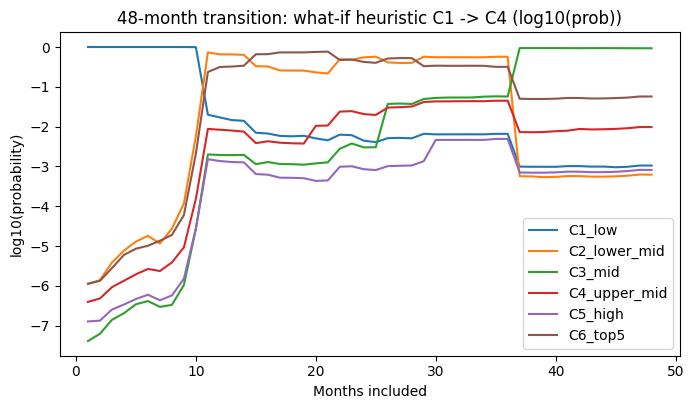


Plot — Radar chart (probabilities every 12 months):



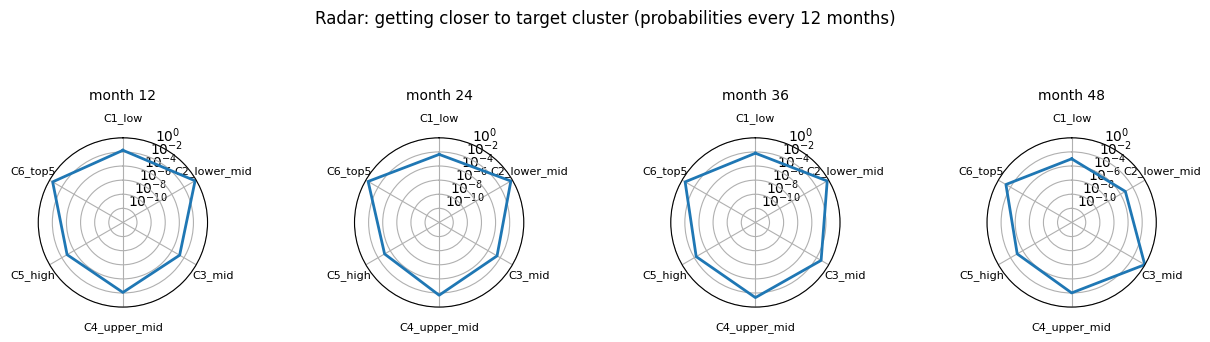

checkpoint_month  pred_index     pred_name  top_prob_%  p_C1_low  \
0                12           1  C2_lower_mid   65.617302  0.016998   
1                24           1  C2_lower_mid   54.925911  0.004427   
2                36           1  C2_lower_mid   56.918388  0.006582   
3                48           2        C3_mid   93.066597  0.001051   

   p_C2_lower_mid  p_C3_mid  p_C4_upper_mid  p_C5_high  p_C6_top5  
0        0.656173  0.001939        0.008345   0.001364   0.315182  
1        0.549259  0.003006        0.020651   0.000851   0.421806  
2        0.569184  0.057086        0.044724   0.004905   0.317518  
3        0.000619  0.930666        0.009741   0.000813   0.057110

In [24]:
RANDOM_SEED = 42

def lerp(a, b, t):
    return a + (b - a) * t

def random_budget_shares_biased(rng, mode="C1"):
    """
    Biased share generator for anchors.
    """
    s = {c: 0.0 for c in OUTFLOW_COLS}

    if mode == "C1":
        s["Housing"] = rng.uniform(0.35, 0.48)
        s["Utilities_Telecom"] = rng.uniform(0.06, 0.10)
        s["Groceries_FoodAtHome"] = rng.uniform(0.10, 0.16)

        s["Debt_Payments"] = rng.uniform(0.10, 0.20)
        s["Savings_Investments"] = rng.uniform(0.00, 0.03)

        s["Dining_FoodAway"] = rng.uniform(0.01, 0.05)
        s["Entertainment"] = rng.uniform(0.00, 0.02)
        s["Subscriptions_Memberships"] = rng.uniform(0.00, 0.01)
        s["Travel"] = rng.uniform(0.00, 0.01)

        for c in ["Transportation_Gas","Transportation_PublicTransit","Insurance_Health","Insurance_Auto","Medical_OutOfPocket","Pets","Education_Childcare"]:
            if c in s:
                s[c] = rng.uniform(0.00, 0.06)

        cap = rng.uniform(0.82, 0.92)

    elif mode == "C4":
        s["Housing"] = rng.uniform(0.22, 0.32)
        s["Utilities_Telecom"] = rng.uniform(0.04, 0.08)
        s["Groceries_FoodAtHome"] = rng.uniform(0.06, 0.11)

        s["Debt_Payments"] = rng.uniform(0.02, 0.10)
        s["Savings_Investments"] = rng.uniform(0.12, 0.25)

        s["Dining_FoodAway"] = rng.uniform(0.03, 0.08)
        s["Entertainment"] = rng.uniform(0.01, 0.04)
        s["Subscriptions_Memberships"] = rng.uniform(0.005, 0.02)
        s["Travel"] = rng.uniform(0.01, 0.06)

        for c in ["Transportation_Gas","Transportation_PublicTransit","Insurance_Health","Insurance_Auto","Medical_OutOfPocket","Pets","Education_Childcare"]:
            if c in s:
                s[c] = rng.uniform(0.00, 0.06)

        cap = rng.uniform(0.75, 0.88)
    else:
        raise ValueError(mode)

    total = sum(float(v) for v in s.values())
    if total > cap and total > 0:
        scale = cap / total
        for k in s:
            s[k] = float(s[k]) * scale

    for k in s:
        s[k] = max(0.0, float(s[k]))
    return s

def make_month_from_shares(income, shares):
    m = {INCOME_COL: float(income)}
    for c in OUTFLOW_COLS:
        m[c] = round(float(shares.get(c, 0.0)) * float(income), 2)
    return m

def simulate_person_months(income, mode, months=48, noise=0.10, seed=42):
    rng = np.random.default_rng(seed)
    out = []
    for _ in range(months):
        shares = random_budget_shares_biased(rng, mode=mode)

        # month-to-month variation so std features exist
        for c in OUTFLOW_COLS:
            shares[c] = max(0.0, float(shares.get(c, 0.0)) * float(rng.normal(1.0, noise)))

        # recap
        cap = 0.90 if mode == "C1" else 0.85
        total = sum(float(v) for v in shares.values())
        if total > cap and total > 0:
            scale = cap / total
            for k in shares:
                shares[k] = float(shares[k]) * scale

        inc = float(income) * float(rng.normal(1.0, 0.02))
        inc = max(1.0, inc)

        out.append(make_month_from_shares(inc, shares))
    return out

def find_anchor_for_cluster(target_idx, income, mode, max_tries=2500, seed=42):
    rng = np.random.default_rng(seed)
    best_months, best_proba = None, None
    best_target_p = -1.0

    # NOTE: leave=True so the bar doesn't instantly "disappear" (looks like it skipped)
    print(f"\nSearching anchor {mode}->{target_idx} (income={income}, max_tries={max_tries})")
    pbar = tqdm(range(max_tries), desc=f"Searching anchor {mode}->{target_idx}", leave=True, miniters=1)

    for k in pbar:
        months = simulate_person_months(income=income, mode=mode, months=48, noise=0.12, seed=int(seed + k))
        Xt = months_to_features(months)
        proba = model.predict_proba(Xt.values)[0]
        pred = int(np.argmax(proba))

        p_target = float(proba[target_idx])
        if p_target > best_target_p:
            best_target_p = p_target
            best_months, best_proba = months, proba

        # keep some live signal even if it finds the anchor quickly on k=0/1
        pbar.set_postfix({"pred": pred, "p_target": f"{p_target:.4f}", "best": f"{best_target_p:.4f}"})

        if pred == target_idx:
            pbar.close()
            print(f"[FOUND] {mode}->{target_idx} at try={k} | top_p={float(np.max(proba)):.4f} | p_target={p_target:.4f}")
            return months, proba

    pbar.close()
    print(f"[NOT FOUND] {mode}->{target_idx}. Returning best candidate with p_target={best_target_p:.4f}")
    return best_months, best_proba

def profile_from_months(months, eps=1e-12):
    income = np.array([float(m[INCOME_COL]) for m in months], dtype=np.float64)
    prof = {}
    for c in OUTFLOW_COLS:
        v = np.array([float(m.get(c, 0.0)) for m in months], dtype=np.float64)
        prof[c] = float(np.mean(v / np.maximum(income, eps)))
    return prof

def cap_and_fix_shares(shares, cap=0.86):
    s = dict(shares)
    for c in OUTFLOW_COLS:
        s[c] = max(0.0, float(s.get(c, 0.0)))
    total = sum(float(v) for v in s.values())
    if total > cap and total > 0:
        scale = cap / total
        for c in s:
            s[c] = float(s[c]) * scale
    return s

def what_if_transition(start_profile, target_profile, income_start, income_end, months=48, noise=0.06, seed=42):
    rng = np.random.default_rng(seed)
    out = []
    current = dict(start_profile)

    for i in range(months):
        t = i / (months - 1)
        income_t = lerp(float(income_start), float(income_end), t)

        # heuristic: gradually move shares towards target profile
        alpha = 0.10 + 0.55 * t
        proposed = {}
        for c in OUTFLOW_COLS:
            proposed[c] = lerp(float(current.get(c, 0.0)), float(target_profile.get(c, 0.0)), alpha)

        # nudges (policy)
        proposed["Savings_Investments"] = proposed.get("Savings_Investments", 0.0) + 0.05 * t
        proposed["Debt_Payments"] = max(0.0, proposed.get("Debt_Payments", 0.0) * (1.0 - 0.55 * t))

        # keep essentials not collapsing
        proposed["Housing"] = max(proposed.get("Housing", 0.0), 0.18)
        proposed["Groceries_FoodAtHome"] = max(proposed.get("Groceries_FoodAtHome", 0.0), 0.06)
        proposed["Utilities_Telecom"] = max(proposed.get("Utilities_Telecom", 0.0), 0.03)

        proposed = cap_and_fix_shares(proposed, cap=0.86)

        # month noise (std features)
        noisy = {}
        for c in OUTFLOW_COLS:
            noisy[c] = max(0.0, float(proposed.get(c, 0.0)) * float(rng.normal(1.0, noise)))
        noisy = cap_and_fix_shares(noisy, cap=0.86)

        current = noisy
        out.append(make_month_from_shares(income_t, noisy))

    return out

def radar_probs_checkpoints(months, checkpoints=(12,24,36,48), title="Radar: cluster probabilities at checkpoints"):
    labels = [CLUSTER_META[i]["name"] for i in range(6)]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    eps = 1e-12

    # 4 radars in one row, slightly smaller height to reduce title overlap
    fig, axes = plt.subplots(1, len(checkpoints), figsize=(3.2*len(checkpoints), 3.0), subplot_kw={"polar": True})
    if len(checkpoints) == 1:
        axes = [axes]

    rows = []
    for ax, t in zip(axes, checkpoints):
        Xt = months_to_features(months[:t])
        proba = model.predict_proba(Xt.values)[0]
        pred = int(np.argmax(proba))

        vals = [max(eps, float(v)) for v in proba.tolist()]
        vals += vals[:1]

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=8)

        # log scaling so tiny probabilities are visible
        ax.set_rscale("log")
        ax.set_rlim(eps, 1.0)

        ax.plot(angles, vals, linewidth=2)
        ax.set_title(f"month {t}", y=1.18, fontsize=10)

        row = {
            "checkpoint_month": t,
            "pred_index": pred,
            "pred_name": CLUSTER_META[pred]["name"],
            "top_prob_%": float(np.max(proba) * 100.0),
        }
        row.update(proba_dict(proba))
        rows.append(row)

    print("\nPlot — Radar chart (probabilities every 12 months):\n")
    fig.suptitle(title, y=1.10)
    plt.tight_layout()
    plt.show()

    display(pd.DataFrame(rows))

# ---- anchors + what-if transition ----
TARGET_C1 = 0
TARGET_C4 = 3

anchor_c1_months, p_c1 = find_anchor_for_cluster(TARGET_C1, income=2200, mode="C1", seed=RANDOM_SEED)
anchor_c4_months, p_c4 = find_anchor_for_cluster(TARGET_C4, income=9000, mode="C4", seed=RANDOM_SEED + 1)

if anchor_c1_months is None or anchor_c4_months is None:
    raise RuntimeError("Could not find anchors fast enough. Increase max_tries or loosen ranges in random_budget_shares_biased().")

start_profile = profile_from_months(anchor_c1_months)
target_profile = profile_from_months(anchor_c4_months)

print("\nExpectation:\n")
print(f"Expected (intent): start={CLUSTER_META[TARGET_C1]['name']} -> target={CLUSTER_META[TARGET_C4]['name']}")
print(f"Expected by income (month 1):  {CLUSTER_META[expected_cluster_by_income(2200.0)]['name']}")
print(f"Expected by income (month 48): {CLUSTER_META[expected_cluster_by_income(9000.0)]['name']}")

print("\nAnchors found (single-month view for month 1 of each anchor):\n")
pretty_predict_one_month(anchor_c1_months[0])
pretty_predict_one_month(anchor_c4_months[0])

months_48 = what_if_transition(
    start_profile=start_profile,
    target_profile=target_profile,
    income_start=2200,
    income_end=9000,
    months=48,
    noise=0.06,
    seed=RANDOM_SEED
)

# ---------- Table 0 ($ amounts) + Table 0b (Δ$) ----------
df_dollars = pd.DataFrame(months_48)
df_dollars.insert(0, "month", np.arange(1, len(df_dollars) + 1))

df_delta = df_dollars.copy()
for c in [INCOME_COL] + OUTFLOW_COLS:
    df_delta[c] = df_dollars[c].diff().fillna(0.0)

print("\nTable 0 — Dollar amounts per month (all categories):\n")
display(df_dollars)

print("\nTable 0b — Dollar change per month (Δ$ for all categories):\n")
display(df_delta)

# ---------- Table 1 (single-month prediction + rates) ----------
rows = []
for i, m in enumerate(tqdm(months_48, desc="Single-month predictions", leave=False), 1):
    pred1, proba1 = pretty_predict_one_month(m)
    rates = month_rates(m)
    row = {
        "month": i,
        "Income": rates["Income"],
        "SavingsRate": rates["SavingsRate"],
        "NetCashflowRate": rates["NetCashflowRate"],
        "pred_single_month": CLUSTER_META[pred1]["name"],
        "top_prob_%": float(np.max(proba1) * 100),
    }
    row.update(proba_dict(proba1))
    rows.append(row)

print("\nTable 1 — Single-month prediction + rates:\n")
display(pd.DataFrame(rows))

# ---------- Trajectory (cumulative months) + log prob plot ----------
run_trajectory(months_48, title="48-month transition: what-if heuristic C1 -> C4")

# ---------- Radar checkpoints ----------
radar_probs_checkpoints(
    months_48,
    checkpoints=(12,24,36,48),
    title="Radar: getting closer to target cluster (probabilities every 12 months)"
)